# Mean Reversion Algorithmic Trading Strategy
### Automated in OANDA FX Practice

#### Prepared for the "Certificate Program for Algorithmic Trading with Python"
#### <font color='red'>Emrah Ozpeynirci - November 2017 </font>

### Abstract

This project aims to demonstrate how to compute a mean reversion algorithmic trading strategy on any choosen currency pair. Most currency pairs price series are not mean reverting, but they are geometric random walks. It is the returns, not the prices, are the ones that usually randomly distributed around the mean of zero. Unfortunately, one can not trade on the mean reversion of returns. Therefore our analysis assumes the current price level will tell something about what the next price move will be: If the price level is higher than the mean, the next move will be downward move; if the price level is lower than the mean, the next move will be an upward move. However, this description fails to convey the more complex issues, such as the difficulties in determining whether the currency pair time series behaves like a mean reverting process. Furthermore, even if the underlying stochastic process implies reversion to some equilibrium exchange rate price, this does not exclude the possibility of sustained and potential large deviations from this equilibrium. The longer the deviation from the mean persists the higher the risk of substantial equity drawdowns. Ideally, one should first obtain high confidence that the time series under consideration is indeed mean reverting and that the half life of mean reversion is sufficiently low, before allocating capital.

In the following part we start with an overview of the concept of stationarity and the relevant statistical methods that can be applied to test individual time series for mean reversion.   

## Collecting the Financial Data
Time Series data has been collected using OANDA History function. We used our own config file "algotrader.pyg" which provides account information and necessary keys. 

#### Imports

We used 'statsmodel' libraries extensively to conduct the necessary statistical tests to verify the mean reverting pairs. In addition, 'numpy' and 'pandas' are used for vectorization and backtesting purposes. 

To connect OANDA and execute the automation a special wrapper class is used 'tpqoa'

In [1]:
from tpqoa import tpqoa
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn')
import seaborn as sns
%matplotlib inline
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import math

import datetime as dt

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

/root/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
oanda = tpqoa('algotrader.pyg') # config file contains account information and keys

In [3]:
oanda.get_instruments() # available OANDA instruments, and we tested many of those to find the right pair which 
                            # to our serves our strategy

[('Brent Crude Oil', 'BCO_USD'),
 ('Copper', 'XCU_USD'),
 ('Germany 30', 'DE30_EUR'),
 ('EUR/ZAR', 'EUR_ZAR'),
 ('US Nas 100', 'NAS100_USD'),
 ('Netherlands 25', 'NL25_EUR'),
 ('Silver/GBP', 'XAG_GBP'),
 ('EUR/HUF', 'EUR_HUF'),
 ('Silver/HKD', 'XAG_HKD'),
 ('Singapore 30', 'SG30_SGD'),
 ('EUR/NOK', 'EUR_NOK'),
 ('Gold/HKD', 'XAU_HKD'),
 ('USD/HUF', 'USD_HUF'),
 ('GBP/ZAR', 'GBP_ZAR'),
 ('Sugar', 'SUGAR_USD'),
 ('NZD/SGD', 'NZD_SGD'),
 ('CAD/JPY', 'CAD_JPY'),
 ('EUR/USD', 'EUR_USD'),
 ('EUR/JPY', 'EUR_JPY'),
 ('NZD/CHF', 'NZD_CHF'),
 ('USD/CAD', 'USD_CAD'),
 ('AUD/CAD', 'AUD_CAD'),
 ('Gold/CAD', 'XAU_CAD'),
 ('NZD/USD', 'NZD_USD'),
 ('HKD/JPY', 'HKD_JPY'),
 ('Gold/SGD', 'XAU_SGD'),
 ('CHF/JPY', 'CHF_JPY'),
 ('UK 100', 'UK100_GBP'),
 ('Gold/AUD', 'XAU_AUD'),
 ('CAD/CHF', 'CAD_CHF'),
 ('CAD/SGD', 'CAD_SGD'),
 ('EUR/SGD', 'EUR_SGD'),
 ('Silver/CAD', 'XAG_CAD'),
 ('Gold/CHF', 'XAU_CHF'),
 ('Bund', 'DE10YB_EUR'),
 ('West Texas Oil', 'WTICO_USD'),
 ('EUR/TRY', 'EUR_TRY'),
 ('USD/JPY', 'USD_JP

In [4]:
data = oanda.get_history('AUD_NZD',start='2017-11-2', end='2017-11-3',granularity='S30',price='A') # retrieving the historical data

In [5]:
data = pd.DataFrame(data['c']) # putting the historical data into a timeframe object

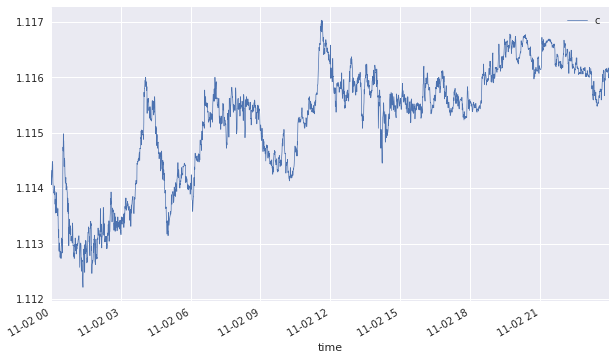

In [6]:
data.plot(figsize=(10,6),lw=0.7); # plotting the sample data

## Basic Concepts on Stationarity

We can classify random processes based on many different criteria. One of the important classifications we can make about a random process is whether it is a stationary process.


A random process is stationary if its statistical properties do not change by time. In particular, its long-run "mean" and "variance" stay constant. This property is fundamental when applying linear regression and forecasting models. 

Such that;

Mean of a time series $$x_t  is E(x_t)=\mu(t)$$

Variance of a time series $$x_t is \sigma^2(t)=E[(x_t - \mu(t))^2]$$

A time series is stationary in the mean if $$\mu(t)=\mu$$, i.e.mean is constant with time

A time series is stationary in the variance if $$\sigma^2(t)=\sigma^2$$, i.e. variance is constant with time

Stationary time series are easy to predict because we can assume that future statistical properties would likely be the same or proportional to the current statistical beheviour. 

If the series is non-stationary; it is difficult to forecast the future movements as the data varies extremely from the mean of the distribution. 

## Testing for Stationarity and Unit Root

To check for stationarity, augmented Dickey-Fuller (ADF) test is applied. This is a robust method to confirm statistically whether the series is stationary or not.

### Augmented Dickey - Fuller (ADF) Unit Root Test

The Augmented Dickey-Fuller test is used for determining whether a single time series process has a unit root, and thus is non-stationary. Unit root test determines how strongly a time series is defines by a trend. There are a number of unit root tests and ADF is one of the widely used one. ADF uses an autoregressive model (AR) and optimizes an information criterion across multiple different lag values.

For example, a simple AR model is:

$$
Y_t = \beta Y_{t-1} + \epsilon_t
$$


If $\beta=1$ the series is said to have a 'unit root' and is hence non-stationary. The equation can be rewriten as:

$$
\Delta Y_t = (\beta - 1) Y_{t-1} + \epsilon_t = \phi Y_{t-1} + \epsilon_t
$$

where $\phi= \beta-1$. Hence, testing for unit root is equivalent to testing $\phi=0$.
The value of the test statistic $\hat{\phi}/std.err(\hat{\phi})$ is then compared to the relevant critical values for the Dickey-Fuller distribution. If found lower, then the null hypothesis $\phi=0$ is rejected and the series can be considered stationary.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is NOT stationary, meaning has some time-dependent structure. The alternate hypothesis (i.e. rejecting the null hypothesis), is that the time series is stationary. 

Null Hypothesis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We can also interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we accept the null hypothesis (non-stationary).

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

As a result, if the process is stationary then autoregression applies, otherwise cointegration analysis should be the preffered method.

In [7]:
ts.adfuller(data['c'], 1)

(-2.6056808708947821,
 0.09182882208553711,
 1,
 2862,
 {'1%': -3.4326369234195746,
  '10%': -2.5673078691409787,
  '5%': -2.8625504068040923},
 -44268.800010750798)

The first value is the calculated test-statistic, while the second value is the p-value. The fourth is the number of data points in the sample. The fifth value, the dictionary, contains the critical values of the test-statistic at the 1, 5 and 10 percent values respectively.

Test-statistic value is negative meaning time series is not trending. We can argue this is a good currency pair to test. 

The P value is 0.09 and higher than 0.05, although this indicates time series has a unit root and non-stationary. We have tested several pairs whose P values were around 0.50 - 0.90. Therefore we choose to ignore and continue with the pair.

The calculated value of the test statistic is larger than 1 and 5 percent of the critical levels but smaller than 10 percent level of the critical value, this means we can reject the null hypothesis with 90% confidence that the time series has a unit root. This means does not have a unit root. Thus, according to our ADF test we are likely to have found a mean reverting time series.

A time series (or stochastic process) is defined to be strongly stationary if its joint probability distribution is invariant under translations in time or space. In particular, key importance, the mean and variance of the process do not change over time or space and they each do not follow a trend.

A critical feature of stationary price series is that the prices within the series diffuse from their initial value at a rate slower than that of a geometric brownian motion. By measuring the rate of this diffusive behaviour we can identify the nature of the time series.

Namely the Hurst Exponent, is another test which helps us to characterise the stationarity of a time series.

### Hurst Exponent

Another way of looking at stationarity and mean reversion is from the perspective of the speed of diffusion from an initial state. A stationary series would diffuse at a slower rate than a geometric random walk. We can measure the speed of diffusion as the variance of the series:

$$Var(τ) = 〈|z(t + τ) − z(t)|^2〉$$

where

z = log(price)
$τ$ is an arbitrary time lag
〈…〉 is an average over all t’s

For a geometric random walk:

$$〈|z(t + τ) − z(t)|^2〉 ∼ τ$$

Where H is the Hurst exponent, H serves as an indicator of the degree to which a series trends.

The goal of the Hurst Exponent is to provide us with a scalar value that will help us to identify (within the limits of statistical estimation) whether a series is mean reverting, random walking or trending.


The Hurst exponent is used as a measure of long-term memory of time series. It relates to the autocorrelations of the time series, and the rate at which these decrease as the lag between pairs of values increases. The Hurst exponent is referred to as the "index of dependence" or "index of long-range dependence". It quantifies the relative tendency of a time series either to regress strongly to the mean or to cluster in a direction.

A value H in the range 0.5–1 indicates a time series with long-term positive autocorrelation, meaning both that a high value in the series will probably be followed by another high value and that the values a long time into the future will also tend to be high.

A value in the range 0 – 0.5 indicates a time series with long-term switching between high and low values in adjacent pairs, meaning that a single high value will probably be followed by a low value and that the value after that will tend to be high, with this tendency to switch between high and low values lasting a long time into the future.

A value of H=0.5 can indicate a completely uncorrelated series, but in fact it is the value applicable to series for which the autocorrelations at small time lags can be positive or negative but where the absolute values of the autocorrelations decay exponentially quickly to zero. This in contrast to the typically power law decay for the 0.5 < H < 1 and 0 < H < 0.5 cases.

In [8]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 250)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [9]:
print(hurst(data))

[ 0.36615601]


Hurst value with 250 lags give 0.36, this is clearly inline with our ADF test. However, for some different time series of the same underlying currency pair we had an ADF result which signals a non-stationarity, but when we adjusted the lag size we had a meaningfull Hurst data. Sometimes, higher lag sizes pushes the exponent near to 0.00 and sometimes smaller lag sizes (ex. 10-20) takes the exponent just above 0.50. 

Therefore, we can draw a significant conclusion from these results: that the lags used to calculate Hurst have a much greater impact on the calculation than the particular segment of the time series analysed.

Further, when we look at the entire time series, we see that our spread is moderately mean-reverting for both small and high lags. Lags close to 20 are least mean reverting, and then H decreases as we increase the lags used in its calculation. If we continue to increase the lags used to calculate H up to the range 150-250, we find that H indicates a more mean reverting time series.

The Hurst Exponent is under 0.5 value of a random walk and we could therefore conclude that the series is mean reverting, but with this analysis we have a number 0.36 which backs up our conclusion based on the Augmented Dickey Fuller test previously. This means that the spread series does look like a candidate for a mean reversion strategy.
However just because a time series displays mean reverting properties, it doesn’t necessarily mean that we can trade it profitably either – there’s a difference between a series that deviates and mean reverts every week and one that takes 10 years to mean revert. Therefore if this spread's mean reversion takes too much time that will keep us in the position for too long.
To get an idea of how long each mean reversion is going to take, we can look into the “half-life” of the time series.
We can calculate this by running a linear regression between the spread series and a lagged version of itself. The Beta coefficient produced by this regression can then be incorporated into the Ornstein-Uhlenbeck process to calculate the half-life.

Below code runs an Ordinary Least Squares regression on the spread series and a lagged version of the spread series in order to use the coefficient to calculate the half-life of mean reversion.

### Halflife of a Mean Reversion

Mean reversion is one of the key trading concepts in Algorithmic Trading. This process refers to a time series that displays a tendency to revert to its historical mean value. Mathematically, such a (continuous) time series is referred to as an Ornstein-Uhlenbeck process. This is in contrast to a random walk (Brownian motion), which has no "memory" of where it has been at each particular instance of time. The mean-reverting property of a time series can be exploited in order to produce profitable trading strategies.

A continuous mean-reverting time series can be represented by an Ornstein-Uhlenbeck stochastic differential equation:

$$
dxt=θ(μ−xt)dt+σdWt
$$


Where θ is the rate of reversion to the mean, μ is the mean value of the process, σ is the variance of the process and Wt is a Wiener Process or Brownian Motion.

In a discrete setting the equation states that the change of the price series in the next time period is proportional to the difference between the mean price and the current price, with the addition of Gaussian noise.

In [10]:
spread_lag = data.shift(1) # creating a lag version
spread_lag.iloc[0] = spread_lag.iloc[1]
spread_ret = data - spread_lag
spread_ret.iloc[0] = spread_ret.iloc[1]
spread_lag2 = sm.add_constant(spread_lag)
 
model = sm.OLS(spread_ret,spread_lag2)
res = model.fit()
 
halflife = round(-np.log(2) / res.params[1],0)
 
if halflife <= 0:
    halflife = 1
print  (halflife)

138.0


We have a meaningfull and significantly low halflife of mean reversion number. This significantly backs our ADF and Hurst analysis. However, for some different time series, (12-13 November 2017, same granularity) gives us 12.0 halflife, but fails to back our ADF analysis. Therefore, we prefered to use 138 since all of statistical criterias have been satisfied.  

In [11]:
#res.summary()

## Strategy Backtesting

In [12]:
data = oanda.get_history('AUD_NZD',start='2017-11-2', end='2017-11-3',granularity='S30',price='A')['c']

In [13]:
data = pd.DataFrame(data)

In [14]:
data.rename(columns={'c': 'price'}, inplace=True)

In [15]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))

In [16]:
SMA = 138 # using half-life of mean reversion as SMA value

In [17]:
data['SMA'] = data['price'].rolling(SMA).mean()

In [18]:
data['distance'] = data['price'] - data['SMA']

In [19]:
data['distance'].std() # this gives our treshold value

0.00046371296443729356

In [20]:
threshold = 0.00046371296443729356

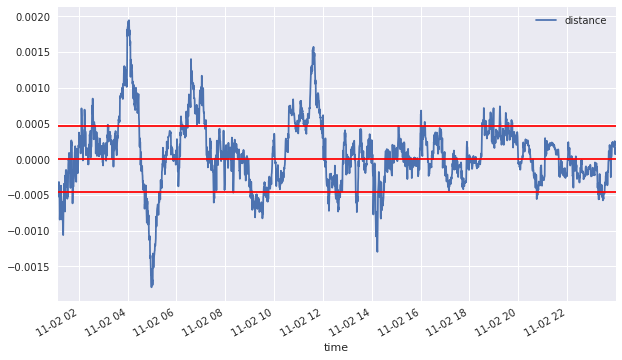

In [21]:
data['distance'].dropna().plot(figsize=(10, 6), legend=True)  
plt.axhline(threshold, color='r')
plt.axhline(-threshold, color='r')
plt.axhline(0, color='r');

In [22]:
data['position'] = np.where(data['distance'] > threshold,-1, np.nan)

In [23]:
data['position'] = np.where(data['distance'] < -threshold,1, data['position'])

In [24]:
data['position'] = np.where(data['distance'] *data['distance'].shift(1) < 0, 0, data['position'])

In [25]:
data['position'] = data['position'].ffill().fillna(0)

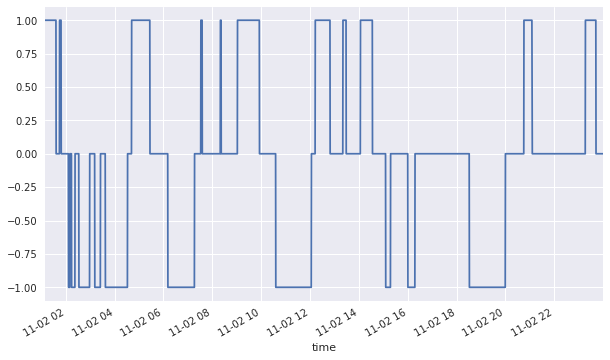

In [26]:
data['position'].iloc[SMA:].plot(figsize=(10, 6)); # visualizing the positions (1=long, -1=short)

In [27]:
data['strategy'] = data['position'].shift(1) * data['returns']

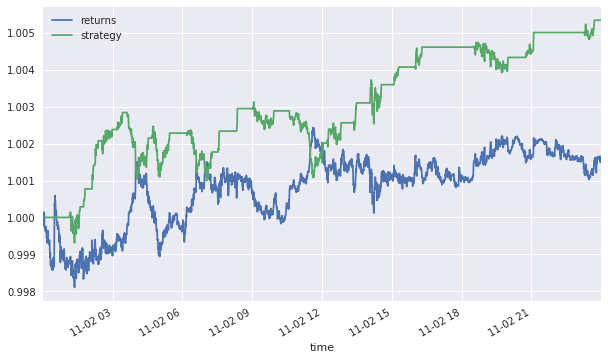

In [28]:
data[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6)); # performance visualized

### Backtesting Class

In [29]:
class BacktestBase(object):
    def __init__(self, symbol, start, end, granularity, amount, ftc=0.0, ptc=0.0):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.granularity = granularity
        self._amount = amount  
        self.amount = amount  
        self.ftc = ftc  
        self.ptc = ptc  
        self.units = 0  
        self.position = 0  
        self.trades = 0  
        self.verbose = True  
        self.get_data()
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = oanda.get_history(self.symbol,start=self.start,
                                end=self.end, granularity=self.granularity, price='A')['c']
        raw = pd.DataFrame(raw)
        raw.rename(columns={'c': 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        self.data = raw.dropna()
        
    def plot_data(self):
        ''' Plots the (adjusted) closing prices for symbol.
        '''
        self.data['price'].plot(figsize=(10, 6), title=self.symbol)

    def print_balance(self, date=''):
        ''' Print out current cash balance info.
        '''
        print('%s | current cash balance %8d' % (date[:10], self.amount))

    def get_date_price(self, bar):
        ''' Return date and price for bar.
        '''
        date = str(self.data.index[bar])
        price = self.data.price.ix[bar]
        return date, price

    def place_buy_order(self, bar, units=None, amount=None):
        ''' Place a buy order.
        '''
        date, price = self.get_date_price(bar)  
        if units is None:  
            units = math.floor(amount / price)  
        self.amount -= (units * price) * (1 + self.ptc) + self.ftc  
        self.units += units  
        self.trades += 1  
        if self.verbose:  
            print('%s | buying  %4d units at %7.2f' %
                  (date[:10], units, price))  
            self.print_balance(date)  

    def place_sell_order(self, bar, units=None, amount=None):
        ''' Place a sell order.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = math.floor(amount / price)
        self.amount += (units * price) * (1 - self.ptc) - self.ftc  
        self.units -= units  
        self.trades += 1
        if self.verbose:
            print('%s | selling %4d units at %7.2f' %
                  (date[:10], units, price))
            self.print_balance(date)
            
    def close_out(self, bar):
        ''' Closing out a long or short position.
        '''
        date, price = self.get_date_price(bar)
        self.amount += self.units * price  
        if self.verbose:
            print('%s | inventory %d units at %.2f' % (date[:10],
                                                       self.units, price))
        if self.verbose:
            print('=' * 55)
        print('Final balance   [$] %13.2f' % self.amount)  
        print('Net Performance [%%] %13.2f' % ((self.amount - self._amount) /
                                               self._amount * 100))  
        print('=' * 55)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2863 entries, 2017-11-02 00:00:30 to 2017-11-02 23:59:30
Data columns (total 2 columns):
price     2863 non-null float64
return    2863 non-null float64
dtypes: float64(2)
memory usage: 67.1 KB
None
                       price    return
time                                  
2017-11-02 23:57:30  1.11616 -0.000009
2017-11-02 23:58:00  1.11599 -0.000152
2017-11-02 23:58:30  1.11605  0.000054
2017-11-02 23:59:00  1.11599 -0.000054
2017-11-02 23:59:30  1.11607  0.000072


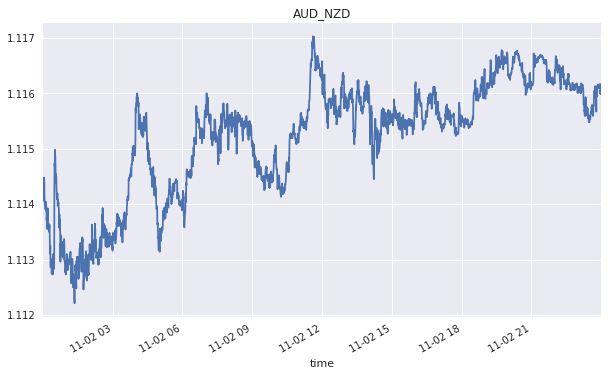

In [30]:
if __name__ == '__main__':
    bb = BacktestBase('AUD_NZD', '2017-11-2', '2017-11-3', 'S30', 10)
    print(bb.data.info())
    print(bb.data.tail())
    bb.plot_data()

In [31]:
class Backtest(BacktestBase):

    def run_mean_reversion_strategy(self, SMA, threshold):
        ''' Backtesting a mean reversion-based strategy.

        Parameters
        ==========
        SMA: int
            simple moving average in days
        threshold: float
            absolute value for deviation-based signal relative to SMA
        '''
        msg = '\n\nRunning mean reversion strategy | SMA %d & thr %d' \
            % (SMA, threshold)
        msg += '\nfixed costs %.2f | ' % self.ftc
        msg += 'proportional costs %.4f' % self.ptc
        print(msg)
        print('=' * 55)
        self.position = 0
        self.amount = self._amount

        self.data['SMA'] = self.data['price'].rolling(SMA).mean()

        for bar in range(len(self.data)):
            if bar >= SMA:
                if self.position == 0:
                    if (self.data['price'].ix[bar] <
                            self.data['SMA'].ix[bar] - threshold):
                        self.place_buy_order(bar, amount=self.amount)
                        self.position = 1
                elif self.position == 1:
                    if self.data['price'].ix[bar] >= self.data['SMA'].ix[bar]:
                        self.place_sell_order(bar, units=self.units)
                        self.position = 0
        self.close_out(bar)

We backtested our mean reversion trading logic both without transaction costs and with transaction costs.

In [32]:
if __name__ == '__main__':
    def run_strategies():
        lobt.run_mean_reversion_strategy(12, 0.00023714535)
    lobt = Backtest('AUD_NZD', '2017-11-12', '2017-11-13', 'S30', 10000)
    lobt.verbose = True
    run_strategies()
    lobt = Backtest('AUD_NZD', '2017-11-12', '2017-11-13', 'S30', 
                            10000, 10.0, 0.005)  # transaction costs 10 USD fix, 0.5% variable
    lobt.verbose = False
    run_strategies()



Running mean reversion strategy | SMA 12 & thr 0
fixed costs 0.00 | proportional costs 0.0000
2017-11-12 | buying  9042 units at    1.11
2017-11-12 | current cash balance        0
2017-11-12 | selling 9042 units at    1.11
2017-11-12 | current cash balance    10002
2017-11-12 | buying  9048 units at    1.11
2017-11-12 | current cash balance        0
2017-11-12 | selling 9048 units at    1.11
2017-11-12 | current cash balance    10006
2017-11-12 | buying  9055 units at    1.11
2017-11-12 | current cash balance        0
2017-11-12 | selling 9055 units at    1.11
2017-11-12 | current cash balance    10011
2017-11-12 | buying  9052 units at    1.11
2017-11-12 | current cash balance        1
2017-11-12 | selling 9052 units at    1.11
2017-11-12 | current cash balance    10004
2017-11-12 | buying  9057 units at    1.10
2017-11-12 | current cash balance        0
2017-11-12 | selling 9057 units at    1.11
2017-11-12 | current cash balance    10009
2017-11-12 | buying  9059 units at    1.10
2

## Implementing Automated Trading Strategy

In [33]:
class MEANtrader(tpqoa):
    def __init__(self, conf_file,instrument, units, SMA, treshold):
        tpqoa.__init__(self, conf_file)
        self.ticks = 0
        self.position = 0
        self.data = pd.DataFrame()
        self.SMA = SMA
        self.treshold = treshold
        self.units = units
        self.instrument = instrument
        
    def on_success(self, time, bid, ask):
        self.ticks += 0
        
        print('%3d | ' % self.ticks, time, bid, ask)
        
        self.data = self.data.append(pd.DataFrame({'bid': bid, 'ask':ask,
                                                   'mid': (bid + ask) / 2},
                                                  index=[pd.Timestamp(time)]))
        
        # resampling the tick data into 5 second intervals to get the exact time slices out of the raw data
        self.resam = self.data.resample('5s', label='right').last().ffill()
        
        self.resam['SMA'] = self.resam['mid'].rolling(self.SMA).mean()   
        
        #defining the mean reversion parameter 'distance' and 'treshold'
        self.resam['distance'] = self.resam['mid'] - self.resam['SMA']
    
        
        #sell signal
        self.resam['position'] = np.where(self.resam['distance'] > self.treshold ,-1,np.nan)
        
        # buy signal
        self.resam['position'] = np.where(self.resam['distance'] < -self.treshold ,1,self.resam['position'])
        
        
        # crossing of current price and SMA (zero distance)
        #self.resam['position'] = np.where(self.resam['distance'] * 
                                          #self.resam['distance'].shift(1) < 0, 0, self.resam['position'])
        self.resam['position'] = self.resam['position'].ffill().fillna(0)
          
        print(self.resam[['bid', 'ask', 'SMA', 'distance','position']].tail())
        
        
        if self.resam['position'].ix[-1] == 1:
            if self.position == 0:
                self.create_order(instrument=self.instrument, units=self.units)
            elif self.position == -1:
                self.create_order(instrument=self.instrument, units=self.units * 2)
                self.position = 1
        elif self.resam['position'].ix[-1] == -1:
            if self.position == 0:
                self.create_order(instrument=self.instrument, units=-self.units)
            elif self.position == 1:
                self.create_order(instrument=self.instrument, units=-self.units * 2)
                self.position = -1

In [34]:
mean = MEANtrader('algotrader.pyg', 'AUD_NZD', 1000,138,0.00023714535)

In [35]:
mean.stream_data('AUD_NZD')

  1 |  2017-11-28T11:05:23.833660214Z 1.09657 1.09687
                               bid      ask  SMA  distance  position
2017-11-28 11:05:25+00:00  1.09657  1.09687  NaN       NaN       0.0
  2 |  2017-11-28T11:05:28.497971759Z 1.09656 1.09689
                               bid      ask  SMA  distance  position
2017-11-28 11:05:25+00:00  1.09657  1.09687  NaN       NaN       0.0
2017-11-28 11:05:30+00:00  1.09656  1.09689  NaN       NaN       0.0
  3 |  2017-11-28T11:05:29.647449038Z 1.09657 1.09689
                               bid      ask  SMA  distance  position
2017-11-28 11:05:25+00:00  1.09657  1.09687  NaN       NaN       0.0
2017-11-28 11:05:30+00:00  1.09657  1.09689  NaN       NaN       0.0
  4 |  2017-11-28T11:05:30.841264663Z 1.09656 1.09688
                               bid      ask  SMA  distance  position
2017-11-28 11:05:25+00:00  1.09657  1.09687  NaN       NaN       0.0
2017-11-28 11:05:30+00:00  1.09657  1.09689  NaN       NaN       0.0
2017-11-28 11:05:35+00:00

 22 |  2017-11-28T11:06:23.524375893Z 1.09667 1.09701
                               bid      ask  SMA  distance  position
2017-11-28 11:06:05+00:00  1.09657  1.09691  NaN       NaN       0.0
2017-11-28 11:06:10+00:00  1.09657  1.09692  NaN       NaN       0.0
2017-11-28 11:06:15+00:00  1.09659  1.09694  NaN       NaN       0.0
2017-11-28 11:06:20+00:00  1.09657  1.09694  NaN       NaN       0.0
2017-11-28 11:06:25+00:00  1.09667  1.09701  NaN       NaN       0.0
 23 |  2017-11-28T11:06:23.709160934Z 1.09667 1.09702
                               bid      ask  SMA  distance  position
2017-11-28 11:06:05+00:00  1.09657  1.09691  NaN       NaN       0.0
2017-11-28 11:06:10+00:00  1.09657  1.09692  NaN       NaN       0.0
2017-11-28 11:06:15+00:00  1.09659  1.09694  NaN       NaN       0.0
2017-11-28 11:06:20+00:00  1.09657  1.09694  NaN       NaN       0.0
2017-11-28 11:06:25+00:00  1.09667  1.09702  NaN       NaN       0.0
 24 |  2017-11-28T11:06:24.018423881Z 1.09665 1.09703
          

 40 |  2017-11-28T11:06:53.731522424Z 1.09673 1.09706
                               bid      ask  SMA  distance  position
2017-11-28 11:06:35+00:00  1.09668  1.09702  NaN       NaN       0.0
2017-11-28 11:06:40+00:00  1.09668  1.09702  NaN       NaN       0.0
2017-11-28 11:06:45+00:00  1.09668  1.09706  NaN       NaN       0.0
2017-11-28 11:06:50+00:00  1.09670  1.09706  NaN       NaN       0.0
2017-11-28 11:06:55+00:00  1.09673  1.09706  NaN       NaN       0.0
 41 |  2017-11-28T11:06:55.516153352Z 1.09673 1.09707
                               bid      ask  SMA  distance  position
2017-11-28 11:06:40+00:00  1.09668  1.09702  NaN       NaN       0.0
2017-11-28 11:06:45+00:00  1.09668  1.09706  NaN       NaN       0.0
2017-11-28 11:06:50+00:00  1.09670  1.09706  NaN       NaN       0.0
2017-11-28 11:06:55+00:00  1.09673  1.09706  NaN       NaN       0.0
2017-11-28 11:07:00+00:00  1.09673  1.09707  NaN       NaN       0.0
 42 |  2017-11-28T11:06:58.097124763Z 1.09674 1.09707
          

 58 |  2017-11-28T11:07:39.906771178Z 1.0968 1.09715
                               bid      ask  SMA  distance  position
2017-11-28 11:07:20+00:00  1.09676  1.09707  NaN       NaN       0.0
2017-11-28 11:07:25+00:00  1.09676  1.09707  NaN       NaN       0.0
2017-11-28 11:07:30+00:00  1.09676  1.09707  NaN       NaN       0.0
2017-11-28 11:07:35+00:00  1.09677  1.09710  NaN       NaN       0.0
2017-11-28 11:07:40+00:00  1.09680  1.09715  NaN       NaN       0.0
 59 |  2017-11-28T11:07:40.577153772Z 1.0968 1.09714
                               bid      ask  SMA  distance  position
2017-11-28 11:07:25+00:00  1.09676  1.09707  NaN       NaN       0.0
2017-11-28 11:07:30+00:00  1.09676  1.09707  NaN       NaN       0.0
2017-11-28 11:07:35+00:00  1.09677  1.09710  NaN       NaN       0.0
2017-11-28 11:07:40+00:00  1.09680  1.09715  NaN       NaN       0.0
2017-11-28 11:07:45+00:00  1.09680  1.09714  NaN       NaN       0.0
 60 |  2017-11-28T11:07:41.110226898Z 1.0968 1.09715
             

 76 |  2017-11-28T11:07:54.554469174Z 1.09678 1.09711
                               bid      ask  SMA  distance  position
2017-11-28 11:07:35+00:00  1.09677  1.09710  NaN       NaN       0.0
2017-11-28 11:07:40+00:00  1.09680  1.09715  NaN       NaN       0.0
2017-11-28 11:07:45+00:00  1.09679  1.09714  NaN       NaN       0.0
2017-11-28 11:07:50+00:00  1.09671  1.09706  NaN       NaN       0.0
2017-11-28 11:07:55+00:00  1.09678  1.09711  NaN       NaN       0.0
 77 |  2017-11-28T11:07:55.552745529Z 1.09686 1.09719
                               bid      ask  SMA  distance  position
2017-11-28 11:07:40+00:00  1.09680  1.09715  NaN       NaN       0.0
2017-11-28 11:07:45+00:00  1.09679  1.09714  NaN       NaN       0.0
2017-11-28 11:07:50+00:00  1.09671  1.09706  NaN       NaN       0.0
2017-11-28 11:07:55+00:00  1.09678  1.09711  NaN       NaN       0.0
2017-11-28 11:08:00+00:00  1.09686  1.09719  NaN       NaN       0.0
 78 |  2017-11-28T11:07:56.048035283Z 1.09686 1.09719
          

 94 |  2017-11-28T11:08:34.024732413Z 1.0969 1.09723
                               bid      ask  SMA  distance  position
2017-11-28 11:08:15+00:00  1.09687  1.09721  NaN       NaN       0.0
2017-11-28 11:08:20+00:00  1.09688  1.09722  NaN       NaN       0.0
2017-11-28 11:08:25+00:00  1.09688  1.09722  NaN       NaN       0.0
2017-11-28 11:08:30+00:00  1.09688  1.09722  NaN       NaN       0.0
2017-11-28 11:08:35+00:00  1.09690  1.09723  NaN       NaN       0.0
 95 |  2017-11-28T11:08:34.128346060Z 1.09692 1.09722
                               bid      ask  SMA  distance  position
2017-11-28 11:08:15+00:00  1.09687  1.09721  NaN       NaN       0.0
2017-11-28 11:08:20+00:00  1.09688  1.09722  NaN       NaN       0.0
2017-11-28 11:08:25+00:00  1.09688  1.09722  NaN       NaN       0.0
2017-11-28 11:08:30+00:00  1.09688  1.09722  NaN       NaN       0.0
2017-11-28 11:08:35+00:00  1.09692  1.09722  NaN       NaN       0.0
 96 |  2017-11-28T11:08:34.488852306Z 1.09693 1.09721
           

112 |  2017-11-28T11:09:29.511285063Z 1.0968 1.09716
                               bid      ask  SMA  distance  position
2017-11-28 11:09:10+00:00  1.09685  1.09717  NaN       NaN       0.0
2017-11-28 11:09:15+00:00  1.09685  1.09718  NaN       NaN       0.0
2017-11-28 11:09:20+00:00  1.09685  1.09717  NaN       NaN       0.0
2017-11-28 11:09:25+00:00  1.09685  1.09717  NaN       NaN       0.0
2017-11-28 11:09:30+00:00  1.09680  1.09716  NaN       NaN       0.0
113 |  2017-11-28T11:09:29.711800231Z 1.09681 1.09715
                               bid      ask  SMA  distance  position
2017-11-28 11:09:10+00:00  1.09685  1.09717  NaN       NaN       0.0
2017-11-28 11:09:15+00:00  1.09685  1.09718  NaN       NaN       0.0
2017-11-28 11:09:20+00:00  1.09685  1.09717  NaN       NaN       0.0
2017-11-28 11:09:25+00:00  1.09685  1.09717  NaN       NaN       0.0
2017-11-28 11:09:30+00:00  1.09681  1.09715  NaN       NaN       0.0
114 |  2017-11-28T11:09:29.968761640Z 1.09679 1.09714
           

130 |  2017-11-28T11:09:49.467001371Z 1.09689 1.09719
                               bid      ask  SMA  distance  position
2017-11-28 11:09:30+00:00  1.09679  1.09714  NaN       NaN       0.0
2017-11-28 11:09:35+00:00  1.09676  1.09710  NaN       NaN       0.0
2017-11-28 11:09:40+00:00  1.09683  1.09716  NaN       NaN       0.0
2017-11-28 11:09:45+00:00  1.09683  1.09715  NaN       NaN       0.0
2017-11-28 11:09:50+00:00  1.09689  1.09719  NaN       NaN       0.0
131 |  2017-11-28T11:09:56.695742723Z 1.0969 1.09718
                               bid      ask  SMA  distance  position
2017-11-28 11:09:40+00:00  1.09683  1.09716  NaN       NaN       0.0
2017-11-28 11:09:45+00:00  1.09683  1.09715  NaN       NaN       0.0
2017-11-28 11:09:50+00:00  1.09689  1.09719  NaN       NaN       0.0
2017-11-28 11:09:55+00:00  1.09689  1.09719  NaN       NaN       0.0
2017-11-28 11:10:00+00:00  1.09690  1.09718  NaN       NaN       0.0
132 |  2017-11-28T11:09:58.492359796Z 1.09689 1.09719
           

148 |  2017-11-28T11:10:14.533403973Z 1.09697 1.09735
                               bid      ask  SMA  distance  position
2017-11-28 11:09:55+00:00  1.09689  1.09719  NaN       NaN       0.0
2017-11-28 11:10:00+00:00  1.09689  1.09719  NaN       NaN       0.0
2017-11-28 11:10:05+00:00  1.09689  1.09719  NaN       NaN       0.0
2017-11-28 11:10:10+00:00  1.09690  1.09723  NaN       NaN       0.0
2017-11-28 11:10:15+00:00  1.09697  1.09735  NaN       NaN       0.0
149 |  2017-11-28T11:10:15.533749584Z 1.09699 1.09735
                               bid      ask  SMA  distance  position
2017-11-28 11:10:00+00:00  1.09689  1.09719  NaN       NaN       0.0
2017-11-28 11:10:05+00:00  1.09689  1.09719  NaN       NaN       0.0
2017-11-28 11:10:10+00:00  1.09690  1.09723  NaN       NaN       0.0
2017-11-28 11:10:15+00:00  1.09697  1.09735  NaN       NaN       0.0
2017-11-28 11:10:20+00:00  1.09699  1.09735  NaN       NaN       0.0
150 |  2017-11-28T11:10:16.424090874Z 1.09698 1.09735
          

166 |  2017-11-28T11:10:26.574368767Z 1.097 1.09739
                               bid      ask  SMA  distance  position
2017-11-28 11:10:10+00:00  1.09690  1.09723  NaN       NaN       0.0
2017-11-28 11:10:15+00:00  1.09697  1.09735  NaN       NaN       0.0
2017-11-28 11:10:20+00:00  1.09701  1.09739  NaN       NaN       0.0
2017-11-28 11:10:25+00:00  1.09702  1.09739  NaN       NaN       0.0
2017-11-28 11:10:30+00:00  1.09700  1.09739  NaN       NaN       0.0
167 |  2017-11-28T11:10:27.290027440Z 1.09705 1.09734
                               bid      ask  SMA  distance  position
2017-11-28 11:10:10+00:00  1.09690  1.09723  NaN       NaN       0.0
2017-11-28 11:10:15+00:00  1.09697  1.09735  NaN       NaN       0.0
2017-11-28 11:10:20+00:00  1.09701  1.09739  NaN       NaN       0.0
2017-11-28 11:10:25+00:00  1.09702  1.09739  NaN       NaN       0.0
2017-11-28 11:10:30+00:00  1.09705  1.09734  NaN       NaN       0.0
168 |  2017-11-28T11:10:27.509801039Z 1.09707 1.09742
            

184 |  2017-11-28T11:10:44.506948604Z 1.09715 1.09748
                               bid      ask  SMA  distance  position
2017-11-28 11:10:25+00:00  1.09702  1.09739  NaN       NaN       0.0
2017-11-28 11:10:30+00:00  1.09710  1.09742  NaN       NaN       0.0
2017-11-28 11:10:35+00:00  1.09715  1.09747  NaN       NaN       0.0
2017-11-28 11:10:40+00:00  1.09716  1.09746  NaN       NaN       0.0
2017-11-28 11:10:45+00:00  1.09715  1.09748  NaN       NaN       0.0
185 |  2017-11-28T11:10:44.881219492Z 1.09716 1.09744
                               bid      ask  SMA  distance  position
2017-11-28 11:10:25+00:00  1.09702  1.09739  NaN       NaN       0.0
2017-11-28 11:10:30+00:00  1.09710  1.09742  NaN       NaN       0.0
2017-11-28 11:10:35+00:00  1.09715  1.09747  NaN       NaN       0.0
2017-11-28 11:10:40+00:00  1.09716  1.09746  NaN       NaN       0.0
2017-11-28 11:10:45+00:00  1.09716  1.09744  NaN       NaN       0.0
186 |  2017-11-28T11:10:45.053735721Z 1.09715 1.09746
          

202 |  2017-11-28T11:10:59.672784618Z 1.09707 1.09741
                               bid      ask  SMA  distance  position
2017-11-28 11:10:40+00:00  1.09716  1.09746  NaN       NaN       0.0
2017-11-28 11:10:45+00:00  1.09716  1.09744  NaN       NaN       0.0
2017-11-28 11:10:50+00:00  1.09713  1.09745  NaN       NaN       0.0
2017-11-28 11:10:55+00:00  1.09712  1.09745  NaN       NaN       0.0
2017-11-28 11:11:00+00:00  1.09707  1.09741  NaN       NaN       0.0
203 |  2017-11-28T11:10:59.879651793Z 1.09706 1.09741
                               bid      ask  SMA  distance  position
2017-11-28 11:10:40+00:00  1.09716  1.09746  NaN       NaN       0.0
2017-11-28 11:10:45+00:00  1.09716  1.09744  NaN       NaN       0.0
2017-11-28 11:10:50+00:00  1.09713  1.09745  NaN       NaN       0.0
2017-11-28 11:10:55+00:00  1.09712  1.09745  NaN       NaN       0.0
2017-11-28 11:11:00+00:00  1.09706  1.09741  NaN       NaN       0.0
204 |  2017-11-28T11:11:00.191274212Z 1.09705 1.09738
          

220 |  2017-11-28T11:11:26.634232021Z 1.09702 1.09736
                               bid      ask  SMA  distance  position
2017-11-28 11:11:10+00:00  1.09704  1.09735  NaN       NaN       0.0
2017-11-28 11:11:15+00:00  1.09703  1.09734  NaN       NaN       0.0
2017-11-28 11:11:20+00:00  1.09705  1.09734  NaN       NaN       0.0
2017-11-28 11:11:25+00:00  1.09704  1.09735  NaN       NaN       0.0
2017-11-28 11:11:30+00:00  1.09702  1.09736  NaN       NaN       0.0
221 |  2017-11-28T11:11:26.883754881Z 1.09703 1.09735
                               bid      ask  SMA  distance  position
2017-11-28 11:11:10+00:00  1.09704  1.09735  NaN       NaN       0.0
2017-11-28 11:11:15+00:00  1.09703  1.09734  NaN       NaN       0.0
2017-11-28 11:11:20+00:00  1.09705  1.09734  NaN       NaN       0.0
2017-11-28 11:11:25+00:00  1.09704  1.09735  NaN       NaN       0.0
2017-11-28 11:11:30+00:00  1.09703  1.09735  NaN       NaN       0.0
222 |  2017-11-28T11:11:27.068191337Z 1.09703 1.09734
          

238 |  2017-11-28T11:11:42.533867068Z 1.09701 1.0973
                               bid      ask  SMA  distance  position
2017-11-28 11:11:25+00:00  1.09704  1.09735  NaN       NaN       0.0
2017-11-28 11:11:30+00:00  1.09703  1.09733  NaN       NaN       0.0
2017-11-28 11:11:35+00:00  1.09703  1.09733  NaN       NaN       0.0
2017-11-28 11:11:40+00:00  1.09699  1.09732  NaN       NaN       0.0
2017-11-28 11:11:45+00:00  1.09701  1.09730  NaN       NaN       0.0
239 |  2017-11-28T11:11:43.155266740Z 1.09699 1.09731
                               bid      ask  SMA  distance  position
2017-11-28 11:11:25+00:00  1.09704  1.09735  NaN       NaN       0.0
2017-11-28 11:11:30+00:00  1.09703  1.09733  NaN       NaN       0.0
2017-11-28 11:11:35+00:00  1.09703  1.09733  NaN       NaN       0.0
2017-11-28 11:11:40+00:00  1.09699  1.09732  NaN       NaN       0.0
2017-11-28 11:11:45+00:00  1.09699  1.09731  NaN       NaN       0.0
240 |  2017-11-28T11:11:45.419530965Z 1.09699 1.09729
           

256 |  2017-11-28T11:11:59.455734244Z 1.0971 1.09743
                               bid      ask  SMA  distance  position
2017-11-28 11:11:40+00:00  1.09699  1.09732  NaN       NaN       0.0
2017-11-28 11:11:45+00:00  1.09699  1.09731  NaN       NaN       0.0
2017-11-28 11:11:50+00:00  1.09696  1.09727  NaN       NaN       0.0
2017-11-28 11:11:55+00:00  1.09704  1.09734  NaN       NaN       0.0
2017-11-28 11:12:00+00:00  1.09710  1.09743  NaN       NaN       0.0
257 |  2017-11-28T11:11:59.598655539Z 1.09711 1.09744
                               bid      ask  SMA  distance  position
2017-11-28 11:11:40+00:00  1.09699  1.09732  NaN       NaN       0.0
2017-11-28 11:11:45+00:00  1.09699  1.09731  NaN       NaN       0.0
2017-11-28 11:11:50+00:00  1.09696  1.09727  NaN       NaN       0.0
2017-11-28 11:11:55+00:00  1.09704  1.09734  NaN       NaN       0.0
2017-11-28 11:12:00+00:00  1.09711  1.09744  NaN       NaN       0.0
258 |  2017-11-28T11:11:59.956583899Z 1.09709 1.09744
           

274 |  2017-11-28T11:12:05.497437793Z 1.09711 1.09744
                               bid      ask  SMA  distance  position
2017-11-28 11:11:50+00:00  1.09696  1.09727  NaN       NaN       0.0
2017-11-28 11:11:55+00:00  1.09704  1.09734  NaN       NaN       0.0
2017-11-28 11:12:00+00:00  1.09709  1.09744  NaN       NaN       0.0
2017-11-28 11:12:05+00:00  1.09712  1.09743  NaN       NaN       0.0
2017-11-28 11:12:10+00:00  1.09711  1.09744  NaN       NaN       0.0
275 |  2017-11-28T11:12:05.605776153Z 1.0971 1.09745
                               bid      ask  SMA  distance  position
2017-11-28 11:11:50+00:00  1.09696  1.09727  NaN       NaN       0.0
2017-11-28 11:11:55+00:00  1.09704  1.09734  NaN       NaN       0.0
2017-11-28 11:12:00+00:00  1.09709  1.09744  NaN       NaN       0.0
2017-11-28 11:12:05+00:00  1.09712  1.09743  NaN       NaN       0.0
2017-11-28 11:12:10+00:00  1.09710  1.09745  NaN       NaN       0.0
276 |  2017-11-28T11:12:05.916182016Z 1.09711 1.09744
           

292 |  2017-11-28T11:12:17.227523812Z 1.09711 1.09741
                               bid      ask  SMA  distance  position
2017-11-28 11:12:00+00:00  1.09709  1.09744  NaN       NaN       0.0
2017-11-28 11:12:05+00:00  1.09712  1.09743  NaN       NaN       0.0
2017-11-28 11:12:10+00:00  1.09708  1.09744  NaN       NaN       0.0
2017-11-28 11:12:15+00:00  1.09715  1.09745  NaN       NaN       0.0
2017-11-28 11:12:20+00:00  1.09711  1.09741  NaN       NaN       0.0
293 |  2017-11-28T11:12:17.552326306Z 1.09712 1.09742
                               bid      ask  SMA  distance  position
2017-11-28 11:12:00+00:00  1.09709  1.09744  NaN       NaN       0.0
2017-11-28 11:12:05+00:00  1.09712  1.09743  NaN       NaN       0.0
2017-11-28 11:12:10+00:00  1.09708  1.09744  NaN       NaN       0.0
2017-11-28 11:12:15+00:00  1.09715  1.09745  NaN       NaN       0.0
2017-11-28 11:12:20+00:00  1.09712  1.09742  NaN       NaN       0.0
294 |  2017-11-28T11:12:30.097860645Z 1.09714 1.09744
          

310 |  2017-11-28T11:12:47.857563489Z 1.09714 1.09747
                               bid      ask  SMA  distance  position
2017-11-28 11:12:30+00:00  1.09712  1.09742  NaN       NaN       0.0
2017-11-28 11:12:35+00:00  1.09714  1.09745  NaN       NaN       0.0
2017-11-28 11:12:40+00:00  1.09715  1.09746  NaN       NaN       0.0
2017-11-28 11:12:45+00:00  1.09716  1.09747  NaN       NaN       0.0
2017-11-28 11:12:50+00:00  1.09714  1.09747  NaN       NaN       0.0
311 |  2017-11-28T11:12:54.948499354Z 1.09712 1.09746
                               bid      ask  SMA  distance  position
2017-11-28 11:12:35+00:00  1.09714  1.09745  NaN       NaN       0.0
2017-11-28 11:12:40+00:00  1.09715  1.09746  NaN       NaN       0.0
2017-11-28 11:12:45+00:00  1.09716  1.09747  NaN       NaN       0.0
2017-11-28 11:12:50+00:00  1.09714  1.09747  NaN       NaN       0.0
2017-11-28 11:12:55+00:00  1.09712  1.09746  NaN       NaN       0.0
312 |  2017-11-28T11:12:55.075613032Z 1.09711 1.09746
          

328 |  2017-11-28T11:13:02.284519736Z 1.09708 1.09739
                               bid      ask  SMA  distance  position
2017-11-28 11:12:45+00:00  1.09716  1.09747  NaN       NaN       0.0
2017-11-28 11:12:50+00:00  1.09714  1.09747  NaN       NaN       0.0
2017-11-28 11:12:55+00:00  1.09712  1.09746  NaN       NaN       0.0
2017-11-28 11:13:00+00:00  1.09708  1.09741  NaN       NaN       0.0
2017-11-28 11:13:05+00:00  1.09708  1.09739  NaN       NaN       0.0
329 |  2017-11-28T11:13:03.086134937Z 1.09707 1.09741
                               bid      ask  SMA  distance  position
2017-11-28 11:12:45+00:00  1.09716  1.09747  NaN       NaN       0.0
2017-11-28 11:12:50+00:00  1.09714  1.09747  NaN       NaN       0.0
2017-11-28 11:12:55+00:00  1.09712  1.09746  NaN       NaN       0.0
2017-11-28 11:13:00+00:00  1.09708  1.09741  NaN       NaN       0.0
2017-11-28 11:13:05+00:00  1.09707  1.09741  NaN       NaN       0.0
330 |  2017-11-28T11:13:05.495707423Z 1.09708 1.0974
           

346 |  2017-11-28T11:13:22.173857541Z 1.09705 1.09737
                               bid      ask  SMA  distance  position
2017-11-28 11:13:05+00:00  1.09707  1.09741  NaN       NaN       0.0
2017-11-28 11:13:10+00:00  1.09707  1.09738  NaN       NaN       0.0
2017-11-28 11:13:15+00:00  1.09706  1.09738  NaN       NaN       0.0
2017-11-28 11:13:20+00:00  1.09708  1.09738  NaN       NaN       0.0
2017-11-28 11:13:25+00:00  1.09705  1.09737  NaN       NaN       0.0
347 |  2017-11-28T11:13:22.452512004Z 1.09708 1.09738
                               bid      ask  SMA  distance  position
2017-11-28 11:13:05+00:00  1.09707  1.09741  NaN       NaN       0.0
2017-11-28 11:13:10+00:00  1.09707  1.09738  NaN       NaN       0.0
2017-11-28 11:13:15+00:00  1.09706  1.09738  NaN       NaN       0.0
2017-11-28 11:13:20+00:00  1.09708  1.09738  NaN       NaN       0.0
2017-11-28 11:13:25+00:00  1.09708  1.09738  NaN       NaN       0.0
348 |  2017-11-28T11:13:22.659352657Z 1.09711 1.0974
           

364 |  2017-11-28T11:13:44.033857918Z 1.09715 1.09745
                               bid      ask  SMA  distance  position
2017-11-28 11:13:25+00:00  1.09711  1.09745  NaN       NaN       0.0
2017-11-28 11:13:30+00:00  1.09711  1.09745  NaN       NaN       0.0
2017-11-28 11:13:35+00:00  1.09713  1.09745  NaN       NaN       0.0
2017-11-28 11:13:40+00:00  1.09715  1.09745  NaN       NaN       0.0
2017-11-28 11:13:45+00:00  1.09715  1.09745  NaN       NaN       0.0
365 |  2017-11-28T11:13:44.934499880Z 1.09715 1.09744
                               bid      ask  SMA  distance  position
2017-11-28 11:13:25+00:00  1.09711  1.09745  NaN       NaN       0.0
2017-11-28 11:13:30+00:00  1.09711  1.09745  NaN       NaN       0.0
2017-11-28 11:13:35+00:00  1.09713  1.09745  NaN       NaN       0.0
2017-11-28 11:13:40+00:00  1.09715  1.09745  NaN       NaN       0.0
2017-11-28 11:13:45+00:00  1.09715  1.09744  NaN       NaN       0.0
366 |  2017-11-28T11:13:56.946524944Z 1.09715 1.09745
          

382 |  2017-11-28T11:14:54.072687030Z 1.09725 1.09756
                               bid      ask  SMA  distance  position
2017-11-28 11:14:35+00:00  1.09717  1.09751  NaN       NaN       0.0
2017-11-28 11:14:40+00:00  1.09718  1.09752  NaN       NaN       0.0
2017-11-28 11:14:45+00:00  1.09719  1.09753  NaN       NaN       0.0
2017-11-28 11:14:50+00:00  1.09719  1.09753  NaN       NaN       0.0
2017-11-28 11:14:55+00:00  1.09725  1.09756  NaN       NaN       0.0
383 |  2017-11-28T11:14:54.606515209Z 1.09724 1.09757
                               bid      ask  SMA  distance  position
2017-11-28 11:14:35+00:00  1.09717  1.09751  NaN       NaN       0.0
2017-11-28 11:14:40+00:00  1.09718  1.09752  NaN       NaN       0.0
2017-11-28 11:14:45+00:00  1.09719  1.09753  NaN       NaN       0.0
2017-11-28 11:14:50+00:00  1.09719  1.09753  NaN       NaN       0.0
2017-11-28 11:14:55+00:00  1.09724  1.09757  NaN       NaN       0.0
384 |  2017-11-28T11:14:54.810296371Z 1.09725 1.09757
          

400 |  2017-11-28T11:15:21.790189064Z 1.09732 1.09765
                               bid      ask  SMA  distance  position
2017-11-28 11:15:05+00:00  1.09730  1.09764  NaN       NaN       0.0
2017-11-28 11:15:10+00:00  1.09731  1.09765  NaN       NaN       0.0
2017-11-28 11:15:15+00:00  1.09731  1.09766  NaN       NaN       0.0
2017-11-28 11:15:20+00:00  1.09731  1.09766  NaN       NaN       0.0
2017-11-28 11:15:25+00:00  1.09732  1.09765  NaN       NaN       0.0
401 |  2017-11-28T11:15:22.050141837Z 1.09732 1.09764
                               bid      ask  SMA  distance  position
2017-11-28 11:15:05+00:00  1.09730  1.09764  NaN       NaN       0.0
2017-11-28 11:15:10+00:00  1.09731  1.09765  NaN       NaN       0.0
2017-11-28 11:15:15+00:00  1.09731  1.09766  NaN       NaN       0.0
2017-11-28 11:15:20+00:00  1.09731  1.09766  NaN       NaN       0.0
2017-11-28 11:15:25+00:00  1.09732  1.09764  NaN       NaN       0.0
402 |  2017-11-28T11:15:23.358957157Z 1.09732 1.09767
          

418 |  2017-11-28T11:15:43.299316677Z 1.0973 1.09766
                               bid      ask  SMA  distance  position
2017-11-28 11:15:25+00:00  1.09729  1.09765  NaN       NaN       0.0
2017-11-28 11:15:30+00:00  1.09728  1.09762  NaN       NaN       0.0
2017-11-28 11:15:35+00:00  1.09732  1.09763  NaN       NaN       0.0
2017-11-28 11:15:40+00:00  1.09733  1.09764  NaN       NaN       0.0
2017-11-28 11:15:45+00:00  1.09730  1.09766  NaN       NaN       0.0
419 |  2017-11-28T11:15:47.545354170Z 1.09731 1.09765
                               bid      ask  SMA  distance  position
2017-11-28 11:15:30+00:00  1.09728  1.09762  NaN       NaN       0.0
2017-11-28 11:15:35+00:00  1.09732  1.09763  NaN       NaN       0.0
2017-11-28 11:15:40+00:00  1.09733  1.09764  NaN       NaN       0.0
2017-11-28 11:15:45+00:00  1.09730  1.09766  NaN       NaN       0.0
2017-11-28 11:15:50+00:00  1.09731  1.09765  NaN       NaN       0.0
420 |  2017-11-28T11:15:47.768318538Z 1.09731 1.09763
           

436 |  2017-11-28T11:16:13.104318595Z 1.09731 1.09765
                               bid      ask  SMA  distance  position
2017-11-28 11:15:55+00:00  1.09731  1.09761  NaN       NaN       0.0
2017-11-28 11:16:00+00:00  1.09731  1.09763  NaN       NaN       0.0
2017-11-28 11:16:05+00:00  1.09731  1.09763  NaN       NaN       0.0
2017-11-28 11:16:10+00:00  1.09729  1.09761  NaN       NaN       0.0
2017-11-28 11:16:15+00:00  1.09731  1.09765  NaN       NaN       0.0
437 |  2017-11-28T11:16:14.512824742Z 1.09731 1.09764
                               bid      ask  SMA  distance  position
2017-11-28 11:15:55+00:00  1.09731  1.09761  NaN       NaN       0.0
2017-11-28 11:16:00+00:00  1.09731  1.09763  NaN       NaN       0.0
2017-11-28 11:16:05+00:00  1.09731  1.09763  NaN       NaN       0.0
2017-11-28 11:16:10+00:00  1.09729  1.09761  NaN       NaN       0.0
2017-11-28 11:16:15+00:00  1.09731  1.09764  NaN       NaN       0.0
438 |  2017-11-28T11:16:16.687372636Z 1.0973 1.09765
           

454 |  2017-11-28T11:16:24.250526925Z 1.09745 1.09775
                               bid      ask  SMA  distance  position
2017-11-28 11:16:05+00:00  1.09731  1.09763  NaN       NaN       0.0
2017-11-28 11:16:10+00:00  1.09729  1.09761  NaN       NaN       0.0
2017-11-28 11:16:15+00:00  1.09731  1.09764  NaN       NaN       0.0
2017-11-28 11:16:20+00:00  1.09732  1.09765  NaN       NaN       0.0
2017-11-28 11:16:25+00:00  1.09745  1.09775  NaN       NaN       0.0
455 |  2017-11-28T11:16:25.738363875Z 1.09744 1.09774
                               bid      ask  SMA  distance  position
2017-11-28 11:16:10+00:00  1.09729  1.09761  NaN       NaN       0.0
2017-11-28 11:16:15+00:00  1.09731  1.09764  NaN       NaN       0.0
2017-11-28 11:16:20+00:00  1.09732  1.09765  NaN       NaN       0.0
2017-11-28 11:16:25+00:00  1.09745  1.09775  NaN       NaN       0.0
2017-11-28 11:16:30+00:00  1.09744  1.09774  NaN       NaN       0.0
456 |  2017-11-28T11:16:26.173980138Z 1.09745 1.09775
          

472 |  2017-11-28T11:16:48.398002983Z 1.0976 1.09789
                               bid      ask       SMA  distance  position
2017-11-28 11:16:30+00:00  1.09751  1.09779       NaN       NaN       0.0
2017-11-28 11:16:35+00:00  1.09759  1.09788       NaN       NaN       0.0
2017-11-28 11:16:40+00:00  1.09760  1.09788       NaN       NaN       0.0
2017-11-28 11:16:45+00:00  1.09761  1.09789       NaN       NaN       0.0
2017-11-28 11:16:50+00:00  1.09760  1.09789  1.097169  0.000576      -1.0


 {'id': '31103', 'time': '2017-11-28T11:16:49.038212880Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31102', 'requestID': '42370030221005650', 'type': 'ORDER_FILL', 'orderID': '31102', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0976', 'fullPrice': {'bids': [{'price': '1.0976', 'liquidity': '10000000'}], 'asks': [{'price': '1.09788', 'liquidity': '10000000'}], 'closeoutBid': '1.0976', 'closeoutAsk': '1.09788', 'timestamp': '2017-11-28T11:16:48.645039077Z'}, '

480 |  2017-11-28T11:16:50.433992123Z 1.09758 1.09787
                               bid      ask       SMA  distance  position
2017-11-28 11:16:35+00:00  1.09759  1.09788       NaN       NaN       0.0
2017-11-28 11:16:40+00:00  1.09760  1.09788       NaN       NaN       0.0
2017-11-28 11:16:45+00:00  1.09761  1.09789       NaN       NaN       0.0
2017-11-28 11:16:50+00:00  1.09757  1.09787  1.097169  0.000551      -1.0
2017-11-28 11:16:55+00:00  1.09758  1.09787  1.097176  0.000549      -1.0


 {'id': '31119', 'time': '2017-11-28T11:16:50.704541618Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31118', 'requestID': '42370030225204752', 'type': 'ORDER_FILL', 'orderID': '31118', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09758', 'fullPrice': {'bids': [{'price': '1.09758', 'liquidity': '9992000'}], 'asks': [{'price': '1.09787', 'liquidity': '10000000'}], 'closeoutBid': '1.09758', 'closeoutAsk': '1.09787', 'timestamp': '2017-11-28T11:16:50.267104010Z'}

487 |  2017-11-28T11:16:52.204594581Z 1.09758 1.09787
                               bid      ask       SMA  distance  position
2017-11-28 11:16:35+00:00  1.09759  1.09788       NaN       NaN       0.0
2017-11-28 11:16:40+00:00  1.09760  1.09788       NaN       NaN       0.0
2017-11-28 11:16:45+00:00  1.09761  1.09789       NaN       NaN       0.0
2017-11-28 11:16:50+00:00  1.09757  1.09787  1.097169  0.000551      -1.0
2017-11-28 11:16:55+00:00  1.09758  1.09787  1.097176  0.000549      -1.0


 {'id': '31133', 'time': '2017-11-28T11:16:52.459567908Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31132', 'requestID': '42370030233598348', 'type': 'ORDER_FILL', 'orderID': '31132', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09758', 'fullPrice': {'bids': [{'price': '1.09758', 'liquidity': '9985000'}], 'asks': [{'price': '1.09787', 'liquidity': '10000000'}], 'closeoutBid': '1.09758', 'closeoutAsk': '1.09787', 'timestamp': '2017-11-28T11:16:50.267104010Z'}

494 |  2017-11-28T11:16:53.941009631Z 1.09754 1.09785
                               bid      ask       SMA  distance  position
2017-11-28 11:16:35+00:00  1.09759  1.09788       NaN       NaN       0.0
2017-11-28 11:16:40+00:00  1.09760  1.09788       NaN       NaN       0.0
2017-11-28 11:16:45+00:00  1.09761  1.09789       NaN       NaN       0.0
2017-11-28 11:16:50+00:00  1.09757  1.09787  1.097169  0.000551      -1.0
2017-11-28 11:16:55+00:00  1.09754  1.09785  1.097176  0.000519      -1.0


 {'id': '31147', 'time': '2017-11-28T11:16:54.190781472Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31146', 'requestID': '42370030241991660', 'type': 'ORDER_FILL', 'orderID': '31146', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09754', 'fullPrice': {'bids': [{'price': '1.09754', 'liquidity': '9978000'}], 'asks': [{'price': '1.09785', 'liquidity': '10000000'}], 'closeoutBid': '1.09754', 'closeoutAsk': '1.09785', 'timestamp': '2017-11-28T11:16:53.450390667Z'}

501 |  2017-11-28T11:16:55.704300736Z 1.09756 1.09786
                               bid      ask       SMA  distance  position
2017-11-28 11:16:40+00:00  1.09760  1.09788       NaN       NaN       0.0
2017-11-28 11:16:45+00:00  1.09761  1.09789       NaN       NaN       0.0
2017-11-28 11:16:50+00:00  1.09757  1.09787  1.097169  0.000551      -1.0
2017-11-28 11:16:55+00:00  1.09754  1.09786  1.097176  0.000524      -1.0
2017-11-28 11:17:00+00:00  1.09756  1.09786  1.097183  0.000527      -1.0


 {'id': '31161', 'time': '2017-11-28T11:16:55.974810711Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31160', 'requestID': '42370030246191013', 'type': 'ORDER_FILL', 'orderID': '31160', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09756', 'fullPrice': {'bids': [{'price': '1.09756', 'liquidity': '9971000'}], 'asks': [{'price': '1.09785', 'liquidity': '10000000'}], 'closeoutBid': '1.09756', 'closeoutAsk': '1.09785', 'timestamp': '2017-11-28T11:16:55.945023047Z'}

508 |  2017-11-28T11:16:57.520717371Z 1.09757 1.09788
                               bid      ask       SMA  distance  position
2017-11-28 11:16:40+00:00  1.09760  1.09788       NaN       NaN       0.0
2017-11-28 11:16:45+00:00  1.09761  1.09789       NaN       NaN       0.0
2017-11-28 11:16:50+00:00  1.09757  1.09787  1.097169  0.000551      -1.0
2017-11-28 11:16:55+00:00  1.09754  1.09786  1.097176  0.000524      -1.0
2017-11-28 11:17:00+00:00  1.09757  1.09788  1.097183  0.000542      -1.0


 {'id': '31175', 'time': '2017-11-28T11:16:57.738220756Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31174', 'requestID': '42370030254584789', 'type': 'ORDER_FILL', 'orderID': '31174', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09757', 'fullPrice': {'bids': [{'price': '1.09757', 'liquidity': '9964000'}], 'asks': [{'price': '1.09788', 'liquidity': '10000000'}], 'closeoutBid': '1.09757', 'closeoutAsk': '1.09788', 'timestamp': '2017-11-28T11:16:57.520717371Z'}

515 |  2017-11-28T11:16:59.267485141Z 1.09757 1.09788
                               bid      ask       SMA  distance  position
2017-11-28 11:16:40+00:00  1.09760  1.09788       NaN       NaN       0.0
2017-11-28 11:16:45+00:00  1.09761  1.09789       NaN       NaN       0.0
2017-11-28 11:16:50+00:00  1.09757  1.09787  1.097169  0.000551      -1.0
2017-11-28 11:16:55+00:00  1.09754  1.09786  1.097176  0.000524      -1.0
2017-11-28 11:17:00+00:00  1.09757  1.09788  1.097183  0.000542      -1.0


 {'id': '31189', 'time': '2017-11-28T11:16:59.588040986Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31188', 'requestID': '42370030262978813', 'type': 'ORDER_FILL', 'orderID': '31188', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09759', 'fullPrice': {'bids': [{'price': '1.09759', 'liquidity': '9957000'}], 'asks': [{'price': '1.09789', 'liquidity': '10000000'}], 'closeoutBid': '1.09759', 'closeoutAsk': '1.09789', 'timestamp': '2017-11-28T11:16:59.366262164Z'}



 {'id': '31203', 'time': '2017-11-28T11:17:01.276364046Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31202', 'requestID': '42370030271372215', 'type': 'ORDER_FILL', 'orderID': '31202', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09758', 'fullPrice': {'bids': [{'price': '1.09758', 'liquidity': '9950000'}], 'asks': [{'price': '1.09787', 'liquidity': '10000000'}], 'closeoutBid': '1.09758', 'closeoutAsk': '1.09787', 'timestamp': '2017-11-28T11:17:00.385920356Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31203', 'units': '-1000.0'}} 

523 |  2017-11-28T11:17:01.276364046Z 1.09758 1.09787
                               bid      ask       SMA  distance  position
2017-11-28 11:16:45+00:00  1.09761  1.09789       NaN       NaN       0.0
2017-11-28 11:16:50+00:00  1.09757  1.09787  1.097169  0.000551      -1.0
2017-11-28 11:16:55+00:00  1.09754  1.09786  1.0



 {'id': '31217', 'time': '2017-11-28T11:17:03.010111729Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31216', 'requestID': '42370030279765685', 'type': 'ORDER_FILL', 'orderID': '31216', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09758', 'fullPrice': {'bids': [{'price': '1.09758', 'liquidity': '9943000'}], 'asks': [{'price': '1.09787', 'liquidity': '10000000'}], 'closeoutBid': '1.09758', 'closeoutAsk': '1.09787', 'timestamp': '2017-11-28T11:17:00.385920356Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31217', 'units': '-1000.0'}} 

530 |  2017-11-28T11:17:03.010111729Z 1.09758 1.09787
                               bid      ask       SMA  distance  position
2017-11-28 11:16:45+00:00  1.09761  1.09789       NaN       NaN       0.0
2017-11-28 11:16:50+00:00  1.09757  1.09787  1.097169  0.000551      -1.0
2017-11-28 11:16:55+00:00  1.09754  1.09786  1.0



 {'id': '31231', 'time': '2017-11-28T11:17:04.760121092Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31230', 'requestID': '42370030283964772', 'type': 'ORDER_FILL', 'orderID': '31230', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09758', 'fullPrice': {'bids': [{'price': '1.09758', 'liquidity': '9936000'}], 'asks': [{'price': '1.09787', 'liquidity': '10000000'}], 'closeoutBid': '1.09758', 'closeoutAsk': '1.09787', 'timestamp': '2017-11-28T11:17:00.385920356Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31231', 'units': '-1000.0'}} 

537 |  2017-11-28T11:17:04.760121092Z 1.09758 1.09787
                               bid      ask       SMA  distance  position
2017-11-28 11:16:45+00:00  1.09761  1.09789       NaN       NaN       0.0
2017-11-28 11:16:50+00:00  1.09757  1.09787  1.097169  0.000551      -1.0
2017-11-28 11:16:55+00:00  1.09754  1.09786  1.0



 {'id': '31245', 'time': '2017-11-28T11:17:06.550001546Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31244', 'requestID': '42370030292358522', 'type': 'ORDER_FILL', 'orderID': '31244', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09753', 'fullPrice': {'bids': [{'price': '1.09753', 'liquidity': '9929000'}], 'asks': [{'price': '1.09782', 'liquidity': '10000000'}], 'closeoutBid': '1.09753', 'closeoutAsk': '1.09782', 'timestamp': '2017-11-28T11:17:06.168725605Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31245', 'units': '-1000.0'}} 

544 |  2017-11-28T11:17:06.550001546Z 1.09753 1.09782
                               bid      ask       SMA  distance  position
2017-11-28 11:16:50+00:00  1.09757  1.09787  1.097169  0.000551      -1.0
2017-11-28 11:16:55+00:00  1.09754  1.09786  1.097176  0.000524      -1.0
2017-11-28 11:17:00+00:00  1.09759  1.09789  1.0



 {'id': '31259', 'time': '2017-11-28T11:17:08.305947993Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31258', 'requestID': '42370030300752172', 'type': 'ORDER_FILL', 'orderID': '31258', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09752', 'fullPrice': {'bids': [{'price': '1.09752', 'liquidity': '9922000'}], 'asks': [{'price': '1.09783', 'liquidity': '10000000'}], 'closeoutBid': '1.09752', 'closeoutAsk': '1.09783', 'timestamp': '2017-11-28T11:17:08.289196667Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31259', 'units': '-1000.0'}} 

551 |  2017-11-28T11:17:08.305947993Z 1.09752 1.09783
                               bid      ask       SMA  distance  position
2017-11-28 11:16:50+00:00  1.09757  1.09787  1.097169  0.000551      -1.0
2017-11-28 11:16:55+00:00  1.09754  1.09786  1.097176  0.000524      -1.0
2017-11-28 11:17:00+00:00  1.09759  1.09789  1.0



 {'id': '31273', 'time': '2017-11-28T11:17:10.070710905Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31272', 'requestID': '42370030309145750', 'type': 'ORDER_FILL', 'orderID': '31272', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09754', 'fullPrice': {'bids': [{'price': '1.09754', 'liquidity': '9915000'}], 'asks': [{'price': '1.09782', 'liquidity': '10000000'}], 'closeoutBid': '1.09754', 'closeoutAsk': '1.09782', 'timestamp': '2017-11-28T11:17:08.558834498Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31273', 'units': '-1000.0'}} 

558 |  2017-11-28T11:17:10.070710905Z 1.09754 1.09782
                               bid      ask       SMA  distance  position
2017-11-28 11:16:55+00:00  1.09754  1.09786  1.097176  0.000524      -1.0
2017-11-28 11:17:00+00:00  1.09759  1.09789  1.097183  0.000557      -1.0
2017-11-28 11:17:05+00:00  1.09758  1.09787  1.0



 {'id': '31287', 'time': '2017-11-28T11:17:11.830227896Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31286', 'requestID': '42370030313344951', 'type': 'ORDER_FILL', 'orderID': '31286', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09753', 'fullPrice': {'bids': [{'price': '1.09753', 'liquidity': '9908000'}], 'asks': [{'price': '1.09784', 'liquidity': '10000000'}], 'closeoutBid': '1.09753', 'closeoutAsk': '1.09784', 'timestamp': '2017-11-28T11:17:10.625015787Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31287', 'units': '-1000.0'}} 

565 |  2017-11-28T11:17:11.868774372Z 1.09751 1.09783
                               bid      ask       SMA  distance  position
2017-11-28 11:16:55+00:00  1.09754  1.09786  1.097176  0.000524      -1.0
2017-11-28 11:17:00+00:00  1.09759  1.09789  1.097183  0.000557      -1.0
2017-11-28 11:17:05+00:00  1.09758  1.09787  1.0



 {'id': '31301', 'time': '2017-11-28T11:17:13.614657976Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31300', 'requestID': '42370030321738526', 'type': 'ORDER_FILL', 'orderID': '31300', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09751', 'fullPrice': {'bids': [{'price': '1.09751', 'liquidity': '9901000'}], 'asks': [{'price': '1.09784', 'liquidity': '10000000'}], 'closeoutBid': '1.09751', 'closeoutAsk': '1.09784', 'timestamp': '2017-11-28T11:17:12.463752935Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31301', 'units': '-1000.0'}} 

572 |  2017-11-28T11:17:13.614657976Z 1.09751 1.09784
                               bid      ask       SMA  distance  position
2017-11-28 11:16:55+00:00  1.09754  1.09786  1.097176  0.000524      -1.0
2017-11-28 11:17:00+00:00  1.09759  1.09789  1.097183  0.000557      -1.0
2017-11-28 11:17:05+00:00  1.09758  1.09787  1.0



 {'id': '31315', 'time': '2017-11-28T11:17:15.362067817Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31314', 'requestID': '42370030330131935', 'type': 'ORDER_FILL', 'orderID': '31314', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09752', 'fullPrice': {'bids': [{'price': '1.09752', 'liquidity': '9894000'}], 'asks': [{'price': '1.09783', 'liquidity': '10000000'}], 'closeoutBid': '1.09752', 'closeoutAsk': '1.09783', 'timestamp': '2017-11-28T11:17:15.252837167Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31315', 'units': '-1000.0'}} 

579 |  2017-11-28T11:17:15.461290127Z 1.09752 1.09781
                               bid      ask       SMA  distance  position
2017-11-28 11:17:00+00:00  1.09759  1.09789  1.097183  0.000557      -1.0
2017-11-28 11:17:05+00:00  1.09758  1.09787  1.097190  0.000535      -1.0
2017-11-28 11:17:10+00:00  1.09754  1.09782  1.0



 {'id': '31329', 'time': '2017-11-28T11:17:17.126014665Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31328', 'requestID': '42370030338525491', 'type': 'ORDER_FILL', 'orderID': '31328', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09753', 'fullPrice': {'bids': [{'price': '1.09753', 'liquidity': '9887000'}], 'asks': [{'price': '1.09782', 'liquidity': '10000000'}], 'closeoutBid': '1.09753', 'closeoutAsk': '1.09782', 'timestamp': '2017-11-28T11:17:16.462816657Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31329', 'units': '-1000.0'}} 

586 |  2017-11-28T11:17:17.189537358Z 1.09753 1.09783
                               bid      ask       SMA  distance  position
2017-11-28 11:17:00+00:00  1.09759  1.09789  1.097183  0.000557      -1.0
2017-11-28 11:17:05+00:00  1.09758  1.09787  1.097190  0.000535      -1.0
2017-11-28 11:17:10+00:00  1.09754  1.09782  1.0



 {'id': '31343', 'time': '2017-11-28T11:17:18.885226138Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31342', 'requestID': '42370030342724707', 'type': 'ORDER_FILL', 'orderID': '31342', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09756', 'fullPrice': {'bids': [{'price': '1.09756', 'liquidity': '9880000'}], 'asks': [{'price': '1.09787', 'liquidity': '10000000'}], 'closeoutBid': '1.09756', 'closeoutAsk': '1.09787', 'timestamp': '2017-11-28T11:17:18.060602899Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31343', 'units': '-1000.0'}} 

593 |  2017-11-28T11:17:18.885226138Z 1.09756 1.09787
                               bid      ask       SMA  distance  position
2017-11-28 11:17:00+00:00  1.09759  1.09789  1.097183  0.000557      -1.0
2017-11-28 11:17:05+00:00  1.09758  1.09787  1.097190  0.000535      -1.0
2017-11-28 11:17:10+00:00  1.09754  1.09782  1.0



 {'id': '31357', 'time': '2017-11-28T11:17:20.660452191Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31356', 'requestID': '42370030351118142', 'type': 'ORDER_FILL', 'orderID': '31356', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09754', 'fullPrice': {'bids': [{'price': '1.09754', 'liquidity': '9873000'}], 'asks': [{'price': '1.09786', 'liquidity': '10000000'}], 'closeoutBid': '1.09754', 'closeoutAsk': '1.09786', 'timestamp': '2017-11-28T11:17:19.662908891Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31357', 'units': '-1000.0'}} 

600 |  2017-11-28T11:17:20.660452191Z 1.09754 1.09786
                               bid      ask       SMA  distance  position
2017-11-28 11:17:05+00:00  1.09758  1.09787  1.097190  0.000535      -1.0
2017-11-28 11:17:10+00:00  1.09754  1.09782  1.097197  0.000483      -1.0
2017-11-28 11:17:15+00:00  1.09752  1.09780  1.0



 {'id': '31371', 'time': '2017-11-28T11:17:22.392605914Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31370', 'requestID': '42370030359511392', 'type': 'ORDER_FILL', 'orderID': '31370', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09754', 'fullPrice': {'bids': [{'price': '1.09754', 'liquidity': '9866000'}], 'asks': [{'price': '1.09785', 'liquidity': '10000000'}], 'closeoutBid': '1.09754', 'closeoutAsk': '1.09785', 'timestamp': '2017-11-28T11:17:21.184468988Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31371', 'units': '-1000.0'}} 

607 |  2017-11-28T11:17:22.392605914Z 1.09754 1.09785
                               bid      ask       SMA  distance  position
2017-11-28 11:17:05+00:00  1.09758  1.09787  1.097190  0.000535      -1.0
2017-11-28 11:17:10+00:00  1.09754  1.09782  1.097197  0.000483      -1.0
2017-11-28 11:17:15+00:00  1.09752  1.09780  1.0



 {'id': '31385', 'time': '2017-11-28T11:17:24.146509866Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31384', 'requestID': '42370030367904930', 'type': 'ORDER_FILL', 'orderID': '31384', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09754', 'fullPrice': {'bids': [{'price': '1.09754', 'liquidity': '9859000'}], 'asks': [{'price': '1.09785', 'liquidity': '10000000'}], 'closeoutBid': '1.09754', 'closeoutAsk': '1.09785', 'timestamp': '2017-11-28T11:17:21.184468988Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31385', 'units': '-1000.0'}} 

614 |  2017-11-28T11:17:24.188981557Z 1.09751 1.09783
                               bid      ask       SMA  distance  position
2017-11-28 11:17:05+00:00  1.09758  1.09787  1.097190  0.000535      -1.0
2017-11-28 11:17:10+00:00  1.09754  1.09782  1.097197  0.000483      -1.0
2017-11-28 11:17:15+00:00  1.09752  1.09780  1.0



 {'id': '31399', 'time': '2017-11-28T11:17:25.909387465Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31398', 'requestID': '42370030372104104', 'type': 'ORDER_FILL', 'orderID': '31398', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0975', 'fullPrice': {'bids': [{'price': '1.0975', 'liquidity': '9852000'}], 'asks': [{'price': '1.09781', 'liquidity': '10000000'}], 'closeoutBid': '1.0975', 'closeoutAsk': '1.09781', 'timestamp': '2017-11-28T11:17:24.498994456Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31399', 'units': '-1000.0'}} 

621 |  2017-11-28T11:17:25.909387465Z 1.0975 1.09781
                               bid      ask       SMA  distance  position
2017-11-28 11:17:10+00:00  1.09754  1.09782  1.097197  0.000483      -1.0
2017-11-28 11:17:15+00:00  1.09752  1.09780  1.097204  0.000456      -1.0
2017-11-28 11:17:20+00:00  1.09754  1.09786  1.09721



 {'id': '31415', 'time': '2017-11-28T11:17:27.929404794Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31414', 'requestID': '42370030380498255', 'type': 'ORDER_FILL', 'orderID': '31414', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0975', 'fullPrice': {'bids': [{'price': '1.0975', 'liquidity': '9844000'}], 'asks': [{'price': '1.09781', 'liquidity': '10000000'}], 'closeoutBid': '1.0975', 'closeoutAsk': '1.09781', 'timestamp': '2017-11-28T11:17:24.498994456Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31415', 'units': '-1000.0'}} 

629 |  2017-11-28T11:17:27.929404794Z 1.0975 1.09781
                               bid      ask       SMA  distance  position
2017-11-28 11:17:10+00:00  1.09754  1.09782  1.097197  0.000483      -1.0
2017-11-28 11:17:15+00:00  1.09752  1.09780  1.097204  0.000456      -1.0
2017-11-28 11:17:20+00:00  1.09754  1.09786  1.09721



 {'id': '31429', 'time': '2017-11-28T11:17:29.660690338Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31428', 'requestID': '42370030388891536', 'type': 'ORDER_FILL', 'orderID': '31428', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9837000'}], 'asks': [{'price': '1.0978', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.0978', 'timestamp': '2017-11-28T11:17:29.194632685Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31429', 'units': '-1000.0'}} 

636 |  2017-11-28T11:17:29.660690338Z 1.09749 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:17:10+00:00  1.09754  1.09782  1.097197  0.000483      -1.0
2017-11-28 11:17:15+00:00  1.09752  1.09780  1.097204  0.000456      -1.0
2017-11-28 11:17:20+00:00  1.09754  1.09786  1.0972



 {'id': '31443', 'time': '2017-11-28T11:17:31.419093640Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31442', 'requestID': '42370030397284879', 'type': 'ORDER_FILL', 'orderID': '31442', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9830000'}], 'asks': [{'price': '1.09781', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.09781', 'timestamp': '2017-11-28T11:17:31.270751331Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31443', 'units': '-1000.0'}} 

643 |  2017-11-28T11:17:31.419093640Z 1.09749 1.09781
                               bid      ask       SMA  distance  position
2017-11-28 11:17:15+00:00  1.09752  1.09780  1.097204  0.000456      -1.0
2017-11-28 11:17:20+00:00  1.09754  1.09786  1.097211  0.000489      -1.0
2017-11-28 11:17:25+00:00  1.09750  1.09781  1.0



 {'id': '31459', 'time': '2017-11-28T11:17:33.443240383Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31458', 'requestID': '42370030405678905', 'type': 'ORDER_FILL', 'orderID': '31458', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09752', 'fullPrice': {'bids': [{'price': '1.09752', 'liquidity': '9822000'}], 'asks': [{'price': '1.09782', 'liquidity': '10000000'}], 'closeoutBid': '1.09752', 'closeoutAsk': '1.09782', 'timestamp': '2017-11-28T11:17:32.801398582Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31459', 'units': '-1000.0'}} 

651 |  2017-11-28T11:17:33.443240383Z 1.09752 1.09782
                               bid      ask       SMA  distance  position
2017-11-28 11:17:15+00:00  1.09752  1.09780  1.097204  0.000456      -1.0
2017-11-28 11:17:20+00:00  1.09754  1.09786  1.097211  0.000489      -1.0
2017-11-28 11:17:25+00:00  1.09750  1.09781  1.0



 {'id': '31473', 'time': '2017-11-28T11:17:35.230440430Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31472', 'requestID': '42370030414072333', 'type': 'ORDER_FILL', 'orderID': '31472', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09752', 'fullPrice': {'bids': [{'price': '1.09752', 'liquidity': '9815000'}], 'asks': [{'price': '1.09783', 'liquidity': '10000000'}], 'closeoutBid': '1.09752', 'closeoutAsk': '1.09783', 'timestamp': '2017-11-28T11:17:33.886134277Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31473', 'units': '-1000.0'}} 

658 |  2017-11-28T11:17:35.230440430Z 1.09752 1.09783
                               bid      ask       SMA  distance  position
2017-11-28 11:17:20+00:00  1.09754  1.09786  1.097211  0.000489      -1.0
2017-11-28 11:17:25+00:00  1.09750  1.09781  1.097217  0.000438      -1.0
2017-11-28 11:17:30+00:00  1.09749  1.09780  1.0



 {'id': '31487', 'time': '2017-11-28T11:17:36.954375514Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31486', 'requestID': '42370030418271393', 'type': 'ORDER_FILL', 'orderID': '31486', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09753', 'fullPrice': {'bids': [{'price': '1.09753', 'liquidity': '9808000'}], 'asks': [{'price': '1.09782', 'liquidity': '10000000'}], 'closeoutBid': '1.09753', 'closeoutAsk': '1.09782', 'timestamp': '2017-11-28T11:17:36.465667105Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31487', 'units': '-1000.0'}} 

665 |  2017-11-28T11:17:36.954375514Z 1.09753 1.09782
                               bid      ask       SMA  distance  position
2017-11-28 11:17:20+00:00  1.09754  1.09786  1.097211  0.000489      -1.0
2017-11-28 11:17:25+00:00  1.09750  1.09781  1.097217  0.000438      -1.0
2017-11-28 11:17:30+00:00  1.09749  1.09780  1.0



 {'id': '31501', 'time': '2017-11-28T11:17:38.683654769Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31500', 'requestID': '42370030426664791', 'type': 'ORDER_FILL', 'orderID': '31500', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09753', 'fullPrice': {'bids': [{'price': '1.09753', 'liquidity': '9801000'}], 'asks': [{'price': '1.09782', 'liquidity': '10000000'}], 'closeoutBid': '1.09753', 'closeoutAsk': '1.09782', 'timestamp': '2017-11-28T11:17:36.465667105Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31501', 'units': '-1000.0'}} 

672 |  2017-11-28T11:17:38.683654769Z 1.09753 1.09782
                               bid      ask       SMA  distance  position
2017-11-28 11:17:20+00:00  1.09754  1.09786  1.097211  0.000489      -1.0
2017-11-28 11:17:25+00:00  1.09750  1.09781  1.097217  0.000438      -1.0
2017-11-28 11:17:30+00:00  1.09749  1.09780  1.0



 {'id': '31515', 'time': '2017-11-28T11:17:40.441318302Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31514', 'requestID': '42370030435058130', 'type': 'ORDER_FILL', 'orderID': '31514', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09751', 'fullPrice': {'bids': [{'price': '1.09751', 'liquidity': '9794000'}], 'asks': [{'price': '1.09781', 'liquidity': '10000000'}], 'closeoutBid': '1.09751', 'closeoutAsk': '1.09781', 'timestamp': '2017-11-28T11:17:39.954046209Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31515', 'units': '-1000.0'}} 

679 |  2017-11-28T11:17:40.441318302Z 1.09751 1.09781
                               bid      ask       SMA  distance  position
2017-11-28 11:17:25+00:00  1.09750  1.09781  1.097217  0.000438      -1.0
2017-11-28 11:17:30+00:00  1.09749  1.09780  1.097224  0.000421      -1.0
2017-11-28 11:17:35+00:00  1.09752  1.09783  1.0



 {'id': '31529', 'time': '2017-11-28T11:17:42.221297197Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31528', 'requestID': '42370030443451571', 'type': 'ORDER_FILL', 'orderID': '31528', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09751', 'fullPrice': {'bids': [{'price': '1.09751', 'liquidity': '9787000'}], 'asks': [{'price': '1.09781', 'liquidity': '10000000'}], 'closeoutBid': '1.09751', 'closeoutAsk': '1.09781', 'timestamp': '2017-11-28T11:17:39.954046209Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31529', 'units': '-1000.0'}} 

686 |  2017-11-28T11:17:42.221297197Z 1.09751 1.09781
                               bid      ask       SMA  distance  position
2017-11-28 11:17:25+00:00  1.09750  1.09781  1.097217  0.000438      -1.0
2017-11-28 11:17:30+00:00  1.09749  1.09780  1.097224  0.000421      -1.0
2017-11-28 11:17:35+00:00  1.09752  1.09783  1.0



 {'id': '31543', 'time': '2017-11-28T11:17:43.953500690Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31542', 'requestID': '42370030447650503', 'type': 'ORDER_FILL', 'orderID': '31542', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09751', 'fullPrice': {'bids': [{'price': '1.09751', 'liquidity': '9780000'}], 'asks': [{'price': '1.09781', 'liquidity': '10000000'}], 'closeoutBid': '1.09751', 'closeoutAsk': '1.09781', 'timestamp': '2017-11-28T11:17:39.954046209Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31543', 'units': '-1000.0'}} 

693 |  2017-11-28T11:17:43.953500690Z 1.09751 1.09781
                               bid      ask       SMA  distance  position
2017-11-28 11:17:25+00:00  1.09750  1.09781  1.097217  0.000438      -1.0
2017-11-28 11:17:30+00:00  1.09749  1.09780  1.097224  0.000421      -1.0
2017-11-28 11:17:35+00:00  1.09752  1.09783  1.0



 {'id': '31557', 'time': '2017-11-28T11:17:45.707781704Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31556', 'requestID': '42370030456043980', 'type': 'ORDER_FILL', 'orderID': '31556', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09751', 'fullPrice': {'bids': [{'price': '1.09751', 'liquidity': '9773000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.09751', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:17:44.773775305Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31557', 'units': '-1000.0'}} 

700 |  2017-11-28T11:17:45.707781704Z 1.09751 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:17:30+00:00  1.09749  1.09780  1.097224  0.000421      -1.0
2017-11-28 11:17:35+00:00  1.09752  1.09783  1.097230  0.000445      -1.0
2017-11-28 11:17:40+00:00  1.09751  1.09781  1.0



 {'id': '31571', 'time': '2017-11-28T11:17:47.490714341Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31570', 'requestID': '42370030464437426', 'type': 'ORDER_FILL', 'orderID': '31570', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0975', 'fullPrice': {'bids': [{'price': '1.0975', 'liquidity': '9766000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.0975', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:17:46.883887712Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31571', 'units': '-1000.0'}} 

707 |  2017-11-28T11:17:47.490714341Z 1.0975 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:17:30+00:00  1.09749  1.09780  1.097224  0.000421      -1.0
2017-11-28 11:17:35+00:00  1.09752  1.09783  1.097230  0.000445      -1.0
2017-11-28 11:17:40+00:00  1.09751  1.09781  1.09723



 {'id': '31587', 'time': '2017-11-28T11:17:49.495148984Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31586', 'requestID': '42370030472831342', 'type': 'ORDER_FILL', 'orderID': '31586', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0975', 'fullPrice': {'bids': [{'price': '1.0975', 'liquidity': '9758000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.0975', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:17:46.883887712Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31587', 'units': '-1000.0'}} 

715 |  2017-11-28T11:17:49.495148984Z 1.0975 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:17:30+00:00  1.09749  1.09780  1.097224  0.000421      -1.0
2017-11-28 11:17:35+00:00  1.09752  1.09783  1.097230  0.000445      -1.0
2017-11-28 11:17:40+00:00  1.09751  1.09781  1.09723



 {'id': '31603', 'time': '2017-11-28T11:17:51.501915268Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31602', 'requestID': '42370030481225312', 'type': 'ORDER_FILL', 'orderID': '31602', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0975', 'fullPrice': {'bids': [{'price': '1.0975', 'liquidity': '9750000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.0975', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:17:46.883887712Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31603', 'units': '-1000.0'}} 

723 |  2017-11-28T11:17:51.603693755Z 1.0975 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:17:35+00:00  1.09752  1.09783  1.097230  0.000445      -1.0
2017-11-28 11:17:40+00:00  1.09751  1.09781  1.097237  0.000423      -1.0
2017-11-28 11:17:45+00:00  1.09751  1.09779  1.097244



 {'id': '31619', 'time': '2017-11-28T11:17:53.511518876Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31618', 'requestID': '42370030489619509', 'type': 'ORDER_FILL', 'orderID': '31618', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9742000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:17:53.268768617Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31619', 'units': '-1000.0'}} 

731 |  2017-11-28T11:17:53.511518876Z 1.09749 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:17:35+00:00  1.09752  1.09783  1.097230  0.000445      -1.0
2017-11-28 11:17:40+00:00  1.09751  1.09781  1.097237  0.000423      -1.0
2017-11-28 11:17:45+00:00  1.09751  1.09779  1.0



 {'id': '31633', 'time': '2017-11-28T11:17:55.318466114Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31632', 'requestID': '42370030498013027', 'type': 'ORDER_FILL', 'orderID': '31632', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09746', 'fullPrice': {'bids': [{'price': '1.09746', 'liquidity': '9735000'}], 'asks': [{'price': '1.09778', 'liquidity': '10000000'}], 'closeoutBid': '1.09746', 'closeoutAsk': '1.09778', 'timestamp': '2017-11-28T11:17:55.106072166Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31633', 'units': '-1000.0'}} 

738 |  2017-11-28T11:17:55.318466114Z 1.09746 1.09778
                               bid      ask       SMA  distance  position
2017-11-28 11:17:40+00:00  1.09751  1.09781  1.097237  0.000423      -1.0
2017-11-28 11:17:45+00:00  1.09751  1.09779  1.097244  0.000406      -1.0
2017-11-28 11:17:50+00:00  1.09750  1.09779  1.0



 {'id': '31647', 'time': '2017-11-28T11:17:57.045344909Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31646', 'requestID': '42370030506406275', 'type': 'ORDER_FILL', 'orderID': '31646', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09746', 'fullPrice': {'bids': [{'price': '1.09746', 'liquidity': '9728000'}], 'asks': [{'price': '1.09778', 'liquidity': '10000000'}], 'closeoutBid': '1.09746', 'closeoutAsk': '1.09778', 'timestamp': '2017-11-28T11:17:55.106072166Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31647', 'units': '-1000.0'}} 

745 |  2017-11-28T11:17:57.045344909Z 1.09746 1.09778
                               bid      ask       SMA  distance  position
2017-11-28 11:17:40+00:00  1.09751  1.09781  1.097237  0.000423      -1.0
2017-11-28 11:17:45+00:00  1.09751  1.09779  1.097244  0.000406      -1.0
2017-11-28 11:17:50+00:00  1.09750  1.09779  1.0



 {'id': '31661', 'time': '2017-11-28T11:17:58.831046743Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31660', 'requestID': '42370030510605398', 'type': 'ORDER_FILL', 'orderID': '31660', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09745', 'fullPrice': {'bids': [{'price': '1.09745', 'liquidity': '9721000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09745', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:17:58.506505482Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31661', 'units': '-1000.0'}} 

752 |  2017-11-28T11:17:58.831046743Z 1.09745 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:17:40+00:00  1.09751  1.09781  1.097237  0.000423      -1.0
2017-11-28 11:17:45+00:00  1.09751  1.09779  1.097244  0.000406      -1.0
2017-11-28 11:17:50+00:00  1.09750  1.09779  1.0



 {'id': '31675', 'time': '2017-11-28T11:18:00.573184577Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31674', 'requestID': '42370030518998724', 'type': 'ORDER_FILL', 'orderID': '31674', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09745', 'fullPrice': {'bids': [{'price': '1.09745', 'liquidity': '9714000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09745', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:17:58.506505482Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31675', 'units': '-1000.0'}} 

759 |  2017-11-28T11:18:00.573184577Z 1.09745 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:17:45+00:00  1.09751  1.09779  1.097244  0.000406      -1.0
2017-11-28 11:17:50+00:00  1.09750  1.09779  1.097250  0.000395      -1.0
2017-11-28 11:17:55+00:00  1.09748  1.09778  1.0



 {'id': '31689', 'time': '2017-11-28T11:18:02.333340273Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31688', 'requestID': '42370030527392058', 'type': 'ORDER_FILL', 'orderID': '31688', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09745', 'fullPrice': {'bids': [{'price': '1.09745', 'liquidity': '9707000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09745', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:17:58.506505482Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31689', 'units': '-1000.0'}} 

766 |  2017-11-28T11:18:02.333340273Z 1.09745 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:17:45+00:00  1.09751  1.09779  1.097244  0.000406      -1.0
2017-11-28 11:17:50+00:00  1.09750  1.09779  1.097250  0.000395      -1.0
2017-11-28 11:17:55+00:00  1.09748  1.09778  1.0



 {'id': '31703', 'time': '2017-11-28T11:18:04.073301554Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31702', 'requestID': '42370030535785262', 'type': 'ORDER_FILL', 'orderID': '31702', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09745', 'fullPrice': {'bids': [{'price': '1.09745', 'liquidity': '9700000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09745', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:17:58.506505482Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31703', 'units': '-1000.0'}} 

773 |  2017-11-28T11:18:04.073301554Z 1.09745 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:17:45+00:00  1.09751  1.09779  1.097244  0.000406      -1.0
2017-11-28 11:17:50+00:00  1.09750  1.09779  1.097250  0.000395      -1.0
2017-11-28 11:17:55+00:00  1.09748  1.09778  1.0



 {'id': '31717', 'time': '2017-11-28T11:18:05.851331177Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31716', 'requestID': '42370030539984234', 'type': 'ORDER_FILL', 'orderID': '31716', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09747', 'fullPrice': {'bids': [{'price': '1.09747', 'liquidity': '9693000'}], 'asks': [{'price': '1.09777', 'liquidity': '10000000'}], 'closeoutBid': '1.09747', 'closeoutAsk': '1.09777', 'timestamp': '2017-11-28T11:18:05.102088154Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31717', 'units': '-1000.0'}} 

780 |  2017-11-28T11:18:05.851331177Z 1.09747 1.09777
                               bid      ask       SMA  distance  position
2017-11-28 11:17:50+00:00  1.09750  1.09779  1.097250  0.000395      -1.0
2017-11-28 11:17:55+00:00  1.09748  1.09778  1.097256  0.000374      -1.0
2017-11-28 11:18:00+00:00  1.09745  1.09776  1.0



 {'id': '31731', 'time': '2017-11-28T11:18:07.587256894Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31730', 'requestID': '42370030548377495', 'type': 'ORDER_FILL', 'orderID': '31730', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9686000'}], 'asks': [{'price': '1.0978', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.0978', 'timestamp': '2017-11-28T11:18:07.456134469Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31731', 'units': '-1000.0'}} 

787 |  2017-11-28T11:18:07.666240338Z 1.09748 1.09781
                               bid      ask       SMA  distance  position
2017-11-28 11:17:50+00:00  1.09750  1.09779  1.097250  0.000395      -1.0
2017-11-28 11:17:55+00:00  1.09748  1.09778  1.097256  0.000374      -1.0
2017-11-28 11:18:00+00:00  1.09745  1.09776  1.097



 {'id': '31745', 'time': '2017-11-28T11:18:09.339171418Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31744', 'requestID': '42370030556770866', 'type': 'ORDER_FILL', 'orderID': '31744', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9679000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:18:08.452051295Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31745', 'units': '-1000.0'}} 

794 |  2017-11-28T11:18:09.339171418Z 1.09749 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:17:50+00:00  1.09750  1.09779  1.097250  0.000395      -1.0
2017-11-28 11:17:55+00:00  1.09748  1.09778  1.097256  0.000374      -1.0
2017-11-28 11:18:00+00:00  1.09745  1.09776  1.0



 {'id': '31759', 'time': '2017-11-28T11:18:11.102032352Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31758', 'requestID': '42370030565164244', 'type': 'ORDER_FILL', 'orderID': '31758', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9672000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:18:08.452051295Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31759', 'units': '-1000.0'}} 

801 |  2017-11-28T11:18:11.102032352Z 1.09749 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:17:55+00:00  1.09748  1.09778  1.097256  0.000374      -1.0
2017-11-28 11:18:00+00:00  1.09745  1.09776  1.097261  0.000344      -1.0
2017-11-28 11:18:05+00:00  1.09745  1.09776  1.0



 {'id': '31773', 'time': '2017-11-28T11:18:12.850912960Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31772', 'requestID': '42370030569363208', 'type': 'ORDER_FILL', 'orderID': '31772', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9665000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:18:12.637446745Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31773', 'units': '-1000.0'}} 

808 |  2017-11-28T11:18:12.850912960Z 1.09748 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:17:55+00:00  1.09748  1.09778  1.097256  0.000374      -1.0
2017-11-28 11:18:00+00:00  1.09745  1.09776  1.097261  0.000344      -1.0
2017-11-28 11:18:05+00:00  1.09745  1.09776  1.0



 {'id': '31787', 'time': '2017-11-28T11:18:14.612674220Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31786', 'requestID': '42370030577756748', 'type': 'ORDER_FILL', 'orderID': '31786', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9658000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:18:14.567417388Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31787', 'units': '-1000.0'}} 

815 |  2017-11-28T11:18:14.669068954Z 1.09749 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:17:55+00:00  1.09748  1.09778  1.097256  0.000374      -1.0
2017-11-28 11:18:00+00:00  1.09745  1.09776  1.097261  0.000344      -1.0
2017-11-28 11:18:05+00:00  1.09745  1.09776  1.09



 {'id': '31801', 'time': '2017-11-28T11:18:16.370934898Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31800', 'requestID': '42370030586150257', 'type': 'ORDER_FILL', 'orderID': '31800', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09752', 'fullPrice': {'bids': [{'price': '1.09752', 'liquidity': '9651000'}], 'asks': [{'price': '1.0978', 'liquidity': '10000000'}], 'closeoutBid': '1.09752', 'closeoutAsk': '1.0978', 'timestamp': '2017-11-28T11:18:15.534520307Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31801', 'units': '-1000.0'}} 

822 |  2017-11-28T11:18:16.370934898Z 1.09752 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:18:00+00:00  1.09745  1.09776  1.097261  0.000344      -1.0
2017-11-28 11:18:05+00:00  1.09745  1.09776  1.097267  0.000338      -1.0
2017-11-28 11:18:10+00:00  1.09749  1.09779  1.0972



 {'id': '31815', 'time': '2017-11-28T11:18:18.121353729Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31814', 'requestID': '42370030594543536', 'type': 'ORDER_FILL', 'orderID': '31814', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09753', 'fullPrice': {'bids': [{'price': '1.09753', 'liquidity': '9644000'}], 'asks': [{'price': '1.09781', 'liquidity': '10000000'}], 'closeoutBid': '1.09753', 'closeoutAsk': '1.09781', 'timestamp': '2017-11-28T11:18:17.087207629Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31815', 'units': '-1000.0'}} 

829 |  2017-11-28T11:18:18.121353729Z 1.09753 1.09781
                               bid      ask       SMA  distance  position
2017-11-28 11:18:00+00:00  1.09745  1.09776  1.097261  0.000344      -1.0
2017-11-28 11:18:05+00:00  1.09745  1.09776  1.097267  0.000338      -1.0
2017-11-28 11:18:10+00:00  1.09749  1.09779  1.0



 {'id': '31829', 'time': '2017-11-28T11:18:19.873322784Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31828', 'requestID': '42370030598742398', 'type': 'ORDER_FILL', 'orderID': '31828', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09753', 'fullPrice': {'bids': [{'price': '1.09753', 'liquidity': '9637000'}], 'asks': [{'price': '1.09781', 'liquidity': '10000000'}], 'closeoutBid': '1.09753', 'closeoutAsk': '1.09781', 'timestamp': '2017-11-28T11:18:17.087207629Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31829', 'units': '-1000.0'}} 

836 |  2017-11-28T11:18:19.873322784Z 1.09753 1.09781
                               bid      ask       SMA  distance  position
2017-11-28 11:18:00+00:00  1.09745  1.09776  1.097261  0.000344      -1.0
2017-11-28 11:18:05+00:00  1.09745  1.09776  1.097267  0.000338      -1.0
2017-11-28 11:18:10+00:00  1.09749  1.09779  1.0



 {'id': '31843', 'time': '2017-11-28T11:18:21.625423188Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31842', 'requestID': '42370030607135754', 'type': 'ORDER_FILL', 'orderID': '31842', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09752', 'fullPrice': {'bids': [{'price': '1.09752', 'liquidity': '9630000'}], 'asks': [{'price': '1.09782', 'liquidity': '10000000'}], 'closeoutBid': '1.09752', 'closeoutAsk': '1.09782', 'timestamp': '2017-11-28T11:18:20.246394263Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31843', 'units': '-1000.0'}} 

843 |  2017-11-28T11:18:21.625423188Z 1.09752 1.09782
                               bid      ask       SMA  distance  position
2017-11-28 11:18:05+00:00  1.09745  1.09776  1.097267  0.000338      -1.0
2017-11-28 11:18:10+00:00  1.09749  1.09779  1.097272  0.000368      -1.0
2017-11-28 11:18:15+00:00  1.09751  1.09780  1.0



 {'id': '31857', 'time': '2017-11-28T11:18:23.405275673Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31856', 'requestID': '42370030615529087', 'type': 'ORDER_FILL', 'orderID': '31856', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09752', 'fullPrice': {'bids': [{'price': '1.09752', 'liquidity': '9623000'}], 'asks': [{'price': '1.09782', 'liquidity': '10000000'}], 'closeoutBid': '1.09752', 'closeoutAsk': '1.09782', 'timestamp': '2017-11-28T11:18:20.246394263Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31857', 'units': '-1000.0'}} 

850 |  2017-11-28T11:18:23.405275673Z 1.09752 1.09782
                               bid      ask       SMA  distance  position
2017-11-28 11:18:05+00:00  1.09745  1.09776  1.097267  0.000338      -1.0
2017-11-28 11:18:10+00:00  1.09749  1.09779  1.097272  0.000368      -1.0
2017-11-28 11:18:15+00:00  1.09751  1.09780  1.0



 {'id': '31871', 'time': '2017-11-28T11:18:25.160438875Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31870', 'requestID': '42370030623922561', 'type': 'ORDER_FILL', 'orderID': '31870', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09751', 'fullPrice': {'bids': [{'price': '1.09751', 'liquidity': '9616000'}], 'asks': [{'price': '1.0978', 'liquidity': '10000000'}], 'closeoutBid': '1.09751', 'closeoutAsk': '1.0978', 'timestamp': '2017-11-28T11:18:25.023705011Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31871', 'units': '-1000.0'}} 

857 |  2017-11-28T11:18:25.160438875Z 1.09751 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:18:10+00:00  1.09749  1.09779  1.097272  0.000368      -1.0
2017-11-28 11:18:15+00:00  1.09751  1.09780  1.097278  0.000377      -1.0
2017-11-28 11:18:20+00:00  1.09753  1.09781  1.0972



 {'id': '31885', 'time': '2017-11-28T11:18:26.903204072Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31884', 'requestID': '42370030628121718', 'type': 'ORDER_FILL', 'orderID': '31884', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0975', 'fullPrice': {'bids': [{'price': '1.0975', 'liquidity': '9609000'}], 'asks': [{'price': '1.09781', 'liquidity': '10000000'}], 'closeoutBid': '1.0975', 'closeoutAsk': '1.09781', 'timestamp': '2017-11-28T11:18:26.319079774Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31885', 'units': '-1000.0'}} 

864 |  2017-11-28T11:18:26.903204072Z 1.0975 1.09781
                               bid      ask       SMA  distance  position
2017-11-28 11:18:10+00:00  1.09749  1.09779  1.097272  0.000368      -1.0
2017-11-28 11:18:15+00:00  1.09751  1.09780  1.097278  0.000377      -1.0
2017-11-28 11:18:20+00:00  1.09753  1.09781  1.09728



 {'id': '31899', 'time': '2017-11-28T11:18:28.634595899Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31898', 'requestID': '42370030636515348', 'type': 'ORDER_FILL', 'orderID': '31898', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09752', 'fullPrice': {'bids': [{'price': '1.09752', 'liquidity': '9602000'}], 'asks': [{'price': '1.0978', 'liquidity': '10000000'}], 'closeoutBid': '1.09752', 'closeoutAsk': '1.0978', 'timestamp': '2017-11-28T11:18:28.624039279Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31899', 'units': '-1000.0'}} 

871 |  2017-11-28T11:18:28.634595899Z 1.09752 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:18:10+00:00  1.09749  1.09779  1.097272  0.000368      -1.0
2017-11-28 11:18:15+00:00  1.09751  1.09780  1.097278  0.000377      -1.0
2017-11-28 11:18:20+00:00  1.09753  1.09781  1.0972



 {'id': '31913', 'time': '2017-11-28T11:18:30.390925312Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31912', 'requestID': '42370030644908997', 'type': 'ORDER_FILL', 'orderID': '31912', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09752', 'fullPrice': {'bids': [{'price': '1.09752', 'liquidity': '9595000'}], 'asks': [{'price': '1.0978', 'liquidity': '10000000'}], 'closeoutBid': '1.09752', 'closeoutAsk': '1.0978', 'timestamp': '2017-11-28T11:18:29.117145610Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31913', 'units': '-1000.0'}} 

878 |  2017-11-28T11:18:30.390925312Z 1.09752 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:18:15+00:00  1.09751  1.09780  1.097278  0.000377      -1.0
2017-11-28 11:18:20+00:00  1.09753  1.09781  1.097284  0.000386      -1.0
2017-11-28 11:18:25+00:00  1.09750  1.09781  1.0972



 {'id': '31927', 'time': '2017-11-28T11:18:32.139371960Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31926', 'requestID': '42370030653302334', 'type': 'ORDER_FILL', 'orderID': '31926', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09753', 'fullPrice': {'bids': [{'price': '1.09753', 'liquidity': '9588000'}], 'asks': [{'price': '1.09782', 'liquidity': '10000000'}], 'closeoutBid': '1.09753', 'closeoutAsk': '1.09782', 'timestamp': '2017-11-28T11:18:31.271901057Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31927', 'units': '-1000.0'}} 

885 |  2017-11-28T11:18:32.139371960Z 1.09753 1.09782
                               bid      ask       SMA  distance  position
2017-11-28 11:18:15+00:00  1.09751  1.09780  1.097278  0.000377      -1.0
2017-11-28 11:18:20+00:00  1.09753  1.09781  1.097284  0.000386      -1.0
2017-11-28 11:18:25+00:00  1.09750  1.09781  1.0



 {'id': '31941', 'time': '2017-11-28T11:18:33.934021969Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31940', 'requestID': '42370030657501561', 'type': 'ORDER_FILL', 'orderID': '31940', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09754', 'fullPrice': {'bids': [{'price': '1.09754', 'liquidity': '9581000'}], 'asks': [{'price': '1.09783', 'liquidity': '10000000'}], 'closeoutBid': '1.09754', 'closeoutAsk': '1.09783', 'timestamp': '2017-11-28T11:18:33.462324529Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31941', 'units': '-1000.0'}} 

892 |  2017-11-28T11:18:33.934021969Z 1.09754 1.09783
                               bid      ask       SMA  distance  position
2017-11-28 11:18:15+00:00  1.09751  1.09780  1.097278  0.000377      -1.0
2017-11-28 11:18:20+00:00  1.09753  1.09781  1.097284  0.000386      -1.0
2017-11-28 11:18:25+00:00  1.09750  1.09781  1.0



 {'id': '31955', 'time': '2017-11-28T11:18:35.665527176Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31954', 'requestID': '42370030665894853', 'type': 'ORDER_FILL', 'orderID': '31954', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09756', 'fullPrice': {'bids': [{'price': '1.09756', 'liquidity': '9574000'}], 'asks': [{'price': '1.09785', 'liquidity': '10000000'}], 'closeoutBid': '1.09756', 'closeoutAsk': '1.09785', 'timestamp': '2017-11-28T11:18:34.944511135Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31955', 'units': '-1000.0'}} 

899 |  2017-11-28T11:18:35.665527176Z 1.09756 1.09785
                               bid      ask       SMA  distance  position
2017-11-28 11:18:20+00:00  1.09753  1.09781  1.097284  0.000386      -1.0
2017-11-28 11:18:25+00:00  1.09750  1.09781  1.097289  0.000366      -1.0
2017-11-28 11:18:30+00:00  1.09752  1.09780  1.0



 {'id': '31969', 'time': '2017-11-28T11:18:37.404230299Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31968', 'requestID': '42370030674288257', 'type': 'ORDER_FILL', 'orderID': '31968', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09752', 'fullPrice': {'bids': [{'price': '1.09752', 'liquidity': '9567000'}], 'asks': [{'price': '1.09782', 'liquidity': '10000000'}], 'closeoutBid': '1.09752', 'closeoutAsk': '1.09782', 'timestamp': '2017-11-28T11:18:37.195060856Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31969', 'units': '-1000.0'}} 

906 |  2017-11-28T11:18:37.404230299Z 1.09752 1.09782
                               bid      ask       SMA  distance  position
2017-11-28 11:18:20+00:00  1.09753  1.09781  1.097284  0.000386      -1.0
2017-11-28 11:18:25+00:00  1.09750  1.09781  1.097289  0.000366      -1.0
2017-11-28 11:18:30+00:00  1.09752  1.09780  1.0



 {'id': '31983', 'time': '2017-11-28T11:18:39.184154723Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31982', 'requestID': '42370030682681621', 'type': 'ORDER_FILL', 'orderID': '31982', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09751', 'fullPrice': {'bids': [{'price': '1.09751', 'liquidity': '9560000'}], 'asks': [{'price': '1.09781', 'liquidity': '10000000'}], 'closeoutBid': '1.09751', 'closeoutAsk': '1.09781', 'timestamp': '2017-11-28T11:18:39.176033250Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31983', 'units': '-1000.0'}} 

913 |  2017-11-28T11:18:39.184154723Z 1.09751 1.09781
                               bid      ask       SMA  distance  position
2017-11-28 11:18:20+00:00  1.09753  1.09781  1.097284  0.000386      -1.0
2017-11-28 11:18:25+00:00  1.09750  1.09781  1.097289  0.000366      -1.0
2017-11-28 11:18:30+00:00  1.09752  1.09780  1.0



 {'id': '31997', 'time': '2017-11-28T11:18:40.901106093Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '31996', 'requestID': '42370030686880714', 'type': 'ORDER_FILL', 'orderID': '31996', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09752', 'fullPrice': {'bids': [{'price': '1.09752', 'liquidity': '9553000'}], 'asks': [{'price': '1.09785', 'liquidity': '10000000'}], 'closeoutBid': '1.09752', 'closeoutAsk': '1.09785', 'timestamp': '2017-11-28T11:18:40.857951754Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '31997', 'units': '-1000.0'}} 

920 |  2017-11-28T11:18:40.959098830Z 1.09752 1.09783
                               bid      ask       SMA  distance  position
2017-11-28 11:18:25+00:00  1.09750  1.09781  1.097289  0.000366      -1.0
2017-11-28 11:18:30+00:00  1.09752  1.09780  1.097295  0.000365      -1.0
2017-11-28 11:18:35+00:00  1.09756  1.09785  1.0



 {'id': '32011', 'time': '2017-11-28T11:18:42.655238663Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32010', 'requestID': '42370030695274255', 'type': 'ORDER_FILL', 'orderID': '32010', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09751', 'fullPrice': {'bids': [{'price': '1.09751', 'liquidity': '9546000'}], 'asks': [{'price': '1.09781', 'liquidity': '10000000'}], 'closeoutBid': '1.09751', 'closeoutAsk': '1.09781', 'timestamp': '2017-11-28T11:18:42.424563333Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32011', 'units': '-1000.0'}} 

927 |  2017-11-28T11:18:42.772606861Z 1.0975 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:18:25+00:00  1.09750  1.09781  1.097289  0.000366      -1.0
2017-11-28 11:18:30+00:00  1.09752  1.09780  1.097295  0.000365      -1.0
2017-11-28 11:18:35+00:00  1.09756  1.09785  1.09



 {'id': '32025', 'time': '2017-11-28T11:18:44.406026289Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32024', 'requestID': '42370030703667509', 'type': 'ORDER_FILL', 'orderID': '32024', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09751', 'fullPrice': {'bids': [{'price': '1.09751', 'liquidity': '9539000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.09751', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:18:43.770011129Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32025', 'units': '-1000.0'}} 

934 |  2017-11-28T11:18:44.406026289Z 1.09751 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:18:25+00:00  1.09750  1.09781  1.097289  0.000366      -1.0
2017-11-28 11:18:30+00:00  1.09752  1.09780  1.097295  0.000365      -1.0
2017-11-28 11:18:35+00:00  1.09756  1.09785  1.0



 {'id': '32039', 'time': '2017-11-28T11:18:46.169017012Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32038', 'requestID': '42370030712060846', 'type': 'ORDER_FILL', 'orderID': '32038', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9532000'}], 'asks': [{'price': '1.0978', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.0978', 'timestamp': '2017-11-28T11:18:46.066743844Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32039', 'units': '-1000.0'}} 

941 |  2017-11-28T11:18:46.169017012Z 1.09749 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:18:30+00:00  1.09752  1.09780  1.097295  0.000365      -1.0
2017-11-28 11:18:35+00:00  1.09756  1.09785  1.097300  0.000405      -1.0
2017-11-28 11:18:40+00:00  1.09752  1.09782  1.0973



 {'id': '32053', 'time': '2017-11-28T11:18:47.934456652Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32052', 'requestID': '42370030716260160', 'type': 'ORDER_FILL', 'orderID': '32052', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0975', 'fullPrice': {'bids': [{'price': '1.0975', 'liquidity': '9525000'}], 'asks': [{'price': '1.09777', 'liquidity': '10000000'}], 'closeoutBid': '1.0975', 'closeoutAsk': '1.09777', 'timestamp': '2017-11-28T11:18:47.669361574Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32053', 'units': '-1000.0'}} 

948 |  2017-11-28T11:18:47.934456652Z 1.0975 1.09777
                               bid      ask       SMA  distance  position
2017-11-28 11:18:30+00:00  1.09752  1.09780  1.097295  0.000365      -1.0
2017-11-28 11:18:35+00:00  1.09756  1.09785  1.097300  0.000405      -1.0
2017-11-28 11:18:40+00:00  1.09752  1.09782  1.09730



 {'id': '32067', 'time': '2017-11-28T11:18:49.670412215Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32066', 'requestID': '42370030724653664', 'type': 'ORDER_FILL', 'orderID': '32066', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9518000'}], 'asks': [{'price': '1.09777', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.09777', 'timestamp': '2017-11-28T11:18:48.793151566Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32067', 'units': '-1000.0'}} 

955 |  2017-11-28T11:18:49.670412215Z 1.09749 1.09777
                               bid      ask       SMA  distance  position
2017-11-28 11:18:30+00:00  1.09752  1.09780  1.097295  0.000365      -1.0
2017-11-28 11:18:35+00:00  1.09756  1.09785  1.097300  0.000405      -1.0
2017-11-28 11:18:40+00:00  1.09752  1.09782  1.0



 {'id': '32081', 'time': '2017-11-28T11:18:51.436302898Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32080', 'requestID': '42370030733046911', 'type': 'ORDER_FILL', 'orderID': '32080', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9511000'}], 'asks': [{'price': '1.09777', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.09777', 'timestamp': '2017-11-28T11:18:48.793151566Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32081', 'units': '-1000.0'}} 

962 |  2017-11-28T11:18:51.436302898Z 1.09749 1.09777
                               bid      ask       SMA  distance  position
2017-11-28 11:18:35+00:00  1.09756  1.09785  1.097300  0.000405      -1.0
2017-11-28 11:18:40+00:00  1.09752  1.09782  1.097305  0.000365      -1.0
2017-11-28 11:18:45+00:00  1.09751  1.09779  1.0



 {'id': '32095', 'time': '2017-11-28T11:18:53.213016273Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32094', 'requestID': '42370030741440258', 'type': 'ORDER_FILL', 'orderID': '32094', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9504000'}], 'asks': [{'price': '1.09777', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.09777', 'timestamp': '2017-11-28T11:18:48.793151566Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32095', 'units': '-1000.0'}} 

969 |  2017-11-28T11:18:53.293553160Z 1.09748 1.09778
                               bid      ask       SMA  distance  position
2017-11-28 11:18:35+00:00  1.09756  1.09785  1.097300  0.000405      -1.0
2017-11-28 11:18:40+00:00  1.09752  1.09782  1.097305  0.000365      -1.0
2017-11-28 11:18:45+00:00  1.09751  1.09779  1.0



 {'id': '32109', 'time': '2017-11-28T11:18:54.926486312Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32108', 'requestID': '42370030745639207', 'type': 'ORDER_FILL', 'orderID': '32108', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9497000'}], 'asks': [{'price': '1.09778', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09778', 'timestamp': '2017-11-28T11:18:53.293553160Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32109', 'units': '-1000.0'}} 

976 |  2017-11-28T11:18:54.926486312Z 1.09748 1.09778
                               bid      ask       SMA  distance  position
2017-11-28 11:18:35+00:00  1.09756  1.09785  1.097300  0.000405      -1.0
2017-11-28 11:18:40+00:00  1.09752  1.09782  1.097305  0.000365      -1.0
2017-11-28 11:18:45+00:00  1.09751  1.09779  1.0



 {'id': '32123', 'time': '2017-11-28T11:18:56.678499548Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32122', 'requestID': '42370030754032757', 'type': 'ORDER_FILL', 'orderID': '32122', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09746', 'fullPrice': {'bids': [{'price': '1.09746', 'liquidity': '9490000'}], 'asks': [{'price': '1.09775', 'liquidity': '10000000'}], 'closeoutBid': '1.09746', 'closeoutAsk': '1.09775', 'timestamp': '2017-11-28T11:18:56.425005549Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32123', 'units': '-1000.0'}} 

983 |  2017-11-28T11:18:56.719708856Z 1.09747 1.09778
                               bid      ask       SMA  distance  position
2017-11-28 11:18:40+00:00  1.09752  1.09782  1.097305  0.000365      -1.0
2017-11-28 11:18:45+00:00  1.09751  1.09779  1.097311  0.000339      -1.0
2017-11-28 11:18:50+00:00  1.09749  1.09777  1.0



 {'id': '32137', 'time': '2017-11-28T11:18:58.430721455Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32136', 'requestID': '42370030762426479', 'type': 'ORDER_FILL', 'orderID': '32136', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09747', 'fullPrice': {'bids': [{'price': '1.09747', 'liquidity': '9483000'}], 'asks': [{'price': '1.09778', 'liquidity': '10000000'}], 'closeoutBid': '1.09747', 'closeoutAsk': '1.09778', 'timestamp': '2017-11-28T11:18:57.003464792Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32137', 'units': '-1000.0'}} 

990 |  2017-11-28T11:18:58.430721455Z 1.09747 1.09778
                               bid      ask       SMA  distance  position
2017-11-28 11:18:40+00:00  1.09752  1.09782  1.097305  0.000365      -1.0
2017-11-28 11:18:45+00:00  1.09751  1.09779  1.097311  0.000339      -1.0
2017-11-28 11:18:50+00:00  1.09749  1.09777  1.0



 {'id': '32151', 'time': '2017-11-28T11:19:00.236069862Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32150', 'requestID': '42370030770820135', 'type': 'ORDER_FILL', 'orderID': '32150', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9476000'}], 'asks': [{'price': '1.09778', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09778', 'timestamp': '2017-11-28T11:18:59.356448328Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32151', 'units': '-1000.0'}} 

997 |  2017-11-28T11:19:00.236069862Z 1.09748 1.09778
                               bid      ask       SMA  distance  position
2017-11-28 11:18:45+00:00  1.09751  1.09779  1.097311  0.000339      -1.0
2017-11-28 11:18:50+00:00  1.09749  1.09777  1.097316  0.000314      -1.0
2017-11-28 11:18:55+00:00  1.09748  1.09778  1.0



 {'id': '32165', 'time': '2017-11-28T11:19:01.947741667Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32164', 'requestID': '42370030775019003', 'type': 'ORDER_FILL', 'orderID': '32164', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0975', 'fullPrice': {'bids': [{'price': '1.0975', 'liquidity': '9469000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.0975', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:19:01.836964194Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32165', 'units': '-1000.0'}} 

1004 |  2017-11-28T11:19:01.947741667Z 1.0975 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:18:45+00:00  1.09751  1.09779  1.097311  0.000339      -1.0
2017-11-28 11:18:50+00:00  1.09749  1.09777  1.097316  0.000314      -1.0
2017-11-28 11:18:55+00:00  1.09748  1.09778  1.0973



 {'id': '32179', 'time': '2017-11-28T11:19:03.703262581Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32178', 'requestID': '42370030783412580', 'type': 'ORDER_FILL', 'orderID': '32178', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0975', 'fullPrice': {'bids': [{'price': '1.0975', 'liquidity': '9462000'}], 'asks': [{'price': '1.0978', 'liquidity': '10000000'}], 'closeoutBid': '1.0975', 'closeoutAsk': '1.0978', 'timestamp': '2017-11-28T11:19:03.033541849Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32179', 'units': '-1000.0'}} 

1011 |  2017-11-28T11:19:03.703262581Z 1.0975 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:18:45+00:00  1.09751  1.09779  1.097311  0.000339      -1.0
2017-11-28 11:18:50+00:00  1.09749  1.09777  1.097316  0.000314      -1.0
2017-11-28 11:18:55+00:00  1.09748  1.09778  1.097321 



 {'id': '32195', 'time': '2017-11-28T11:19:05.715028741Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32194', 'requestID': '42370030791806784', 'type': 'ORDER_FILL', 'orderID': '32194', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0975', 'fullPrice': {'bids': [{'price': '1.0975', 'liquidity': '9454000'}], 'asks': [{'price': '1.0978', 'liquidity': '10000000'}], 'closeoutBid': '1.0975', 'closeoutAsk': '1.0978', 'timestamp': '2017-11-28T11:19:03.033541849Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32195', 'units': '-1000.0'}} 

1019 |  2017-11-28T11:19:05.715028741Z 1.0975 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:18:50+00:00  1.09749  1.09777  1.097316  0.000314      -1.0
2017-11-28 11:18:55+00:00  1.09748  1.09778  1.097321  0.000309      -1.0
2017-11-28 11:19:00+00:00  1.09748  1.09778  1.097326 



 {'id': '32211', 'time': '2017-11-28T11:19:07.717162603Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32210', 'requestID': '42370030800200939', 'type': 'ORDER_FILL', 'orderID': '32210', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9446000'}], 'asks': [{'price': '1.09783', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.09783', 'timestamp': '2017-11-28T11:19:07.564614909Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32211', 'units': '-1000.0'}} 

1027 |  2017-11-28T11:19:07.717162603Z 1.09749 1.09783
                               bid      ask       SMA  distance  position
2017-11-28 11:18:50+00:00  1.09749  1.09777  1.097316  0.000314      -1.0
2017-11-28 11:18:55+00:00  1.09748  1.09778  1.097321  0.000309      -1.0
2017-11-28 11:19:00+00:00  1.09748  1.09778  1.



 {'id': '32225', 'time': '2017-11-28T11:19:09.490702655Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32224', 'requestID': '42370030808594421', 'type': 'ORDER_FILL', 'orderID': '32224', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9439000'}], 'asks': [{'price': '1.09783', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.09783', 'timestamp': '2017-11-28T11:19:07.564614909Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32225', 'units': '-1000.0'}} 

1034 |  2017-11-28T11:19:09.490702655Z 1.09749 1.09783
                               bid      ask       SMA  distance  position
2017-11-28 11:18:50+00:00  1.09749  1.09777  1.097316  0.000314      -1.0
2017-11-28 11:18:55+00:00  1.09748  1.09778  1.097321  0.000309      -1.0
2017-11-28 11:19:00+00:00  1.09748  1.09778  1.



 {'id': '32239', 'time': '2017-11-28T11:19:11.225926894Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32238', 'requestID': '42370030816987691', 'type': 'ORDER_FILL', 'orderID': '32238', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0975', 'fullPrice': {'bids': [{'price': '1.0975', 'liquidity': '9432000'}], 'asks': [{'price': '1.0978', 'liquidity': '10000000'}], 'closeoutBid': '1.0975', 'closeoutAsk': '1.0978', 'timestamp': '2017-11-28T11:19:11.158804838Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32239', 'units': '-1000.0'}} 

1041 |  2017-11-28T11:19:11.225926894Z 1.0975 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:18:55+00:00  1.09748  1.09778  1.097321  0.000309      -1.0
2017-11-28 11:19:00+00:00  1.09748  1.09778  1.097326  0.000304      -1.0
2017-11-28 11:19:05+00:00  1.09750  1.09780  1.097331 



 {'id': '32253', 'time': '2017-11-28T11:19:13.003815190Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32252', 'requestID': '42370030825381414', 'type': 'ORDER_FILL', 'orderID': '32252', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9425000'}], 'asks': [{'price': '1.09781', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.09781', 'timestamp': '2017-11-28T11:19:11.881090504Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32253', 'units': '-1000.0'}} 

1048 |  2017-11-28T11:19:13.003815190Z 1.09749 1.09781
                               bid      ask       SMA  distance  position
2017-11-28 11:18:55+00:00  1.09748  1.09778  1.097321  0.000309      -1.0
2017-11-28 11:19:00+00:00  1.09748  1.09778  1.097326  0.000304      -1.0
2017-11-28 11:19:05+00:00  1.09750  1.09780  1.



 {'id': '32267', 'time': '2017-11-28T11:19:14.745353580Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32266', 'requestID': '42370030829580397', 'type': 'ORDER_FILL', 'orderID': '32266', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9418000'}], 'asks': [{'price': '1.0978', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.0978', 'timestamp': '2017-11-28T11:19:14.374746148Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32267', 'units': '-1000.0'}} 

1055 |  2017-11-28T11:19:14.745353580Z 1.09748 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:18:55+00:00  1.09748  1.09778  1.097321  0.000309      -1.0
2017-11-28 11:19:00+00:00  1.09748  1.09778  1.097326  0.000304      -1.0
2017-11-28 11:19:05+00:00  1.09750  1.09780  1.097



 {'id': '32281', 'time': '2017-11-28T11:19:16.527669245Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32280', 'requestID': '42370030837974115', 'type': 'ORDER_FILL', 'orderID': '32280', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9411000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:19:16.221344674Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '124339.9753', 'tradeOpened': {'tradeID': '32281', 'units': '-1000.0'}} 

1062 |  2017-11-28T11:19:16.527669245Z 1.09748 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:19:00+00:00  1.09748  1.09778  1.097326  0.000304      -1.0
2017-11-28 11:19:05+00:00  1.09750  1.09780  1.097331  0.000319      -1.0
2017-11-28 11:19:10+00:00  1.09749  1.09783  1.

1069 |  2017-11-28T11:19:18.300513863Z 1.09748 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:19:00+00:00  1.09748  1.09778  1.097326  0.000304      -1.0
2017-11-28 11:19:05+00:00  1.09750  1.09780  1.097331  0.000319      -1.0
2017-11-28 11:19:10+00:00  1.09749  1.09783  1.097336  0.000324      -1.0
2017-11-28 11:19:15+00:00  1.09748  1.09780  1.097341  0.000299      -1.0
2017-11-28 11:19:20+00:00  1.09748  1.09779  1.097347  0.000288      -1.0


 {'id': '32297', 'time': '2017-11-28T11:19:18.525925891Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32296', 'requestID': '42370030846368119', 'type': 'ORDER_FILL', 'orderID': '32296', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9403000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:19:16.221344674Z'

1076 |  2017-11-28T11:19:20.031706969Z 1.09749 1.09778
                               bid      ask       SMA  distance  position
2017-11-28 11:19:05+00:00  1.09750  1.09780  1.097331  0.000319      -1.0
2017-11-28 11:19:10+00:00  1.09749  1.09783  1.097336  0.000324      -1.0
2017-11-28 11:19:15+00:00  1.09748  1.09780  1.097341  0.000299      -1.0
2017-11-28 11:19:20+00:00  1.09749  1.09778  1.097347  0.000288      -1.0
2017-11-28 11:19:25+00:00  1.09749  1.09778  1.097352  0.000283      -1.0


 {'id': '32311', 'time': '2017-11-28T11:19:20.286656901Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32310', 'requestID': '42370030854761441', 'type': 'ORDER_FILL', 'orderID': '32310', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9396000'}], 'asks': [{'price': '1.09778', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.09778', 'timestamp': '2017-11-28T11:19:19.541790543Z'

1083 |  2017-11-28T11:19:21.805954029Z 1.09747 1.09778
                               bid      ask       SMA  distance  position
2017-11-28 11:19:05+00:00  1.09750  1.09780  1.097331  0.000319      -1.0
2017-11-28 11:19:10+00:00  1.09749  1.09783  1.097336  0.000324      -1.0
2017-11-28 11:19:15+00:00  1.09748  1.09780  1.097341  0.000299      -1.0
2017-11-28 11:19:20+00:00  1.09749  1.09778  1.097347  0.000288      -1.0
2017-11-28 11:19:25+00:00  1.09747  1.09778  1.097352  0.000273      -1.0


 {'id': '32325', 'time': '2017-11-28T11:19:22.057681499Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32324', 'requestID': '42370030863154717', 'type': 'ORDER_FILL', 'orderID': '32324', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09747', 'fullPrice': {'bids': [{'price': '1.09747', 'liquidity': '9389000'}], 'asks': [{'price': '1.09778', 'liquidity': '10000000'}], 'closeoutBid': '1.09747', 'closeoutAsk': '1.09778', 'timestamp': '2017-11-28T11:19:21.566206964Z'

1090 |  2017-11-28T11:19:23.560997717Z 1.09748 1.09777
                               bid      ask       SMA  distance  position
2017-11-28 11:19:05+00:00  1.09750  1.09780  1.097331  0.000319      -1.0
2017-11-28 11:19:10+00:00  1.09749  1.09783  1.097336  0.000324      -1.0
2017-11-28 11:19:15+00:00  1.09748  1.09780  1.097341  0.000299      -1.0
2017-11-28 11:19:20+00:00  1.09749  1.09778  1.097347  0.000288      -1.0
2017-11-28 11:19:25+00:00  1.09748  1.09777  1.097352  0.000273      -1.0


 {'id': '32339', 'time': '2017-11-28T11:19:23.803138282Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32338', 'requestID': '42370030867353608', 'type': 'ORDER_FILL', 'orderID': '32338', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9382000'}], 'asks': [{'price': '1.09777', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09777', 'timestamp': '2017-11-28T11:19:23.250061180Z'

1097 |  2017-11-28T11:19:25.329730324Z 1.09748 1.09777
                               bid      ask       SMA  distance  position
2017-11-28 11:19:10+00:00  1.09749  1.09783  1.097336  0.000324      -1.0
2017-11-28 11:19:15+00:00  1.09748  1.09780  1.097341  0.000299      -1.0
2017-11-28 11:19:20+00:00  1.09749  1.09778  1.097347  0.000288      -1.0
2017-11-28 11:19:25+00:00  1.09748  1.09777  1.097352  0.000273      -1.0
2017-11-28 11:19:30+00:00  1.09748  1.09777  1.097356  0.000269      -1.0


 {'id': '32353', 'time': '2017-11-28T11:19:25.577185444Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32352', 'requestID': '42370030875746840', 'type': 'ORDER_FILL', 'orderID': '32352', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9375000'}], 'asks': [{'price': '1.09777', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09777', 'timestamp': '2017-11-28T11:19:23.250061180Z'

1104 |  2017-11-28T11:19:27.107427870Z 1.09748 1.09777
                               bid      ask       SMA  distance  position
2017-11-28 11:19:10+00:00  1.09749  1.09783  1.097336  0.000324      -1.0
2017-11-28 11:19:15+00:00  1.09748  1.09780  1.097341  0.000299      -1.0
2017-11-28 11:19:20+00:00  1.09749  1.09778  1.097347  0.000288      -1.0
2017-11-28 11:19:25+00:00  1.09748  1.09777  1.097352  0.000273      -1.0
2017-11-28 11:19:30+00:00  1.09748  1.09777  1.097356  0.000269      -1.0


 {'id': '32367', 'time': '2017-11-28T11:19:27.394930088Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32366', 'requestID': '42370030884140283', 'type': 'ORDER_FILL', 'orderID': '32366', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9368000'}], 'asks': [{'price': '1.09777', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09777', 'timestamp': '2017-11-28T11:19:23.250061180Z'

1111 |  2017-11-28T11:19:28.881825511Z 1.09748 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:19:10+00:00  1.09749  1.09783  1.097336  0.000324      -1.0
2017-11-28 11:19:15+00:00  1.09748  1.09780  1.097341  0.000299      -1.0
2017-11-28 11:19:20+00:00  1.09749  1.09778  1.097347  0.000288      -1.0
2017-11-28 11:19:25+00:00  1.09748  1.09777  1.097352  0.000273      -1.0
2017-11-28 11:19:30+00:00  1.09748  1.09776  1.097356  0.000264      -1.0


 {'id': '32381', 'time': '2017-11-28T11:19:29.142257552Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32380', 'requestID': '42370030892533566', 'type': 'ORDER_FILL', 'orderID': '32380', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9361000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:19:27.528269556Z'

1118 |  2017-11-28T11:19:30.608132594Z 1.09745 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:19:15+00:00  1.09748  1.09780  1.097341  0.000299      -1.0
2017-11-28 11:19:20+00:00  1.09749  1.09778  1.097347  0.000288      -1.0
2017-11-28 11:19:25+00:00  1.09748  1.09777  1.097352  0.000273      -1.0
2017-11-28 11:19:30+00:00  1.09748  1.09776  1.097356  0.000264      -1.0
2017-11-28 11:19:35+00:00  1.09745  1.09776  1.097360  0.000245      -1.0


 {'id': '32395', 'time': '2017-11-28T11:19:30.872470275Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32394', 'requestID': '42370030896732566', 'type': 'ORDER_FILL', 'orderID': '32394', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09745', 'fullPrice': {'bids': [{'price': '1.09745', 'liquidity': '9354000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09745', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:19:30.204233874Z'

1125 |  2017-11-28T11:19:32.379058156Z 1.09746 1.09775
                               bid      ask       SMA  distance  position
2017-11-28 11:19:15+00:00  1.09748  1.09780  1.097341  0.000299      -1.0
2017-11-28 11:19:20+00:00  1.09749  1.09778  1.097347  0.000288      -1.0
2017-11-28 11:19:25+00:00  1.09748  1.09777  1.097352  0.000273      -1.0
2017-11-28 11:19:30+00:00  1.09748  1.09776  1.097356  0.000264      -1.0
2017-11-28 11:19:35+00:00  1.09746  1.09775  1.097360  0.000245      -1.0


 {'id': '32409', 'time': '2017-11-28T11:19:32.623921670Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32408', 'requestID': '42370030905125781', 'type': 'ORDER_FILL', 'orderID': '32408', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09746', 'fullPrice': {'bids': [{'price': '1.09746', 'liquidity': '9347000'}], 'asks': [{'price': '1.09775', 'liquidity': '10000000'}], 'closeoutBid': '1.09746', 'closeoutAsk': '1.09775', 'timestamp': '2017-11-28T11:19:31.120852398Z'

1132 |  2017-11-28T11:19:34.126805384Z 1.09746 1.09775
                               bid      ask       SMA  distance  position
2017-11-28 11:19:15+00:00  1.09748  1.09780  1.097341  0.000299      -1.0
2017-11-28 11:19:20+00:00  1.09749  1.09778  1.097347  0.000288      -1.0
2017-11-28 11:19:25+00:00  1.09748  1.09777  1.097352  0.000273      -1.0
2017-11-28 11:19:30+00:00  1.09748  1.09776  1.097356  0.000264      -1.0
2017-11-28 11:19:35+00:00  1.09746  1.09775  1.097360  0.000245      -1.0


 {'id': '32423', 'time': '2017-11-28T11:19:34.420077478Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32422', 'requestID': '42370030913519118', 'type': 'ORDER_FILL', 'orderID': '32422', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09746', 'fullPrice': {'bids': [{'price': '1.09746', 'liquidity': '9340000'}], 'asks': [{'price': '1.09775', 'liquidity': '10000000'}], 'closeoutBid': '1.09746', 'closeoutAsk': '1.09775', 'timestamp': '2017-11-28T11:19:31.120852398Z'

1139 |  2017-11-28T11:19:35.909147310Z 1.09746 1.09775
                               bid      ask       SMA  distance  position
2017-11-28 11:19:20+00:00  1.09749  1.09778  1.097347  0.000288      -1.0
2017-11-28 11:19:25+00:00  1.09748  1.09777  1.097352  0.000273      -1.0
2017-11-28 11:19:30+00:00  1.09748  1.09776  1.097356  0.000264      -1.0
2017-11-28 11:19:35+00:00  1.09746  1.09775  1.097360  0.000245      -1.0
2017-11-28 11:19:40+00:00  1.09746  1.09775  1.097364  0.000241      -1.0


 {'id': '32437', 'time': '2017-11-28T11:19:36.169749447Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32436', 'requestID': '42370030921912298', 'type': 'ORDER_FILL', 'orderID': '32436', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09746', 'fullPrice': {'bids': [{'price': '1.09746', 'liquidity': '9333000'}], 'asks': [{'price': '1.09775', 'liquidity': '10000000'}], 'closeoutBid': '1.09746', 'closeoutAsk': '1.09775', 'timestamp': '2017-11-28T11:19:31.120852398Z'

1146 |  2017-11-28T11:19:37.642620933Z 1.09745 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:19:20+00:00  1.09749  1.09778  1.097347  0.000288      -1.0
2017-11-28 11:19:25+00:00  1.09748  1.09777  1.097352  0.000273      -1.0
2017-11-28 11:19:30+00:00  1.09748  1.09776  1.097356  0.000264      -1.0
2017-11-28 11:19:35+00:00  1.09746  1.09775  1.097360  0.000245      -1.0
2017-11-28 11:19:40+00:00  1.09745  1.09776  1.097364  0.000241      -1.0


 {'id': '32451', 'time': '2017-11-28T11:19:37.893590508Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32450', 'requestID': '42370030926111151', 'type': 'ORDER_FILL', 'orderID': '32450', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09745', 'fullPrice': {'bids': [{'price': '1.09745', 'liquidity': '9326000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09745', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:19:36.281488296Z'

1153 |  2017-11-28T11:19:39.395188762Z 1.09746 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:19:20+00:00  1.09749  1.09778  1.097347  0.000288      -1.0
2017-11-28 11:19:25+00:00  1.09748  1.09777  1.097352  0.000273      -1.0
2017-11-28 11:19:30+00:00  1.09748  1.09776  1.097356  0.000264      -1.0
2017-11-28 11:19:35+00:00  1.09746  1.09775  1.097360  0.000245      -1.0
2017-11-28 11:19:40+00:00  1.09746  1.09776  1.097364  0.000246      -1.0


 {'id': '32465', 'time': '2017-11-28T11:19:39.648239879Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32464', 'requestID': '42370030934504428', 'type': 'ORDER_FILL', 'orderID': '32464', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09746', 'fullPrice': {'bids': [{'price': '1.09746', 'liquidity': '9319000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09746', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:19:38.477213810Z'

1160 |  2017-11-28T11:19:41.156588681Z 1.09746 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:19:25+00:00  1.09748  1.09777  1.097352  0.000273      -1.0
2017-11-28 11:19:30+00:00  1.09748  1.09776  1.097356  0.000264      -1.0
2017-11-28 11:19:35+00:00  1.09746  1.09775  1.097360  0.000245      -1.0
2017-11-28 11:19:40+00:00  1.09746  1.09776  1.097364  0.000246      -1.0
2017-11-28 11:19:45+00:00  1.09746  1.09776  1.097368  0.000242      -1.0


 {'id': '32479', 'time': '2017-11-28T11:19:41.422437174Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32478', 'requestID': '42370030942897702', 'type': 'ORDER_FILL', 'orderID': '32478', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09746', 'fullPrice': {'bids': [{'price': '1.09746', 'liquidity': '9312000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09746', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:19:38.477213810Z'

1167 |  2017-11-28T11:19:42.927947996Z 1.09746 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:19:25+00:00  1.09748  1.09777  1.097352  0.000273      -1.0
2017-11-28 11:19:30+00:00  1.09748  1.09776  1.097356  0.000264      -1.0
2017-11-28 11:19:35+00:00  1.09746  1.09775  1.097360  0.000245      -1.0
2017-11-28 11:19:40+00:00  1.09746  1.09776  1.097364  0.000246      -1.0
2017-11-28 11:19:45+00:00  1.09746  1.09776  1.097368  0.000242      -1.0


 {'id': '32493', 'time': '2017-11-28T11:19:43.184730362Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32492', 'requestID': '42370030951290980', 'type': 'ORDER_FILL', 'orderID': '32492', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09746', 'fullPrice': {'bids': [{'price': '1.09746', 'liquidity': '9305000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09746', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:19:38.477213810Z'

1174 |  2017-11-28T11:19:44.701022068Z 1.09746 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:19:25+00:00  1.09748  1.09777  1.097352  0.000273      -1.0
2017-11-28 11:19:30+00:00  1.09748  1.09776  1.097356  0.000264      -1.0
2017-11-28 11:19:35+00:00  1.09746  1.09775  1.097360  0.000245      -1.0
2017-11-28 11:19:40+00:00  1.09746  1.09776  1.097364  0.000246      -1.0
2017-11-28 11:19:45+00:00  1.09746  1.09776  1.097368  0.000242      -1.0


 {'id': '32507', 'time': '2017-11-28T11:19:44.935703248Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32506', 'requestID': '42370030955489965', 'type': 'ORDER_FILL', 'orderID': '32506', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09746', 'fullPrice': {'bids': [{'price': '1.09746', 'liquidity': '9298000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09746', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:19:38.477213810Z'

1181 |  2017-11-28T11:19:46.433189834Z 1.09746 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:19:30+00:00  1.09748  1.09776  1.097356  0.000264      -1.0
2017-11-28 11:19:35+00:00  1.09746  1.09775  1.097360  0.000245      -1.0
2017-11-28 11:19:40+00:00  1.09746  1.09776  1.097364  0.000246      -1.0
2017-11-28 11:19:45+00:00  1.09746  1.09776  1.097368  0.000242      -1.0
2017-11-28 11:19:50+00:00  1.09746  1.09776  1.097372  0.000238      -1.0


 {'id': '32521', 'time': '2017-11-28T11:19:46.684387670Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32520', 'requestID': '42370030963883384', 'type': 'ORDER_FILL', 'orderID': '32520', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09746', 'fullPrice': {'bids': [{'price': '1.09746', 'liquidity': '9291000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09746', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:19:38.477213810Z'

1188 |  2017-11-28T11:19:48.196908562Z 1.09746 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:19:30+00:00  1.09748  1.09776  1.097356  0.000264      -1.0
2017-11-28 11:19:35+00:00  1.09746  1.09775  1.097360  0.000245      -1.0
2017-11-28 11:19:40+00:00  1.09746  1.09776  1.097364  0.000246      -1.0
2017-11-28 11:19:45+00:00  1.09746  1.09776  1.097368  0.000242      -1.0
2017-11-28 11:19:50+00:00  1.09746  1.09776  1.097372  0.000238      -1.0


 {'id': '32535', 'time': '2017-11-28T11:19:48.450510580Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32534', 'requestID': '42370030972276850', 'type': 'ORDER_FILL', 'orderID': '32534', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09746', 'fullPrice': {'bids': [{'price': '1.09746', 'liquidity': '9284000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09746', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:19:38.477213810Z'

1195 |  2017-11-28T11:19:49.956157001Z 1.09747 1.09775
                               bid      ask       SMA  distance  position
2017-11-28 11:19:30+00:00  1.09748  1.09776  1.097356  0.000264      -1.0
2017-11-28 11:19:35+00:00  1.09746  1.09775  1.097360  0.000245      -1.0
2017-11-28 11:19:40+00:00  1.09746  1.09776  1.097364  0.000246      -1.0
2017-11-28 11:19:45+00:00  1.09746  1.09776  1.097368  0.000242      -1.0
2017-11-28 11:19:50+00:00  1.09747  1.09775  1.097372  0.000238      -1.0


 {'id': '32549', 'time': '2017-11-28T11:19:50.207923944Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32548', 'requestID': '42370030980670207', 'type': 'ORDER_FILL', 'orderID': '32548', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09747', 'fullPrice': {'bids': [{'price': '1.09747', 'liquidity': '9277000'}], 'asks': [{'price': '1.09775', 'liquidity': '10000000'}], 'closeoutBid': '1.09747', 'closeoutAsk': '1.09775', 'timestamp': '2017-11-28T11:19:48.555961417Z'

1202 |  2017-11-28T11:19:51.718976869Z 1.09748 1.09775
                               bid      ask       SMA  distance  position
2017-11-28 11:19:35+00:00  1.09746  1.09775  1.097360  0.000245      -1.0
2017-11-28 11:19:40+00:00  1.09746  1.09776  1.097364  0.000246      -1.0
2017-11-28 11:19:45+00:00  1.09746  1.09776  1.097368  0.000242      -1.0
2017-11-28 11:19:50+00:00  1.09747  1.09775  1.097372  0.000238      -1.0
2017-11-28 11:19:55+00:00  1.09748  1.09775  1.097376  0.000239      -1.0


 {'id': '32563', 'time': '2017-11-28T11:19:51.967162683Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32562', 'requestID': '42370030984869279', 'type': 'ORDER_FILL', 'orderID': '32562', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9270000'}], 'asks': [{'price': '1.09775', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09775', 'timestamp': '2017-11-28T11:19:50.525590920Z'

1209 |  2017-11-28T11:19:53.470064694Z 1.09748 1.09775
                               bid      ask       SMA  distance  position
2017-11-28 11:19:35+00:00  1.09746  1.09775  1.097360  0.000245      -1.0
2017-11-28 11:19:40+00:00  1.09746  1.09776  1.097364  0.000246      -1.0
2017-11-28 11:19:45+00:00  1.09746  1.09776  1.097368  0.000242      -1.0
2017-11-28 11:19:50+00:00  1.09747  1.09775  1.097372  0.000238      -1.0
2017-11-28 11:19:55+00:00  1.09748  1.09775  1.097376  0.000239      -1.0


 {'id': '32577', 'time': '2017-11-28T11:19:53.719199207Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32576', 'requestID': '42370030993262688', 'type': 'ORDER_FILL', 'orderID': '32576', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9263000'}], 'asks': [{'price': '1.09775', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09775', 'timestamp': '2017-11-28T11:19:50.525590920Z'

1216 |  2017-11-28T11:19:55.227094044Z 1.09748 1.09775
                               bid      ask       SMA  distance  position
2017-11-28 11:19:40+00:00  1.09746  1.09776  1.097364  0.000246      -1.0
2017-11-28 11:19:45+00:00  1.09746  1.09776  1.097368  0.000242      -1.0
2017-11-28 11:19:50+00:00  1.09747  1.09775  1.097372  0.000238      -1.0
2017-11-28 11:19:55+00:00  1.09748  1.09775  1.097376  0.000239      -1.0
2017-11-28 11:20:00+00:00  1.09748  1.09775  1.097380  0.000235      -1.0


 {'id': '32591', 'time': '2017-11-28T11:19:55.480518811Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32590', 'requestID': '42370031001656062', 'type': 'ORDER_FILL', 'orderID': '32590', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9256000'}], 'asks': [{'price': '1.09775', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09775', 'timestamp': '2017-11-28T11:19:50.525590920Z'

1223 |  2017-11-28T11:19:57.010717577Z 1.0975 1.09782
                               bid      ask       SMA  distance  position
2017-11-28 11:19:40+00:00  1.09746  1.09776  1.097364  0.000246      -1.0
2017-11-28 11:19:45+00:00  1.09746  1.09776  1.097368  0.000242      -1.0
2017-11-28 11:19:50+00:00  1.09747  1.09775  1.097372  0.000238      -1.0
2017-11-28 11:19:55+00:00  1.09748  1.09775  1.097376  0.000239      -1.0
2017-11-28 11:20:00+00:00  1.09750  1.09782  1.097381  0.000279      -1.0


 {'id': '32605', 'time': '2017-11-28T11:19:57.256396586Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32604', 'requestID': '42370031010049873', 'type': 'ORDER_FILL', 'orderID': '32604', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0975', 'fullPrice': {'bids': [{'price': '1.0975', 'liquidity': '9249000'}], 'asks': [{'price': '1.09782', 'liquidity': '10000000'}], 'closeoutBid': '1.0975', 'closeoutAsk': '1.09782', 'timestamp': '2017-11-28T11:19:56.177619456Z'}, '

1230 |  2017-11-28T11:19:58.733590451Z 1.09749 1.09781
                               bid      ask       SMA  distance  position
2017-11-28 11:19:40+00:00  1.09746  1.09776  1.097364  0.000246      -1.0
2017-11-28 11:19:45+00:00  1.09746  1.09776  1.097368  0.000242      -1.0
2017-11-28 11:19:50+00:00  1.09747  1.09775  1.097372  0.000238      -1.0
2017-11-28 11:19:55+00:00  1.09748  1.09775  1.097376  0.000239      -1.0
2017-11-28 11:20:00+00:00  1.09749  1.09781  1.097381  0.000269      -1.0


 {'id': '32619', 'time': '2017-11-28T11:19:58.986610111Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32618', 'requestID': '42370031014249251', 'type': 'ORDER_FILL', 'orderID': '32618', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09753', 'fullPrice': {'bids': [{'price': '1.09753', 'liquidity': '9242000'}], 'asks': [{'price': '1.09782', 'liquidity': '10000000'}], 'closeoutBid': '1.09753', 'closeoutAsk': '1.09782', 'timestamp': '2017-11-28T11:19:58.929298706Z'

1237 |  2017-11-28T11:20:00.551188024Z 1.0975 1.09783
                               bid      ask       SMA  distance  position
2017-11-28 11:19:45+00:00  1.09746  1.09776  1.097368  0.000242      -1.0
2017-11-28 11:19:50+00:00  1.09747  1.09775  1.097372  0.000238      -1.0
2017-11-28 11:19:55+00:00  1.09748  1.09775  1.097376  0.000239      -1.0
2017-11-28 11:20:00+00:00  1.09753  1.09782  1.097381  0.000294      -1.0
2017-11-28 11:20:05+00:00  1.09750  1.09783  1.097385  0.000280      -1.0


 {'id': '32633', 'time': '2017-11-28T11:20:00.740329850Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32632', 'requestID': '42370031022642861', 'type': 'ORDER_FILL', 'orderID': '32632', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0975', 'fullPrice': {'bids': [{'price': '1.0975', 'liquidity': '9235000'}], 'asks': [{'price': '1.09782', 'liquidity': '10000000'}], 'closeoutBid': '1.0975', 'closeoutAsk': '1.09782', 'timestamp': '2017-11-28T11:20:00.654252151Z'}, '

1244 |  2017-11-28T11:20:02.244854475Z 1.09748 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:19:45+00:00  1.09746  1.09776  1.097368  0.000242      -1.0
2017-11-28 11:19:50+00:00  1.09747  1.09775  1.097372  0.000238      -1.0
2017-11-28 11:19:55+00:00  1.09748  1.09775  1.097376  0.000239      -1.0
2017-11-28 11:20:00+00:00  1.09753  1.09782  1.097381  0.000294      -1.0
2017-11-28 11:20:05+00:00  1.09748  1.09780  1.097385  0.000255      -1.0


 {'id': '32647', 'time': '2017-11-28T11:20:02.495160260Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32646', 'requestID': '42370031031036392', 'type': 'ORDER_FILL', 'orderID': '32646', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9228000'}], 'asks': [{'price': '1.0978', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.0978', 'timestamp': '2017-11-28T11:20:02.062232783Z'}, 

1251 |  2017-11-28T11:20:04.009485115Z 1.09748 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:19:45+00:00  1.09746  1.09776  1.097368  0.000242      -1.0
2017-11-28 11:19:50+00:00  1.09747  1.09775  1.097372  0.000238      -1.0
2017-11-28 11:19:55+00:00  1.09748  1.09775  1.097376  0.000239      -1.0
2017-11-28 11:20:00+00:00  1.09753  1.09782  1.097381  0.000294      -1.0
2017-11-28 11:20:05+00:00  1.09748  1.09779  1.097385  0.000250      -1.0


 {'id': '32661', 'time': '2017-11-28T11:20:04.250840052Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32660', 'requestID': '42370031039429929', 'type': 'ORDER_FILL', 'orderID': '32660', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9221000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:20:03.748233483Z'

1258 |  2017-11-28T11:20:05.774705387Z 1.09749 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:19:50+00:00  1.09747  1.09775  1.097372  0.000238      -1.0
2017-11-28 11:19:55+00:00  1.09748  1.09775  1.097376  0.000239      -1.0
2017-11-28 11:20:00+00:00  1.09753  1.09782  1.097381  0.000294      -1.0
2017-11-28 11:20:05+00:00  1.09749  1.09779  1.097385  0.000255      -1.0
2017-11-28 11:20:10+00:00  1.09749  1.09779  1.097389  0.000251      -1.0


 {'id': '32675', 'time': '2017-11-28T11:20:06.018279722Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32674', 'requestID': '42370031047823404', 'type': 'ORDER_FILL', 'orderID': '32674', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09749', 'fullPrice': {'bids': [{'price': '1.09749', 'liquidity': '9214000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.09749', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:20:04.766742616Z'

1265 |  2017-11-28T11:20:07.555660963Z 1.09747 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:19:50+00:00  1.09747  1.09775  1.097372  0.000238      -1.0
2017-11-28 11:19:55+00:00  1.09748  1.09775  1.097376  0.000239      -1.0
2017-11-28 11:20:00+00:00  1.09753  1.09782  1.097381  0.000294      -1.0
2017-11-28 11:20:05+00:00  1.09749  1.09779  1.097385  0.000255      -1.0
2017-11-28 11:20:10+00:00  1.09747  1.09780  1.097389  0.000246      -1.0


 {'id': '32689', 'time': '2017-11-28T11:20:07.816904727Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32688', 'requestID': '42370031052022666', 'type': 'ORDER_FILL', 'orderID': '32688', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09747', 'fullPrice': {'bids': [{'price': '1.09747', 'liquidity': '9207000'}], 'asks': [{'price': '1.0978', 'liquidity': '10000000'}], 'closeoutBid': '1.09747', 'closeoutAsk': '1.0978', 'timestamp': '2017-11-28T11:20:06.979062161Z'}, 

1272 |  2017-11-28T11:20:09.421718727Z 1.09748 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:19:50+00:00  1.09747  1.09775  1.097372  0.000238      -1.0
2017-11-28 11:19:55+00:00  1.09748  1.09775  1.097376  0.000239      -1.0
2017-11-28 11:20:00+00:00  1.09753  1.09782  1.097381  0.000294      -1.0
2017-11-28 11:20:05+00:00  1.09749  1.09779  1.097385  0.000255      -1.0
2017-11-28 11:20:10+00:00  1.09748  1.09779  1.097389  0.000246      -1.0


 {'id': '32703', 'time': '2017-11-28T11:20:09.555582736Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32702', 'requestID': '42370031060415983', 'type': 'ORDER_FILL', 'orderID': '32702', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9200000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:20:09.421718727Z'

1279 |  2017-11-28T11:20:11.062615893Z 1.09748 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:19:55+00:00  1.09748  1.09775  1.097376  0.000239      -1.0
2017-11-28 11:20:00+00:00  1.09753  1.09782  1.097381  0.000294      -1.0
2017-11-28 11:20:05+00:00  1.09749  1.09779  1.097385  0.000255      -1.0
2017-11-28 11:20:10+00:00  1.09748  1.09779  1.097389  0.000246      -1.0
2017-11-28 11:20:15+00:00  1.09748  1.09779  1.097393  0.000242      -1.0


 {'id': '32717', 'time': '2017-11-28T11:20:11.317849708Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32716', 'requestID': '42370031068809375', 'type': 'ORDER_FILL', 'orderID': '32716', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9193000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:20:09.421718727Z'

1286 |  2017-11-28T11:20:12.826573960Z 1.09748 1.09779
                               bid      ask       SMA  distance  position
2017-11-28 11:19:55+00:00  1.09748  1.09775  1.097376  0.000239      -1.0
2017-11-28 11:20:00+00:00  1.09753  1.09782  1.097381  0.000294      -1.0
2017-11-28 11:20:05+00:00  1.09749  1.09779  1.097385  0.000255      -1.0
2017-11-28 11:20:10+00:00  1.09748  1.09779  1.097389  0.000246      -1.0
2017-11-28 11:20:15+00:00  1.09748  1.09779  1.097393  0.000242      -1.0


 {'id': '32731', 'time': '2017-11-28T11:20:13.079020183Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32730', 'requestID': '42370031077202707', 'type': 'ORDER_FILL', 'orderID': '32730', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9186000'}], 'asks': [{'price': '1.09779', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09779', 'timestamp': '2017-11-28T11:20:09.421718727Z'

1293 |  2017-11-28T11:20:14.589103487Z 1.09747 1.09778
                               bid      ask       SMA  distance  position
2017-11-28 11:19:55+00:00  1.09748  1.09775  1.097376  0.000239      -1.0
2017-11-28 11:20:00+00:00  1.09753  1.09782  1.097381  0.000294      -1.0
2017-11-28 11:20:05+00:00  1.09749  1.09779  1.097385  0.000255      -1.0
2017-11-28 11:20:10+00:00  1.09748  1.09779  1.097389  0.000246      -1.0
2017-11-28 11:20:15+00:00  1.09747  1.09778  1.097393  0.000232      -1.0


 {'id': '32745', 'time': '2017-11-28T11:20:14.847456419Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32744', 'requestID': '42370031081401864', 'type': 'ORDER_FILL', 'orderID': '32744', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09747', 'fullPrice': {'bids': [{'price': '1.09747', 'liquidity': '9179000'}], 'asks': [{'price': '1.09778', 'liquidity': '10000000'}], 'closeoutBid': '1.09747', 'closeoutAsk': '1.09778', 'timestamp': '2017-11-28T11:20:13.847368978Z'

1300 |  2017-11-28T11:20:16.375906033Z 1.09748 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:20:00+00:00  1.09753  1.09782  1.097381  0.000294      -1.0
2017-11-28 11:20:05+00:00  1.09749  1.09779  1.097385  0.000255      -1.0
2017-11-28 11:20:10+00:00  1.09748  1.09779  1.097389  0.000246      -1.0
2017-11-28 11:20:15+00:00  1.09747  1.09778  1.097393  0.000232      -1.0
2017-11-28 11:20:20+00:00  1.09748  1.09776  1.097397  0.000223      -1.0


 {'id': '32759', 'time': '2017-11-28T11:20:16.658293860Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32758', 'requestID': '42370031089795366', 'type': 'ORDER_FILL', 'orderID': '32758', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9172000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:20:16.154815690Z'

1307 |  2017-11-28T11:20:18.157358825Z 1.09748 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:20:00+00:00  1.09753  1.09782  1.097381  0.000294      -1.0
2017-11-28 11:20:05+00:00  1.09749  1.09779  1.097385  0.000255      -1.0
2017-11-28 11:20:10+00:00  1.09748  1.09779  1.097389  0.000246      -1.0
2017-11-28 11:20:15+00:00  1.09747  1.09778  1.097393  0.000232      -1.0
2017-11-28 11:20:20+00:00  1.09748  1.09776  1.097397  0.000223      -1.0


 {'id': '32773', 'time': '2017-11-28T11:20:18.394462912Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32772', 'requestID': '42370031098188714', 'type': 'ORDER_FILL', 'orderID': '32772', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9165000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:20:16.154815690Z'

1314 |  2017-11-28T11:20:19.914393849Z 1.09748 1.09776
                               bid      ask       SMA  distance  position
2017-11-28 11:20:00+00:00  1.09753  1.09782  1.097381  0.000294      -1.0
2017-11-28 11:20:05+00:00  1.09749  1.09779  1.097385  0.000255      -1.0
2017-11-28 11:20:10+00:00  1.09748  1.09779  1.097389  0.000246      -1.0
2017-11-28 11:20:15+00:00  1.09747  1.09778  1.097393  0.000232      -1.0
2017-11-28 11:20:20+00:00  1.09748  1.09776  1.097397  0.000223      -1.0


 {'id': '32787', 'time': '2017-11-28T11:20:20.180396209Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32786', 'requestID': '42370031106582373', 'type': 'ORDER_FILL', 'orderID': '32786', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9158000'}], 'asks': [{'price': '1.09776', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09776', 'timestamp': '2017-11-28T11:20:16.154815690Z'

1321 |  2017-11-28T11:20:21.667936951Z 1.09747 1.09778
                               bid      ask       SMA  distance  position
2017-11-28 11:20:05+00:00  1.09749  1.09779  1.097385  0.000255      -1.0
2017-11-28 11:20:10+00:00  1.09748  1.09779  1.097389  0.000246      -1.0
2017-11-28 11:20:15+00:00  1.09747  1.09778  1.097393  0.000232      -1.0
2017-11-28 11:20:20+00:00  1.09748  1.09776  1.097397  0.000223      -1.0
2017-11-28 11:20:25+00:00  1.09747  1.09778  1.097402  0.000223      -1.0


 {'id': '32801', 'time': '2017-11-28T11:20:21.920688217Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32800', 'requestID': '42370031110781722', 'type': 'ORDER_FILL', 'orderID': '32800', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09747', 'fullPrice': {'bids': [{'price': '1.09747', 'liquidity': '9151000'}], 'asks': [{'price': '1.09777', 'liquidity': '10000000'}], 'closeoutBid': '1.09747', 'closeoutAsk': '1.09777', 'timestamp': '2017-11-28T11:20:21.881767195Z'

1328 |  2017-11-28T11:20:23.431301586Z 1.09743 1.09775
                               bid      ask       SMA  distance  position
2017-11-28 11:20:05+00:00  1.09749  1.09779  1.097385  0.000255      -1.0
2017-11-28 11:20:10+00:00  1.09748  1.09779  1.097389  0.000246      -1.0
2017-11-28 11:20:15+00:00  1.09747  1.09778  1.097393  0.000232      -1.0
2017-11-28 11:20:20+00:00  1.09748  1.09776  1.097397  0.000223      -1.0
2017-11-28 11:20:25+00:00  1.09743  1.09775  1.097401  0.000189      -1.0


 {'id': '32815', 'time': '2017-11-28T11:20:23.716947428Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32814', 'requestID': '42370031119175478', 'type': 'ORDER_FILL', 'orderID': '32814', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09743', 'fullPrice': {'bids': [{'price': '1.09743', 'liquidity': '9144000'}], 'asks': [{'price': '1.09775', 'liquidity': '10000000'}], 'closeoutBid': '1.09743', 'closeoutAsk': '1.09775', 'timestamp': '2017-11-28T11:20:23.318401444Z'

1335 |  2017-11-28T11:20:25.193276807Z 1.09741 1.09774
                               bid      ask       SMA  distance  position
2017-11-28 11:20:10+00:00  1.09748  1.09779  1.097389  0.000246      -1.0
2017-11-28 11:20:15+00:00  1.09747  1.09778  1.097393  0.000232      -1.0
2017-11-28 11:20:20+00:00  1.09748  1.09776  1.097397  0.000223      -1.0
2017-11-28 11:20:25+00:00  1.09741  1.09774  1.097401  0.000174      -1.0
2017-11-28 11:20:30+00:00  1.09741  1.09774  1.097405  0.000170      -1.0


 {'id': '32829', 'time': '2017-11-28T11:20:25.453518582Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32828', 'requestID': '42370031127569007', 'type': 'ORDER_FILL', 'orderID': '32828', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09741', 'fullPrice': {'bids': [{'price': '1.09741', 'liquidity': '9137000'}], 'asks': [{'price': '1.09774', 'liquidity': '10000000'}], 'closeoutBid': '1.09741', 'closeoutAsk': '1.09774', 'timestamp': '2017-11-28T11:20:24.266931386Z'

1342 |  2017-11-28T11:20:26.953351121Z 1.09741 1.09774
                               bid      ask       SMA  distance  position
2017-11-28 11:20:10+00:00  1.09748  1.09779  1.097389  0.000246      -1.0
2017-11-28 11:20:15+00:00  1.09747  1.09778  1.097393  0.000232      -1.0
2017-11-28 11:20:20+00:00  1.09748  1.09776  1.097397  0.000223      -1.0
2017-11-28 11:20:25+00:00  1.09741  1.09774  1.097401  0.000174      -1.0
2017-11-28 11:20:30+00:00  1.09741  1.09774  1.097405  0.000170      -1.0


 {'id': '32843', 'time': '2017-11-28T11:20:27.209732055Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32842', 'requestID': '42370031135962450', 'type': 'ORDER_FILL', 'orderID': '32842', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09741', 'fullPrice': {'bids': [{'price': '1.09741', 'liquidity': '9130000'}], 'asks': [{'price': '1.09774', 'liquidity': '10000000'}], 'closeoutBid': '1.09741', 'closeoutAsk': '1.09774', 'timestamp': '2017-11-28T11:20:24.266931386Z'

1349 |  2017-11-28T11:20:28.732135794Z 1.09741 1.09774
                               bid      ask       SMA  distance  position
2017-11-28 11:20:10+00:00  1.09748  1.09779  1.097389  0.000246      -1.0
2017-11-28 11:20:15+00:00  1.09747  1.09778  1.097393  0.000232      -1.0
2017-11-28 11:20:20+00:00  1.09748  1.09776  1.097397  0.000223      -1.0
2017-11-28 11:20:25+00:00  1.09741  1.09774  1.097401  0.000174      -1.0
2017-11-28 11:20:30+00:00  1.09741  1.09774  1.097405  0.000170      -1.0


 {'id': '32857', 'time': '2017-11-28T11:20:28.988383414Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32856', 'requestID': '42370031140161546', 'type': 'ORDER_FILL', 'orderID': '32856', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0974', 'fullPrice': {'bids': [{'price': '1.0974', 'liquidity': '9123000'}], 'asks': [{'price': '1.0977', 'liquidity': '10000000'}], 'closeoutBid': '1.0974', 'closeoutAsk': '1.0977', 'timestamp': '2017-11-28T11:20:28.934985322Z'}, 'r

1356 |  2017-11-28T11:20:30.486140695Z 1.09735 1.09763
                               bid      ask       SMA  distance  position
2017-11-28 11:20:15+00:00  1.09747  1.09778  1.097393  0.000232      -1.0
2017-11-28 11:20:20+00:00  1.09748  1.09776  1.097397  0.000223      -1.0
2017-11-28 11:20:25+00:00  1.09741  1.09774  1.097401  0.000174      -1.0
2017-11-28 11:20:30+00:00  1.09733  1.09764  1.097405  0.000080      -1.0
2017-11-28 11:20:35+00:00  1.09735  1.09763  1.097408  0.000082      -1.0


 {'id': '32871', 'time': '2017-11-28T11:20:30.743030435Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32870', 'requestID': '42370031148555290', 'type': 'ORDER_FILL', 'orderID': '32870', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09735', 'fullPrice': {'bids': [{'price': '1.09735', 'liquidity': '9116000'}], 'asks': [{'price': '1.09763', 'liquidity': '10000000'}], 'closeoutBid': '1.09735', 'closeoutAsk': '1.09763', 'timestamp': '2017-11-28T11:20:30.141758425Z'

1363 |  2017-11-28T11:20:32.245092338Z 1.09735 1.09763
                               bid      ask       SMA  distance  position
2017-11-28 11:20:15+00:00  1.09747  1.09778  1.097393  0.000232      -1.0
2017-11-28 11:20:20+00:00  1.09748  1.09776  1.097397  0.000223      -1.0
2017-11-28 11:20:25+00:00  1.09741  1.09774  1.097401  0.000174      -1.0
2017-11-28 11:20:30+00:00  1.09733  1.09764  1.097405  0.000080      -1.0
2017-11-28 11:20:35+00:00  1.09735  1.09763  1.097408  0.000082      -1.0


 {'id': '32885', 'time': '2017-11-28T11:20:32.524203132Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32884', 'requestID': '42370031156948812', 'type': 'ORDER_FILL', 'orderID': '32884', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09735', 'fullPrice': {'bids': [{'price': '1.09735', 'liquidity': '9109000'}], 'asks': [{'price': '1.09763', 'liquidity': '10000000'}], 'closeoutBid': '1.09735', 'closeoutAsk': '1.09763', 'timestamp': '2017-11-28T11:20:30.141758425Z'

1370 |  2017-11-28T11:20:34.017003814Z 1.09733 1.09765
                               bid      ask       SMA  distance  position
2017-11-28 11:20:15+00:00  1.09747  1.09778  1.097393  0.000232      -1.0
2017-11-28 11:20:20+00:00  1.09748  1.09776  1.097397  0.000223      -1.0
2017-11-28 11:20:25+00:00  1.09741  1.09774  1.097401  0.000174      -1.0
2017-11-28 11:20:30+00:00  1.09733  1.09764  1.097405  0.000080      -1.0
2017-11-28 11:20:35+00:00  1.09733  1.09765  1.097408  0.000082      -1.0


 {'id': '32899', 'time': '2017-11-28T11:20:34.266336823Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32898', 'requestID': '42370031165342400', 'type': 'ORDER_FILL', 'orderID': '32898', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09733', 'fullPrice': {'bids': [{'price': '1.09733', 'liquidity': '9102000'}], 'asks': [{'price': '1.09763', 'liquidity': '10000000'}], 'closeoutBid': '1.09733', 'closeoutAsk': '1.09763', 'timestamp': '2017-11-28T11:20:34.260530341Z'

1377 |  2017-11-28T11:20:35.775673699Z 1.09733 1.09762
                               bid      ask       SMA  distance  position
2017-11-28 11:20:20+00:00  1.09748  1.09776  1.097397  0.000223      -1.0
2017-11-28 11:20:25+00:00  1.09741  1.09774  1.097401  0.000174      -1.0
2017-11-28 11:20:30+00:00  1.09733  1.09764  1.097405  0.000080      -1.0
2017-11-28 11:20:35+00:00  1.09733  1.09762  1.097408  0.000067      -1.0
2017-11-28 11:20:40+00:00  1.09733  1.09762  1.097411  0.000064      -1.0


 {'id': '32913', 'time': '2017-11-28T11:20:36.024445971Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32912', 'requestID': '42370031173735819', 'type': 'ORDER_FILL', 'orderID': '32912', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09733', 'fullPrice': {'bids': [{'price': '1.09733', 'liquidity': '9095000'}], 'asks': [{'price': '1.09762', 'liquidity': '10000000'}], 'closeoutBid': '1.09733', 'closeoutAsk': '1.09762', 'timestamp': '2017-11-28T11:20:34.394122175Z'

1384 |  2017-11-28T11:20:37.649340030Z 1.09734 1.09764
                               bid      ask       SMA  distance  position
2017-11-28 11:20:20+00:00  1.09748  1.09776  1.097397  0.000223      -1.0
2017-11-28 11:20:25+00:00  1.09741  1.09774  1.097401  0.000174      -1.0
2017-11-28 11:20:30+00:00  1.09733  1.09764  1.097405  0.000080      -1.0
2017-11-28 11:20:35+00:00  1.09733  1.09762  1.097408  0.000067      -1.0
2017-11-28 11:20:40+00:00  1.09734  1.09764  1.097411  0.000079      -1.0


 {'id': '32927', 'time': '2017-11-28T11:20:37.783577282Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32926', 'requestID': '42370031177934923', 'type': 'ORDER_FILL', 'orderID': '32926', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09735', 'fullPrice': {'bids': [{'price': '1.09735', 'liquidity': '9088000'}], 'asks': [{'price': '1.09764', 'liquidity': '10000000'}], 'closeoutBid': '1.09735', 'closeoutAsk': '1.09764', 'timestamp': '2017-11-28T11:20:37.776034373Z'

1391 |  2017-11-28T11:20:39.311170086Z 1.09734 1.09764
                               bid      ask       SMA  distance  position
2017-11-28 11:20:20+00:00  1.09748  1.09776  1.097397  0.000223      -1.0
2017-11-28 11:20:25+00:00  1.09741  1.09774  1.097401  0.000174      -1.0
2017-11-28 11:20:30+00:00  1.09733  1.09764  1.097405  0.000080      -1.0
2017-11-28 11:20:35+00:00  1.09733  1.09762  1.097408  0.000067      -1.0
2017-11-28 11:20:40+00:00  1.09734  1.09764  1.097411  0.000079      -1.0


 {'id': '32941', 'time': '2017-11-28T11:20:39.561609123Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32940', 'requestID': '42370031186328504', 'type': 'ORDER_FILL', 'orderID': '32940', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09734', 'fullPrice': {'bids': [{'price': '1.09734', 'liquidity': '9081000'}], 'asks': [{'price': '1.09764', 'liquidity': '10000000'}], 'closeoutBid': '1.09734', 'closeoutAsk': '1.09764', 'timestamp': '2017-11-28T11:20:37.846766200Z'

1399 |  2017-11-28T11:20:41.298743433Z 1.09738 1.09767
                               bid      ask       SMA  distance  position
2017-11-28 11:20:25+00:00  1.09741  1.09774  1.097401  0.000174      -1.0
2017-11-28 11:20:30+00:00  1.09733  1.09764  1.097405  0.000080      -1.0
2017-11-28 11:20:35+00:00  1.09733  1.09762  1.097408  0.000067      -1.0
2017-11-28 11:20:40+00:00  1.09734  1.09764  1.097411  0.000079      -1.0
2017-11-28 11:20:45+00:00  1.09738  1.09767  1.097415  0.000110      -1.0


 {'id': '32957', 'time': '2017-11-28T11:20:41.550372335Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32956', 'requestID': '42370031194722572', 'type': 'ORDER_FILL', 'orderID': '32956', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09738', 'fullPrice': {'bids': [{'price': '1.09738', 'liquidity': '9073000'}], 'asks': [{'price': '1.09767', 'liquidity': '10000000'}], 'closeoutBid': '1.09738', 'closeoutAsk': '1.09767', 'timestamp': '2017-11-28T11:20:40.915917280Z'

1406 |  2017-11-28T11:20:43.045019686Z 1.09739 1.09767
                               bid      ask       SMA  distance  position
2017-11-28 11:20:25+00:00  1.09741  1.09774  1.097401  0.000174      -1.0
2017-11-28 11:20:30+00:00  1.09733  1.09764  1.097405  0.000080      -1.0
2017-11-28 11:20:35+00:00  1.09733  1.09762  1.097408  0.000067      -1.0
2017-11-28 11:20:40+00:00  1.09734  1.09764  1.097411  0.000079      -1.0
2017-11-28 11:20:45+00:00  1.09739  1.09767  1.097415  0.000115      -1.0


 {'id': '32971', 'time': '2017-11-28T11:20:43.294469431Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32970', 'requestID': '42370031203116099', 'type': 'ORDER_FILL', 'orderID': '32970', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09739', 'fullPrice': {'bids': [{'price': '1.09739', 'liquidity': '9066000'}], 'asks': [{'price': '1.09769', 'liquidity': '10000000'}], 'closeoutBid': '1.09739', 'closeoutAsk': '1.09769', 'timestamp': '2017-11-28T11:20:43.261381079Z'

1413 |  2017-11-28T11:20:44.816825448Z 1.09738 1.0977
                               bid      ask       SMA  distance  position
2017-11-28 11:20:25+00:00  1.09741  1.09774  1.097401  0.000174      -1.0
2017-11-28 11:20:30+00:00  1.09733  1.09764  1.097405  0.000080      -1.0
2017-11-28 11:20:35+00:00  1.09733  1.09762  1.097408  0.000067      -1.0
2017-11-28 11:20:40+00:00  1.09734  1.09764  1.097411  0.000079      -1.0
2017-11-28 11:20:45+00:00  1.09738  1.09770  1.097415  0.000125      -1.0


 {'id': '32985', 'time': '2017-11-28T11:20:45.054920922Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32984', 'requestID': '42370031211509498', 'type': 'ORDER_FILL', 'orderID': '32984', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09738', 'fullPrice': {'bids': [{'price': '1.09738', 'liquidity': '9059000'}], 'asks': [{'price': '1.0977', 'liquidity': '10000000'}], 'closeoutBid': '1.09738', 'closeoutAsk': '1.0977', 'timestamp': '2017-11-28T11:20:44.816825448Z'}, 

1420 |  2017-11-28T11:20:46.617354471Z 1.09738 1.0977
                               bid      ask       SMA  distance  position
2017-11-28 11:20:30+00:00  1.09733  1.09764  1.097405  0.000080      -1.0
2017-11-28 11:20:35+00:00  1.09733  1.09762  1.097408  0.000067      -1.0
2017-11-28 11:20:40+00:00  1.09734  1.09764  1.097411  0.000079      -1.0
2017-11-28 11:20:45+00:00  1.09738  1.09770  1.097415  0.000125      -1.0
2017-11-28 11:20:50+00:00  1.09738  1.09770  1.097419  0.000121      -1.0


 {'id': '32999', 'time': '2017-11-28T11:20:46.818625247Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '32998', 'requestID': '42370031215708632', 'type': 'ORDER_FILL', 'orderID': '32998', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09738', 'fullPrice': {'bids': [{'price': '1.09738', 'liquidity': '9052000'}], 'asks': [{'price': '1.0977', 'liquidity': '10000000'}], 'closeoutBid': '1.09738', 'closeoutAsk': '1.0977', 'timestamp': '2017-11-28T11:20:46.617354471Z'}, 

1427 |  2017-11-28T11:20:48.310448890Z 1.09739 1.09769
                               bid      ask       SMA  distance  position
2017-11-28 11:20:30+00:00  1.09733  1.09764  1.097405  0.000080      -1.0
2017-11-28 11:20:35+00:00  1.09733  1.09762  1.097408  0.000067      -1.0
2017-11-28 11:20:40+00:00  1.09734  1.09764  1.097411  0.000079      -1.0
2017-11-28 11:20:45+00:00  1.09738  1.09770  1.097415  0.000125      -1.0
2017-11-28 11:20:50+00:00  1.09739  1.09769  1.097419  0.000121      -1.0


 {'id': '33013', 'time': '2017-11-28T11:20:48.561281423Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '33012', 'requestID': '42370031224102458', 'type': 'ORDER_FILL', 'orderID': '33012', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09739', 'fullPrice': {'bids': [{'price': '1.09739', 'liquidity': '9045000'}], 'asks': [{'price': '1.09769', 'liquidity': '10000000'}], 'closeoutBid': '1.09739', 'closeoutAsk': '1.09769', 'timestamp': '2017-11-28T11:20:47.949449607Z'

1434 |  2017-11-28T11:20:50.062973980Z 1.09739 1.09769
                               bid      ask       SMA  distance  position
2017-11-28 11:20:35+00:00  1.09733  1.09762  1.097408  0.000067      -1.0
2017-11-28 11:20:40+00:00  1.09734  1.09764  1.097411  0.000079      -1.0
2017-11-28 11:20:45+00:00  1.09738  1.09770  1.097415  0.000125      -1.0
2017-11-28 11:20:50+00:00  1.09739  1.09769  1.097419  0.000121      -1.0
2017-11-28 11:20:55+00:00  1.09739  1.09769  1.097423  0.000117      -1.0


 {'id': '33027', 'time': '2017-11-28T11:20:50.313127254Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '33026', 'requestID': '42370031232496051', 'type': 'ORDER_FILL', 'orderID': '33026', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09739', 'fullPrice': {'bids': [{'price': '1.09739', 'liquidity': '9038000'}], 'asks': [{'price': '1.09769', 'liquidity': '10000000'}], 'closeoutBid': '1.09739', 'closeoutAsk': '1.09769', 'timestamp': '2017-11-28T11:20:47.949449607Z'

1441 |  2017-11-28T11:20:51.851255016Z 1.09739 1.09769
                               bid      ask       SMA  distance  position
2017-11-28 11:20:35+00:00  1.09733  1.09762  1.097408  0.000067      -1.0
2017-11-28 11:20:40+00:00  1.09734  1.09764  1.097411  0.000079      -1.0
2017-11-28 11:20:45+00:00  1.09738  1.09770  1.097415  0.000125      -1.0
2017-11-28 11:20:50+00:00  1.09739  1.09769  1.097419  0.000121      -1.0
2017-11-28 11:20:55+00:00  1.09739  1.09769  1.097423  0.000117      -1.0


 {'id': '33041', 'time': '2017-11-28T11:20:52.111623404Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '33040', 'requestID': '42370031240889551', 'type': 'ORDER_FILL', 'orderID': '33040', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09739', 'fullPrice': {'bids': [{'price': '1.09739', 'liquidity': '9031000'}], 'asks': [{'price': '1.09769', 'liquidity': '10000000'}], 'closeoutBid': '1.09739', 'closeoutAsk': '1.09769', 'timestamp': '2017-11-28T11:20:47.949449607Z'

1448 |  2017-11-28T11:20:53.595731277Z 1.0974 1.09771
                               bid      ask       SMA  distance  position
2017-11-28 11:20:35+00:00  1.09733  1.09762  1.097408  0.000067      -1.0
2017-11-28 11:20:40+00:00  1.09734  1.09764  1.097411  0.000079      -1.0
2017-11-28 11:20:45+00:00  1.09738  1.09770  1.097415  0.000125      -1.0
2017-11-28 11:20:50+00:00  1.09739  1.09769  1.097419  0.000121      -1.0
2017-11-28 11:20:55+00:00  1.09740  1.09771  1.097423  0.000132      -1.0


 {'id': '33055', 'time': '2017-11-28T11:20:53.843085624Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '33054', 'requestID': '42370031245088615', 'type': 'ORDER_FILL', 'orderID': '33054', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.0974', 'fullPrice': {'bids': [{'price': '1.0974', 'liquidity': '9024000'}], 'asks': [{'price': '1.09771', 'liquidity': '10000000'}], 'closeoutBid': '1.0974', 'closeoutAsk': '1.09771', 'timestamp': '2017-11-28T11:20:53.443953901Z'}, '

1455 |  2017-11-28T11:20:55.351002017Z 1.09739 1.09772
                               bid      ask       SMA  distance  position
2017-11-28 11:20:40+00:00  1.09734  1.09764  1.097411  0.000079      -1.0
2017-11-28 11:20:45+00:00  1.09738  1.09770  1.097415  0.000125      -1.0
2017-11-28 11:20:50+00:00  1.09739  1.09769  1.097419  0.000121      -1.0
2017-11-28 11:20:55+00:00  1.09740  1.09771  1.097423  0.000132      -1.0
2017-11-28 11:21:00+00:00  1.09739  1.09772  1.097427  0.000128      -1.0


 {'id': '33069', 'time': '2017-11-28T11:20:55.630844854Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '33068', 'requestID': '42370031253482248', 'type': 'ORDER_FILL', 'orderID': '33068', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09739', 'fullPrice': {'bids': [{'price': '1.09739', 'liquidity': '9017000'}], 'asks': [{'price': '1.09772', 'liquidity': '10000000'}], 'closeoutBid': '1.09739', 'closeoutAsk': '1.09772', 'timestamp': '2017-11-28T11:20:55.233371181Z'

1462 |  2017-11-28T11:20:57.105842765Z 1.09751 1.0978
                               bid      ask       SMA  distance  position
2017-11-28 11:20:40+00:00  1.09734  1.09764  1.097411  0.000079      -1.0
2017-11-28 11:20:45+00:00  1.09738  1.09770  1.097415  0.000125      -1.0
2017-11-28 11:20:50+00:00  1.09739  1.09769  1.097419  0.000121      -1.0
2017-11-28 11:20:55+00:00  1.09740  1.09771  1.097423  0.000132      -1.0
2017-11-28 11:21:00+00:00  1.09751  1.09780  1.097428  0.000227      -1.0


 {'id': '33083', 'time': '2017-11-28T11:20:57.356314453Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '33082', 'requestID': '42370031261875844', 'type': 'ORDER_FILL', 'orderID': '33082', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09751', 'fullPrice': {'bids': [{'price': '1.09751', 'liquidity': '9010000'}], 'asks': [{'price': '1.0978', 'liquidity': '10000000'}], 'closeoutBid': '1.09751', 'closeoutAsk': '1.0978', 'timestamp': '2017-11-28T11:20:57.353843120Z'}, 

1469 |  2017-11-28T11:20:58.870281343Z 1.09748 1.09777
                               bid      ask       SMA  distance  position
2017-11-28 11:20:40+00:00  1.09734  1.09764  1.097411  0.000079      -1.0
2017-11-28 11:20:45+00:00  1.09738  1.09770  1.097415  0.000125      -1.0
2017-11-28 11:20:50+00:00  1.09739  1.09769  1.097419  0.000121      -1.0
2017-11-28 11:20:55+00:00  1.09740  1.09771  1.097423  0.000132      -1.0
2017-11-28 11:21:00+00:00  1.09748  1.09777  1.097428  0.000197      -1.0


 {'id': '33097', 'time': '2017-11-28T11:20:59.105527679Z', 'userID': 6640349, 'accountID': '101-004-6640349-001', 'batchID': '33096', 'requestID': '42370031270269418', 'type': 'ORDER_FILL', 'orderID': '33096', 'instrument': 'AUD_NZD', 'units': '-1000.0', 'price': '1.09748', 'fullPrice': {'bids': [{'price': '1.09748', 'liquidity': '9003000'}], 'asks': [{'price': '1.09777', 'liquidity': '10000000'}], 'closeoutBid': '1.09748', 'closeoutAsk': '1.09777', 'timestamp': '2017-11-28T11:20:58.870281343Z'

ResponseNoField: 201 response for POST https://api-fxpractice.oanda.com:443/v3/accounts/101-004-6640349-001/orders does not have field 'orderFillTransaction' (contains 'orderCreateTransaction', 'orderCancelTransaction', 'relatedTransactionIDs', 'lastTransactionID')

In [36]:
mean.data.head(20)

,ask,bid,mid
2017-11-28 11:05:23.833660214+00:00,1.09687,1.09657,1.096720
2017-11-28 11:05:28.497971759+00:00,1.09689,1.09656,1.096725
2017-11-28 11:05:29.647449038+00:00,1.09689,1.09657,1.096730
2017-11-28 11:05:30.841264663+00:00,1.09688,1.09656,1.096720
2017-11-28 11:05:34.862037898+00:00,1.09689,1.09658,1.096735
2017-11-28 11:05:34.972303282+00:00,1.09690,1.09657,1.096735
2017-11-28 11:05:36.555410283+00:00,1.09691,1.09657,1.096740
2017-11-28 11:05:48.126666699+00:00,1.09691,1.09658,1.096745
2017-11-28 11:05:58.629735303+00:00,1.09691,1.09657,1.096740
2017-11-28 11:06:08.698652821+00:00,1.09692,1.09656,1.096740


In [37]:
mean.resam # complete history of trading

,ask,bid,mid,SMA,distance,position
2017-11-28 11:05:25+00:00,1.09687,1.09657,1.096720,NaN,NaN,0.0
2017-11-28 11:05:30+00:00,1.09689,1.09657,1.096730,NaN,NaN,0.0
2017-11-28 11:05:35+00:00,1.09690,1.09657,1.096735,NaN,NaN,0.0
2017-11-28 11:05:40+00:00,1.09691,1.09657,1.096740,NaN,NaN,0.0
2017-11-28 11:05:45+00:00,1.09691,1.09657,1.096740,NaN,NaN,0.0
2017-11-28 11:05:50+00:00,1.09691,1.09658,1.096745,NaN,NaN,0.0
2017-11-28 11:05:55+00:00,1.09691,1.09658,1.096745,NaN,NaN,0.0
2017-11-28 11:06:00+00:00,1.09691,1.09657,1.096740,NaN,NaN,0.0
2017-11-28 11:06:05+00:00,1.09691,1.09657,1.096740,NaN,NaN,0.0
2017-11-28 11:06:10+00:00,1.09692,1.09657,1.096745,NaN,NaN,0.0


Visualizing the trade activity with respect to the treshold value. In order to have the graph below one should run the strategy untill to eliminate all the NaN numbers dissappear, otherwise an error message is received "Empty 'DataFrame': no numeric data to plot". 

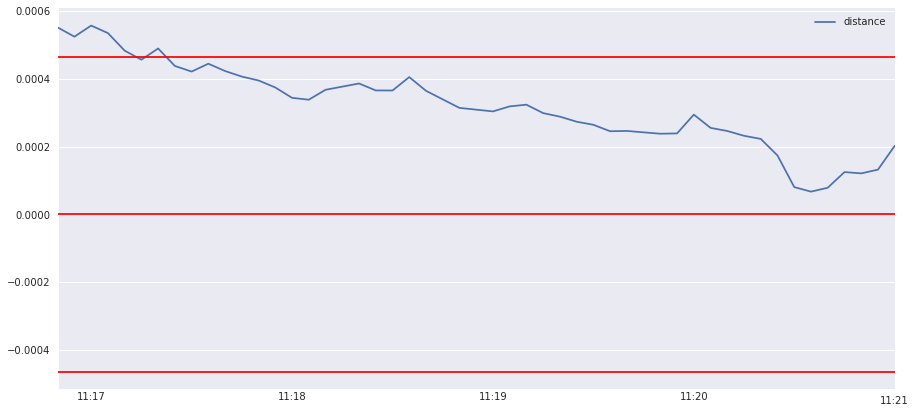

In [38]:
mean.resam['distance'].dropna().plot(figsize=(15, 7), legend=True)  
plt.axhline(threshold, color='r')
plt.axhline(-threshold, color='r')
plt.axhline(0, color='r');

## Risk Management & Capital Management

This section adresses the risk management and risk analysis of the trading strategy. At the first part we describe the strategy characteristics then upon those characteristics we decide how much leverage should we apply. then at the later parts, we calculate VaR figures coupled with tail-risk analysis.

#### Strategy Characteristics

One of the major factors which influence risk and return in the trading is the selection of algorithmic trading strategy itself. We argue, this is the most important risk management task. Below, we will first define the characteristic of the strategy.  

In [39]:
import tpqoa

In [40]:
oanda = tpqoa.tpqoa('algotrader.pyg')

In [41]:
import pandas as pd

In [42]:
data = oanda.get_history('AUD_NZD',
                        start='2017-11-2',
                        end='2017-11-3',
                        granularity='S30',
                        price='A')['c']

In [43]:
data = pd.DataFrame(data)

In [44]:
data.columns = ['prices']

In [45]:
data.fillna(0, inplace=True)

from here onwards, we resample the data into 30 second intervals and do the backtesting

In [46]:
data = data.resample('30s').last().ffill()

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2880 entries, 2017-11-02 00:00:00 to 2017-11-02 23:59:30
Freq: 30S
Data columns (total 1 columns):
prices    2880 non-null float64
dtypes: float64(1)
memory usage: 45.0 KB


In [48]:
data.tail()

,prices
time,
2017-11-02 23:57:30,1.11616
2017-11-02 23:58:00,1.11599
2017-11-02 23:58:30,1.11605
2017-11-02 23:59:00,1.11599
2017-11-02 23:59:30,1.11607


In [49]:
import numpy as np

In [50]:
data['returns'] = np.log(data['prices'] / data['prices'].shift(1))

In [51]:
SMA = 138 # using half-life of mean reversion as SMA value

In [52]:
data['SMA'] = data['prices'].rolling(SMA).mean()

In [53]:
data['distance'] = data['prices'] - data['SMA']

In [54]:
data['distance'].std() # this gives our treshold value

0.0004627014405625458

In [55]:
threshold = 0.0004627014405625458

Mean reversion trades have been visualized below

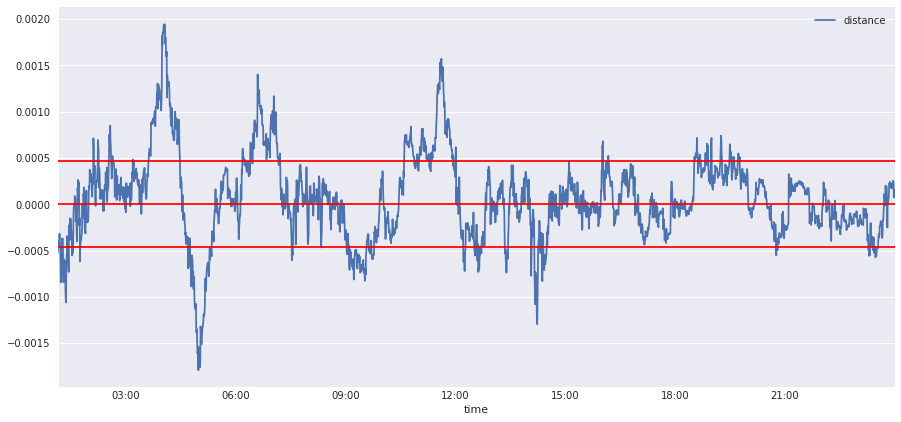

In [56]:
data['distance'].dropna().plot(figsize=(15, 7), legend=True)  
plt.axhline(threshold, color='r')
plt.axhline(-threshold, color='r')
plt.axhline(0, color='r');

We put our trading logic

In [57]:
data['position'] = np.where(data['distance'] > threshold,-1, np.nan)

In [58]:
data['position'] = np.where(data['distance'] < -threshold,1, data['position'])

In [59]:
data['position'] = np.where(data['distance'] *data['distance'].shift(1) < 0, 0, data['position'])

In [60]:
data['position'] = data['position'].ffill().fillna(0)

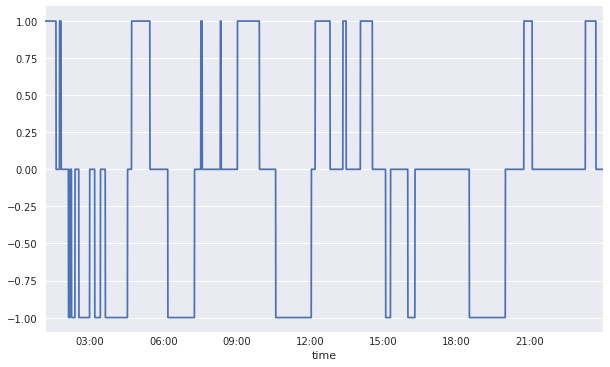

In [61]:
data['position'].iloc[SMA:].plot(figsize=(10, 6)); # visualizing the positions (1=long, -1=short)

In [62]:
data['strategy'] = data['position'].shift(1) * data['returns']

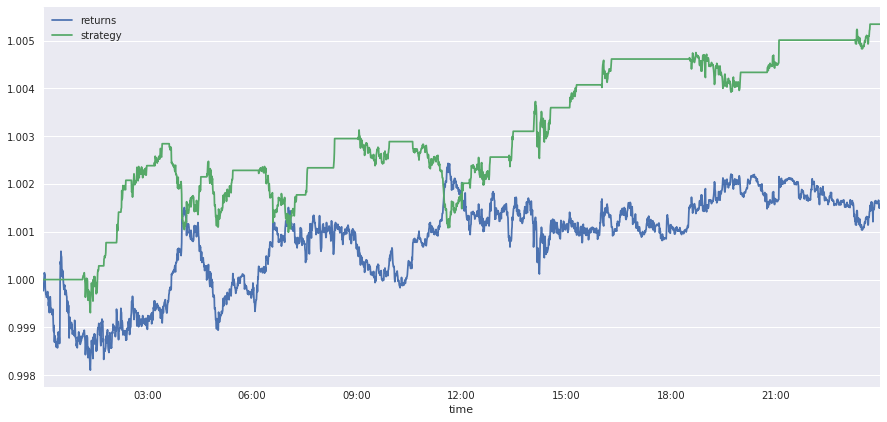

In [63]:
data[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(15, 7)); # performance visualized

#### Basic Statistics of the strategy 

In [64]:
# annualized mean return
mean = data[['returns', 'strategy']].mean() * 2 * 60 * 24 * 252
mean

returns     0.395584
strategy    1.343486
dtype: float64

In [65]:
# annualized variance
var = data[['returns', 'strategy']].var() * 2 * 60 * 24 * 252
var

returns     0.006545
strategy    0.002864
dtype: float64

In [66]:
# annualized volatility
var ** 0.5

returns     0.080900
strategy    0.053519
dtype: float64

In [67]:
# calculates optimal kelly criterion, which suggest how much capital should we allocate
mean / var

returns      60.442113
strategy    469.039257
dtype: float64

In [68]:
mean / var * 0.5 # half kelly leverage

returns      30.221057
strategy    234.519628
dtype: float64

Optimal leverage is 234% according to the kelly criterion, which is really high. Although such a leverage ratio is possible we prefer to use more prudent leverage ratio. Below we have demostrated several leverage ratios ranging from 10% to 50% and tested our trading strategy accordigly. 

#### Leverage

In [69]:
to_plot = ['returns', 'strategy']

In [70]:
for l in [10, 20, 30, 40, 50]:
    label = 'lstrategy_%d' % l
    data[label] = data['strategy'] * l
    to_plot.append(label)

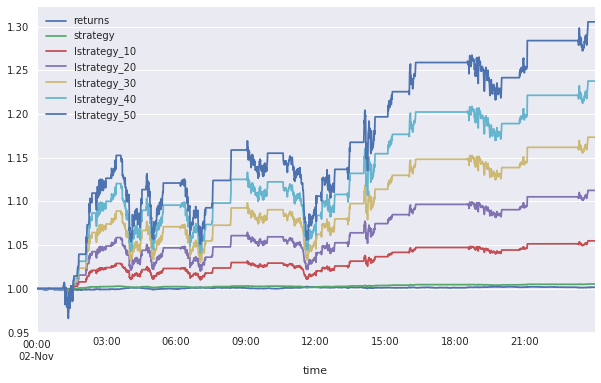

In [71]:
# this polot shows leverage has a high impact on strategy performance
data[to_plot].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [72]:
# this code counts the long and short positions
data.position.value_counts() 

 0.0    1610
-1.0     756
 1.0     514
Name: position, dtype: int64

In [73]:
sum(abs(data.position.diff()) > 1.5) # this counts the number of trades

0

#### Resulting risk statistics

We choose 30% leverage, and calculated below the resulting risk statistics. We assumed that allocated capital is 100,000 AUD 

In [74]:
risk = pd.DataFrame(data['lstrategy_30']) # we create a new dataframe object for risk analysis

In [75]:
# calculates the new equity position over time given the leverage
risk['equity'] = risk['lstrategy_30'].cumsum().apply(np.exp) * 100000 

In [76]:
risk['cummax'] = risk['equity'].cummax() # cummulative maximum

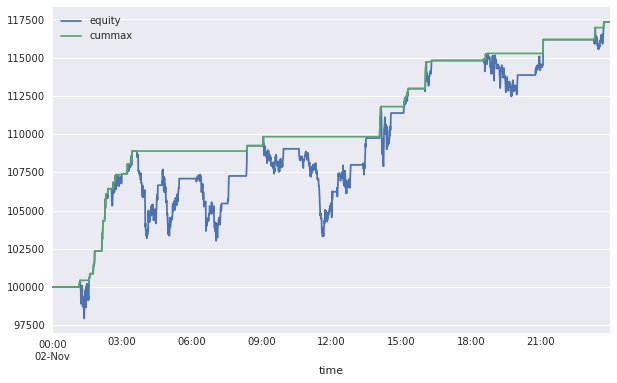

In [77]:
# plots the evolution of the equity position and the running maximum over time given 30% leverage
risk[['equity', 'cummax']].plot(figsize=(10, 6));

In [78]:
risk['drawdown'] = risk['cummax'] - risk['equity'] # calculates abosolute drawdown over time

In [79]:
# identifying the maximum drawdown value, we found out that maximum drawdown is quite large to accept for an intraday strategy
risk['drawdown'].max()

6529.8882703795098

In [80]:
# Identifies all those points in time where there is a new running maximum in the equity value.
temp = risk['drawdown'][risk['drawdown'] == 0] 

In [81]:
# Calculates the timedelta values for all those points.
periods = (temp.index[1:].to_pydatetime() -
           temp.index[:-1].to_pydatetime())

In [82]:
# Identifies the longest period between two such points (in seconds)
t = periods.max()

In [83]:
t # drawdown period in seconds

datetime.timedelta(0, 18030)

In [84]:
# Transforms the seconds to hours.
t.seconds / 60 / 60 #drawdown period in hours

5.008333333333334

#### VaR (value at risk) analysis

Although the base data is not too large, we could still calculate and demonstrate VaR measures. 

In [85]:
# we use stats subpackage of Scipy
import scipy.stats as scs

In [86]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
VaR = scs.scoreatpercentile(100000 - risk['equity'], percs) # we defined 90.0%, 95.0%, 97.5%, 99.0%, 99.9% confidence levels

In [87]:
VaR.round(2) # prints the absolute loss values

array([-17337.39, -17337.39, -17337.39, -16175.97, -16175.97, -16175.97])

In [88]:
# Prints confidence intervals and the positive VaR values (according to convention)
print("%16s %16s" % ('Confidence Level', 'Value-at-Risk'))
print(33 * "-")
for pair in zip(percs, VaR):
    print("%16.2f %16.3f" % (100 - pair[0], -pair[1]))

Confidence Level    Value-at-Risk
---------------------------------
           99.99        17337.390
           99.90        17337.390
           99.00        17337.390
           97.50        16175.969
           95.00        16175.969
           90.00        16175.969


According to the VaR analysis, implementing our strategy, there is a 1% chance that our position of 100.000 AUD may lose more than 17,337 AUD during the trading day.  

#### Tail Risk

We can observe and identify tail risk as the largest negative return observed. 

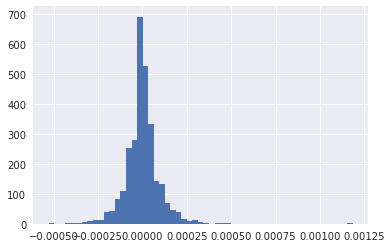

In [89]:
data.returns.hist(bins=55);

In [90]:
data.returns.min() # this gives us the largest negative return

-0.00052897008966234387

In [91]:
data.returns.argmin() # this tells us when this worst return happened

Timestamp('2017-11-02 14:04:00', freq='30S')

In [92]:
risk['lstrategy_30'].min() #This gives the lowest return given the time interval of the data set 30 seconds

-0.014792170311029657

In [93]:
risk['lstrategy_30'].argmin() # This gives the time interval for which the lowest return is observed

Timestamp('2017-11-02 03:59:30', freq='30S')

## Conclusion

With the above study we have demonstrated how to pick a suitable currency pair for mean reversion strategy. We choose to implement our strategy on AUD/NZD which we belive this pair has strong commodity influence but also neutr interest rate play. It performed well and satisfied our tests. However, for any currency pair one can apply ADF and Hurst tests to test for stationarity then upon confirmation of the mean reversion, check for halflife of mean reversion. We have put those parameters into our trading logic and automated the algorithm to trade intra-day. However, we faced a limit to our ticket number and our code stoped after 1000 tickets generated or/and our given NAV value limit reached. Therefore we could only backtest to the see effect on trading. 

In addition, we have demonstrated the calculation of risk & capital parameters. We have calculated the Kely Criteria and demonstrated the effect of leverage. And at the last part we have concluded our analysis with the calculation of VaR and Tail Risk. We think that our sample time series data is far too little to give us an accurate risk metrics, and we believe securing such metrics in such a small sample data would not be reliable to implement an intra day trading strategy. 

#### Sources

Coding of the necessary algorithm is hugely influenced by the Certificate Program in Algorithmic Trading with Python course material, also Dr.Yves Hilpisch's book "Python for Algorithmic Trading" and Ernest P.Chan "Algorithmic Trading" are used to implement the trading logic and statistical tests.  